#Trabajo Práctico Final Visión por Computadora

Julián Gerónimo García

Noviembre 2024

Tecnicatura Universitaria en Inteligencia Artificial

Facultad de Ciencias Exactas, Ingeniería y Agrimensura


##1.Objeto

El presente trabajo tiene por objeto...

##Pendientes

##2.Referencias

https://gentle-cress-e61.notion.site/Unidad-2-Modelos-de-visi-n-y-aplicaciones-c7cb2ad5875a494da1f25fd88af5c6f4

https://gentle-cress-e61.notion.site/Unidad-3-Entrenamiento-de-modelos-de-visi-n-a7783d82189744c5ac4fee17d79c9a10

https://gentle-cress-e61.notion.site/Unidad-4-Procesamiento-de-video-en-tiempo-real-4ab4df68fa5a46bd84cbea0e6da24028

https://gentle-cress-e61.notion.site/Unidad-5-Modelos-generativos-c9d69586b7694c80aefa9c6afcebd9e2

https://gentle-cress-e61.notion.site/Unidad-6-Reconocimiento-y-Comprensi-n-de-Texto-8c6b0ed423184e5da9e3eb57e4450b31

https://docs.ultralytics.com/es/datasets/pose/dog-pose/

https://docs.google.com/document/d/1_HHoDjIp145Gve29GJv1qq718AONe0WtbAs9Xsm-Gss/edit?tab=t.0#heading=h.pd9bv9seyx41

https://www.youtube.com/watch?v=qExwIfed7jg&ab_channel=AmericanKennelClub

##3.Setup

Se setea el entorno instalando e importando las librerías y dependencias a utilizar, y fijando parámetros.

In [ ]:
!pip install tensorflow
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 12.0 MB/s eta 0:00:00


In [47]:
from collections import Counter
from collections import defaultdict
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files
from IPython.display import display, clear_output
import ipywidgets as widgets
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import random
import requests
import seaborn as sns
import shutil
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.image import resize
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import torch
from tqdm import tqdm
from ultralytics import YOLO
import yaml
import zipfile

In [ ]:
#Fijación de semillas para reproducibilidad de resultados
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

##4.Funciones

A lo largo del trabajo se utilizarán funciones personalizadas que se detallan a continuación.

###4.1.Funciones para Evaluación del modelo

In [ ]:
def plot_training_validation_loss(data, title='Training and Validation Loss'):
    """
    Función para graficar las pérdidas de entrenamiento y validación.

    Parameters:
    - data (pd.DataFrame): DataFrame que contiene las columnas de pérdida.
    - title (str): Título del gráfico. Default: 'Training and Validation Loss'.
    """
    plt.figure(figsize=(12, 6))

    # Graficar las pérdidas de entrenamiento
    if 'train/box_loss' in data.columns:
        plt.plot(data['epoch'], data['train/box_loss'], label='Box Loss (Train)', color='blue')
    if 'train/pose_loss' in data.columns:
        plt.plot(data['epoch'], data['train/pose_loss'], label='Pose Loss (Train)', color='green')

    # Graficar las pérdidas de validación
    if 'val/box_loss' in data.columns:
        plt.plot(data['epoch'], data['val/box_loss'], label='Box Loss (Val)', color='red')
    if 'val/pose_loss' in data.columns:
        plt.plot(data['epoch'], data['val/pose_loss'], label='Pose Loss (Val)', color='orange')

    # Configuración del gráfico
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def plot_map_metrics(data, title='Metrics (mAP) During Training'):
    """
    Función para graficar las métricas mAP50 y mAP50-95 durante el entrenamiento.

    Parameters:
    - data (pd.DataFrame): DataFrame que contiene las columnas 'metrics/mAP50(B)' y 'metrics/mAP50-95(B)'.
    - title (str): Título del gráfico. Por defecto: 'Metrics (mAP) During Training'.
    """
    plt.figure(figsize=(12, 6))

    # Graficar las métricas mAP50 y mAP50-95
    if 'metrics/mAP50(B)' in data.columns:
        plt.plot(data['epoch'], data['metrics/mAP50(B)'], label='mAP@50 (B)', color='purple')
    if 'metrics/mAP50-95(B)' in data.columns:
        plt.plot(data['epoch'], data['metrics/mAP50-95(B)'], label='mAP@50-95 (B)', color='brown')

    # Configurar el gráfico
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

def plot_precision_recall(data, title='Precision and Recall During Training'):
    """
    Función para graficar la precisión y recall durante el entrenamiento.

    Parameters:
    - data (pd.DataFrame): DataFrame que contiene las columnas 'metrics/precision(B)' y 'metrics/recall(B)'.
    - title (str): Título del gráfico. Por defecto: 'Precision and Recall During Training'.
    """
    plt.figure(figsize=(12, 6))

    # Graficar precisión y recall
    if 'metrics/precision(B)' in data.columns:
        plt.plot(data['epoch'], data['metrics/precision(B)'], label='Precision (B)', color='blue')
    if 'metrics/recall(B)' in data.columns:
        plt.plot(data['epoch'], data['metrics/recall(B)'], label='Recall (B)', color='green')

    # Configurar el gráfico
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def load_latest_training_results(base_dir="runs/pose/"):
    """
    Encuentra la carpeta más reciente en el directorio base y carga el archivo results.csv.

    Args:
        base_dir (str): Directorio donde se encuentran los resultados de entrenamiento.

    Returns:
        pd.DataFrame: DataFrame con los resultados del entrenamiento.
        str: Ruta de la carpeta del último entrenamiento.
    """
    # Obtener la lista de carpetas en el directorio base
    subdirs = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    # Ordenar las carpetas por fecha de modificación (más reciente primero)
    subdirs = sorted(subdirs, key=os.path.getmtime, reverse=True)

    # Tomar la carpeta más reciente
    latest_dir = subdirs[0] if subdirs else None
    if latest_dir:
        results_path = os.path.join(latest_dir, "results.csv")
        if os.path.exists(results_path):
            print(f"Cargando resultados desde: {results_path}")
            return pd.read_csv(results_path), latest_dir
        else:
            raise FileNotFoundError(f"No se encontró el archivo results.csv en {latest_dir}")
    else:
        raise FileNotFoundError("No se encontraron carpetas en el directorio base.")

In [ ]:
def evaluate_and_plot_confusion_matrix(model_k, model_p, scaler, images_dir, labels_dir, lesskeypoints_list):
    """
    Evalúa el modelo en un conjunto de prueba y genera una matriz de confusión.

    Args:
        model_k: Modelo YOLO para detectar keypoints.
        model_p: Modelo para clasificar la pose.
        scaler: Scaler usado para normalizar las coordenadas.
        images_dir: Ruta de la carpeta de imágenes.
        labels_dir: Ruta de la carpeta de etiquetas.
        lesskeypoints_list: Lista de índices de los keypoints a usar para el modelo de clasificación.
    """
    # Etiquetas
    class_labels = ["Tumbado", "Sentado", "Parado"]
    y_true = []  # Etiquetas reales
    y_pred = []  # Etiquetas predichas

    # Listar todas las imágenes en la carpeta
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]

    # Usar tqdm para mostrar barra de progreso
    for image_name in tqdm(image_files, desc="Procesando imágenes"):
        # Ruta de la imagen y su etiqueta
        image_path = os.path.join(images_dir, image_name)
        label_path = os.path.join(labels_dir, os.path.splitext(image_name)[0] + ".txt")

        # Leer la etiqueta real desde el archivo correspondiente
        if not os.path.exists(label_path):
            print(f"Etiqueta no encontrada para la imagen {image_name}. Saltando...")
            continue
        with open(label_path, "r") as label_file:
            true_label = label_file.read().strip()

        # Cargar la imagen y realizar predicción
        image = cv2.imread(image_path)
        results = model_k(image)

        # Obtener keypoints
        coordinates_example = []
        if hasattr(results[0], "keypoints") and results[0].keypoints is not None:
            keypoints_data = results[0].keypoints.data.cpu().numpy()
            for row in keypoints_data[0]:
                coordinates_example.append((float(row[0]), float(row[1])))
        else:
            coordinates_example = [(0.00, 0.00)] * 24

        # Filtrar los keypoints
        filtered_coordinates = [coordinates_example[i] for i in lesskeypoints_list]
        expected_features = len(lesskeypoints_list)
        filtered_coordinates = filtered_coordinates[:expected_features]
        filtered_coordinates.extend([(0.0, 0.0)] * (expected_features - len(filtered_coordinates)))

        # Normalizar coordenadas
        input_data = np.array(filtered_coordinates).flatten().reshape(1, -1)
        input_data_normalized = scaler.transform(input_data)

        # Predicción de la pose
        probabilities = model_p.predict(input_data_normalized)
        predicted_class_index = np.argmax(probabilities)
        predicted_class_label = class_labels[predicted_class_index]

        # Guardar resultados
        y_true.append(true_label)
        y_pred.append(predicted_class_label)

    # Generar matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    report = classification_report(y_true, y_pred, target_names=class_labels)
    print("Reporte de clasificación:")
    print(report)

    # Graficar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Etiqueta Predicha")
    plt.ylabel("Etiqueta Verdadera")
    plt.title("Matriz de Confusión")
    plt.show()


###4.2.Funciones para Inferencia

In [ ]:
def predict_random_image(model, images_path):
    """
    Selecciona una imagen aleatoria de la carpeta, realiza una predicción utilizando el modelo proporcionado,
    dibuja los keypoints y conecta los puntos especificados por pares definidos dentro de la función.
    Además, coloca un número pequeño junto a cada keypoint.

    Argumentos:
        model: Modelo YOLO cargado previamente.
        images_path: Ruta de la carpeta que contiene las imágenes.
    """
    # Verificar si la ruta existe
    if not os.path.exists(images_path):
        raise FileNotFoundError(f"La ruta especificada no existe: {images_path}")

    # Listar todas las imágenes en la carpeta
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png'))]

    # Verificar si hay imágenes en la carpeta
    if not image_files:
        raise FileNotFoundError(f"No se encontraron imágenes en la ruta: {images_path}")

    # Seleccionar una imagen aleatoria
    random_image = random.choice(image_files)
    random_image_path = os.path.join(images_path, random_image)

    # Cargar la imagen seleccionada
    image = cv2.imread(random_image_path)

    # Realizar la predicción
    results = model(image)

    # Dibujar los resultados en la imagen
    annotated_image = results[0].plot()

    # Obtener keypoints de la predicción
    keypoints = []
    if hasattr(results[0], "keypoints") and results[0].keypoints is not None:
        # Extraer las coordenadas (x, y) ignorando el tercer valor (confianza)
        keypoints_data = results[0].keypoints.data.cpu().numpy()  # Convertir a numpy array
        for row in keypoints_data[0]:  # Suponiendo que es un array 3D [1, N, 3]
            keypoints.append((float(row[0]), float(row[1])))  # Solo (x, y)
    else:
        print("No se encontraron keypoints en los resultados.")

    # Dibujar los keypoints con números junto a ellos
    for i, (x, y) in enumerate(keypoints):
        if (x, y) != (0.0, 0.0):  # Dibujar solo keypoints válidos
            # Dibujar el punto
            cv2.circle(annotated_image, (int(x), int(y)), radius=5, color=(0, 255, 0), thickness=-1)
            # Dibujar el número pequeño junto al punto
            cv2.putText(
                annotated_image,
                str(i),  # Número del keypoint
                (int(x) + 5, int(y) - 5),  # Posición del texto
                cv2.FONT_HERSHEY_SIMPLEX,
                0.4,  # Tamaño de la fuente
                (255, 255, 255),  # Color del texto
                1,  # Grosor del texto
                cv2.LINE_AA
            )

    # Definir los pares de puntos a conectar dentro de la función
    pairs_to_connect = [(1, 2), (2, 3), (4, 5), (5, 6), (7, 8), (8, 9), (10, 11), (11, 12), (13, 14), (15, 19), (15, 17), (16, 17), (17, 18), (16, 20)]

    # Dibujar líneas entre los puntos especificados en pairs_to_connect
    for pair in pairs_to_connect:
        idx1, idx2 = pair  # Desempaquetar el par de índices
        if idx1 <= len(keypoints) and idx2 <= len(keypoints):  # Verificar que los índices sean válidos
            x1, y1 = keypoints[idx1 - 1]
            x2, y2 = keypoints[idx2 - 1]
            # Verificar que ninguno de los puntos tenga coordenadas (0, 0)
            if (x1, y1) != (0.0, 0.0) and (x2, y2) != (0.0, 0.0):
                pt1 = (int(x1), int(y1))
                pt2 = (int(x2), int(y2))
                cv2.line(annotated_image, pt1, pt2, color=(0, 255, 0), thickness=2)  # Línea verde

    # Mostrar la imagen anotada con las líneas
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Ocultar los ejes
    plt.show()

    # Mostrar los keypoints debajo de la imagen
    if keypoints:
        print("Keypoints detectados (x, y):")
        for i, (x, y) in enumerate(keypoints):
            print(f"{i}: (x: {x:.2f}, y: {y:.2f})")

###4.3.Funciones para etiquetado

In [ ]:
# Función para etiquetar una imagen
def label_current_image():
    global current_index

    # Si no hay más imágenes, finalizar
    if current_index >= len(image_files):
        clear_output()
        print("¡Todas las imágenes han sido etiquetadas!")
        print(f"Total de imágenes etiquetadas: {len(output_labels)}")
        # Guardar las etiquetas al finalizar
        with open('output_labels.json', 'w') as f:
            json.dump(output_labels, f)
        return

    # Mostrar imagen actual
    img_name = image_files[current_index]
    img_path = os.path.join(images_path, img_name)
    clear_output()  # Limpiar la salida para mostrar solo la imagen actual
    print(f"Imágenes etiquetadas: {len(output_labels)} / {len(image_files)}")  # Contador
    display(Image.open(img_path))  # Mostrar la imagen

    # Selector de etiquetas
    label = widgets.RadioButtons(
        options=['Parado', 'Sentado', 'Tumbado', 'Otro'],  # Opciones de etiqueta
        description='Etiqueta:',
        disabled=False
    )
    display(label)

    # Botón para guardar la etiqueta
    button = widgets.Button(description="Guardar Etiqueta")
    display(button)

    # Función para guardar la etiqueta y avanzar a la siguiente imagen
    def save_label(b):
        global current_index
        output_labels[img_name] = label.value
        print(f"Etiqueta '{label.value}' guardada para {img_name}")
        current_index += 1  # Avanzar al siguiente índice
        label_current_image()  # Mostrar la siguiente imagen

    button.on_click(save_label)

In [ ]:
def label_current_image_with_keypoints(model, images_path):
    global current_index

    # Si no hay más imágenes, finalizar
    if current_index >= len(image_files):
        clear_output()
        print("¡Todas las imágenes han sido etiquetadas!")
        print(f"Total de imágenes etiquetadas: {len(output_labels)}")
        # Guardar las etiquetas al finalizar
        with open('output_labels.json', 'w') as f:
            json.dump(output_labels, f)
        return

    # Mostrar imagen actual
    img_name = image_files[current_index]
    img_path = os.path.join(images_path, img_name)
    clear_output()  # Limpiar la salida para mostrar solo la imagen actual
    print(f"Imágenes etiquetadas: {len(output_labels)} / {len(image_files)}")  # Contador

    # Cargar la imagen actual
    image = cv2.imread(img_path)

    # Realizar la predicción
    results = model(image)

    # Dibujar los resultados en la imagen
    annotated_image = results[0].plot()

    # Obtener keypoints de la predicción
    keypoints = []
    if hasattr(results[0], "keypoints") and results[0].keypoints is not None:
        # Extraer las coordenadas (x, y) ignorando el tercer valor (confianza)
        keypoints_data = results[0].keypoints.data.cpu().numpy()  # Convertir a numpy array
        for row in keypoints_data[0]:  # Suponiendo que es un array 3D [1, N, 3]
            keypoints.append((float(row[0]), float(row[1])))  # Solo (x, y)

    # Definir los pares de puntos a conectar
    pairs_to_connect = [(1, 2), (2, 3), (4, 5), (5, 6), (7, 8), (8, 9), (10, 11), (11, 12), (13, 14), (15, 19), (15, 17), (16, 17), (17, 18), (16, 20)]

    # Dibujar líneas entre los puntos especificados en pairs_to_connect
    for pair in pairs_to_connect:
        idx1, idx2 = pair  # Desempaquetar el par de índices
        if idx1 <= len(keypoints) and idx2 <= len(keypoints):  # Verificar que los índices sean válidos
            x1, y1 = keypoints[idx1 - 1]
            x2, y2 = keypoints[idx2 - 1]
            # Verificar que ninguno de los puntos tenga coordenadas (0, 0)
            if (x1, y1) != (0.0, 0.0) and (x2, y2) != (0.0, 0.0):
                pt1 = (int(x1), int(y1))  # Convertir a entero
                pt2 = (int(x2), int(y2))
                cv2.line(annotated_image, pt1, pt2, color=(0, 255, 0), thickness=2)  # Línea verde

    # Mostrar la imagen anotada con los keypoints
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Ocultar los ejes
    plt.show()

    # Selector de etiquetas
    label = widgets.RadioButtons(
        options=['Parado', 'Sentado', 'Tumbado', 'Otro'],  # Opciones de etiqueta
        description='Etiqueta:',
        disabled=False
    )
    display(label)

    # Botón para guardar la etiqueta
    button = widgets.Button(description="Guardar Etiqueta")
    display(button)

    # Función para guardar la etiqueta y avanzar a la siguiente imagen
    def save_label(b):
        global current_index
        output_labels[img_name] = label.value
        print(f"Etiqueta '{label.value}' guardada para {img_name}")
        current_index += 1  # Avanzar al siguiente índice
        label_current_image_with_keypoints(model, images_path)  # Mostrar la siguiente imagen

    button.on_click(save_label)

In [ ]:
# Función para procesar y reetiquetar imágenes con keypoints y líneas
def relabel_image_with_keypoints(target_class, json_path, images_path, model):
    # Cargar etiquetas desde el archivo JSON
    with open(json_path, "r") as f:
        labels = json.load(f)

    # Filtrar imágenes etiquetadas con la clase específica
    image_files = [img_name for img_name, label in labels.items() if label == target_class]
    current_index = 0  # Índice inicial
    global output_labels  # Asegurarse de que output_labels sea global
    output_labels = labels.copy()  # Hacer una copia de las etiquetas originales

    # Si no hay imágenes para procesar, finalizar
    if len(image_files) == 0:
        clear_output()
        print(f"No se encontraron imágenes etiquetadas como '{target_class}'.")
        return

    # Función para procesar cada imagen
    def process_image():
        nonlocal current_index  # Para modificar la variable dentro de la función interna

        # Si no hay más imágenes, finalizar
        if current_index >= len(image_files):
            clear_output()
            print("¡Todas las imágenes de la clase seleccionada han sido etiquetadas!")
            print(f"Total de imágenes etiquetadas: {len(output_labels)}")
            # Guardar las etiquetas al finalizar
            with open(json_path, "w") as f:
                json.dump(output_labels, f, indent=4)
            return

        # Mostrar imagen actual
        img_name = image_files[current_index]
        img_path = os.path.join(images_path, img_name)
        clear_output()  # Limpiar la salida para mostrar solo la imagen actual
        print(f"Imágenes etiquetadas: {current_index + 1} / {len(image_files)}")  # Contador

        # Cargar la imagen actual
        image = cv2.imread(img_path)
        if image is None:
            print(f"No se pudo cargar la imagen: {img_name}")
            current_index += 1
            process_image()
            return

        # Realizar la predicción de keypoints
        results = model(image)

        # Dibujar los resultados en la imagen
        annotated_image = results[0].plot()

        # Obtener keypoints de la predicción
        keypoints = []
        if hasattr(results[0], "keypoints") and results[0].keypoints is not None:
            # Extraer las coordenadas (x, y) ignorando el tercer valor (confianza)
            keypoints_data = results[0].keypoints.data.cpu().numpy()  # Convertir a numpy array
            for row in keypoints_data[0]:  # Suponiendo que es un array 3D [1, N, 3]
                keypoints.append((float(row[0]), float(row[1])))

        # Definir los pares de puntos a conectar
        pairs_to_connect = [(1, 2), (2, 3), (4, 5), (5, 6), (7, 8), (8, 9), (10, 11), (11, 12), (13, 14), (15, 19), (15, 17), (16, 17), (17, 18), (16, 20)]

        # Dibujar líneas entre los puntos especificados en pairs_to_connect
        for pair in pairs_to_connect:
            idx1, idx2 = pair  # Desempaquetar el par de índices
            if idx1 <= len(keypoints) and idx2 <= len(keypoints):  # Verificar que los índices sean válidos
                x1, y1 = keypoints[idx1 - 1]
                x2, y2 = keypoints[idx2 - 1]
                # Verificar que ninguno de los puntos tenga coordenadas (0, 0)
                if (x1, y1) != (0.0, 0.0) and (x2, y2) != (0.0, 0.0):
                    pt1 = (int(x1), int(y1))  # Convertir a entero
                    pt2 = (int(x2), int(y2))
                    cv2.line(annotated_image, pt1, pt2, color=(0, 255, 0), thickness=2)  # Línea verde

        # Mostrar la imagen anotada con los keypoints
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Ocultar los ejes
        plt.title(f"Etiqueta actual: {output_labels[img_name]}")
        plt.show()

        # Selector de etiquetas
        label = widgets.RadioButtons(
            options=['Parado', 'Sentado', 'Tumbado', 'Otro'],  # Opciones de etiqueta
            value=output_labels[img_name],  # Etiqueta actual como valor predeterminado
            description='Etiqueta:',
            disabled=False
        )
        display(label)

        # Botón para guardar la etiqueta
        button = widgets.Button(description="Guardar Etiqueta")
        display(button)

        # Función para guardar la etiqueta y avanzar a la siguiente imagen
        def save_label(b):
            nonlocal current_index
            previous_label = output_labels[img_name]  # Obtener la etiqueta anterior
            new_label = label.value  # Nueva etiqueta seleccionada
            output_labels[img_name] = new_label
            print(f"Etiqueta para '{img_name}' cambiada de '{previous_label}' a '{new_label}'")
            current_index += 1  # Avanzar al siguiente índice
            process_image()  # Mostrar la siguiente imagen

        button.on_click(save_label)

    # Iniciar el proceso para la primera imagen
    process_image()

In [ ]:
#Funciones para etiquetado automático

def predict_pose_with_prob(model_k, model_p, scaler, image_path, lesskeypoints_list):
    """
    Realiza la predicción de keypoints y la clasificación de la pose.
    Retorna la etiqueta predicha y la probabilidad asociada.

    Argumentos:
        model_k: Modelo YOLO para detectar keypoints.
        model_p: Modelo para clasificar la pose.
        scaler: Scaler usado para normalizar las coordenadas durante el entrenamiento del modelo de clasificación.
        image_path: Ruta de la imagen a procesar.
        lesskeypoints_list: Lista de índices de los keypoints a usar para la clasificación.

    Retorna:
        filtered_coordinates: Coordenadas filtradas para la clasificación (solo para debug).
        predicted_class_label: Clase predicha (ej., "Tumbado", "Sentado", "Parado").
        predicted_class_probability: Probabilidad de la clase predicha.
    """
    import cv2
    import numpy as np

    # Cargar la imagen
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"No se pudo cargar la imagen: {image_path}")

    # Realizar la predicción de keypoints
    results = model_k(image)

    # Obtener keypoints de la predicción
    coordinates_example = []
    if hasattr(results[0], "keypoints") and results[0].keypoints is not None:
        keypoints_data = results[0].keypoints.data.cpu().numpy()
        for row in keypoints_data[0]:
            coordinates_example.append((float(row[0]), float(row[1])))
    else:
        # Si no se detectan keypoints, rellenar con ceros
        coordinates_example = [(0.0, 0.0)] * 24

    # Filtrar los keypoints según lesskeypoints_list
    filtered_coordinates = [coordinates_example[i] for i in lesskeypoints_list]

    # Normalizar las coordenadas
    input_data = np.array(filtered_coordinates).flatten().reshape(1, -1)
    input_data_normalized = scaler.transform(input_data)

    # Realizar la predicción de la pose
    class_labels = ["Tumbado", "Sentado", "Parado"]
    probabilities = model_p.predict(input_data_normalized)
    predicted_class_index = np.argmax(probabilities)
    predicted_class_label = class_labels[predicted_class_index]
    predicted_class_probability = probabilities[0][predicted_class_index]

    return filtered_coordinates, predicted_class_label, predicted_class_probability

In [ ]:
def auto_label_images(
    model_k, model_p, scaler, images_path, lesskeypoints_list,
    output_json='labels5.json', threshold=0.95, num_images=None
):
    """
    Etiqueta automáticamente imágenes utilizando modelos YOLO y de clasificación de poses.
    Actualiza las etiquetas en el archivo JSON `labels5.json`.

    Argumentos:
        model_k: Modelo YOLO para detectar keypoints.
        model_p: Modelo para clasificar la pose.
        scaler: Scaler usado para normalizar las coordenadas durante el entrenamiento del modelo de clasificación.
        images_path: Ruta de la carpeta que contiene las imágenes.
        lesskeypoints_list: Lista de índices de los keypoints a usar para el modelo de clasificación.
        output_json: Nombre del archivo JSON para guardar las etiquetas y keypoints.
        threshold: Umbral de probabilidad mínimo para aceptar una predicción (por defecto 0.95).
        num_images: Número máximo de imágenes a etiquetar. Si es None, etiqueta todas.
    """
    # Verificar si la ruta de las imágenes existe
    if not os.path.exists(images_path):
        raise FileNotFoundError(f"La ruta especificada no existe: {images_path}")

    # Listar todas las imágenes en el directorio
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png'))]

    # Verificar si hay imágenes
    if not image_files:
        raise FileNotFoundError(f"No se encontraron imágenes en la ruta: {images_path}")

    # Cargar etiquetas existentes desde labels5.json
    labels = {}
    if os.path.exists(output_json):
        try:
            with open(output_json, 'r') as f:
                labels = json.load(f)
                print(f"Etiquetas cargadas desde {output_json}. Total: {len(labels)} imágenes etiquetadas.")
        except json.JSONDecodeError:
            print(f"Error: El archivo {output_json} está corrupto. Se regenerará un nuevo archivo.")
            labels = {}
    else:
        print(f"No se encontró {output_json}. Creando un nuevo archivo.")

    # Filtrar imágenes no etiquetadas
    image_files = [img for img in image_files if img not in labels]

    # Si num_images está definido, limitar el número de imágenes a procesar
    if num_images is not None:
        image_files = image_files[:num_images]

    # Barra de progreso con tqdm
    with tqdm(total=len(image_files), desc="Etiquetando imágenes") as pbar:
        for img_name in image_files:
            # Ruta completa de la imagen
            img_path = os.path.join(images_path, img_name)

            # Realizar la predicción usando predict_pose
            try:
                _, predicted_label, predicted_prob = predict_pose_with_prob(
                    model_k, model_p, scaler, img_path, lesskeypoints_list
                )
            except Exception as e:
                print(f"Error procesando la imagen {img_name}: {e}")
                pbar.update(1)
                continue

            # Verificar si la probabilidad supera el umbral
            if predicted_prob < threshold:
                print(f"Etiqueta descartada para '{img_name}' (Probabilidad: {predicted_prob:.2f})")
                pbar.update(1)
                continue

            # Guardar solo el nombre del archivo y la etiqueta
            labels[img_name] = predicted_label

            # Mostrar la etiqueta generada (opcional)
            print(f"Etiqueta '{predicted_label}' generada para la imagen '{img_name}'")

            # Actualizar la barra de progreso
            pbar.update(1)

    # Guardar las etiquetas actualizadas en labels5.json
    with open(output_json, 'w') as f:
        json.dump(labels, f, indent=4)

    print(f"Etiquetado completo. Total de imágenes etiquetadas: {len(labels)}")
    print(f"Etiquetas guardadas en: {output_json}")

###4.4.Funciones para armado de dataset

In [ ]:
def augment_coordinates(keypoints, augmentation_type="flip", params=None):
    """
    Aplica una transformación geométrica a las coordenadas de los keypoints.

    Argumentos:
        keypoints: Lista de tuplas (x, y) representando las coordenadas originales.
        augmentation_type: Tipo de aumentación ("flip", "translate", "scale", "rotate").
        params: Parámetros adicionales para la transformación (ej. ángulo de rotación).

    Devuelve:
        Lista de tuplas (x, y) con las coordenadas transformadas.
    """
    keypoints = np.array(keypoints)

    if augmentation_type == "flip":
        max_x = np.max(keypoints[:, 0])
        keypoints[:, 0] = max_x - keypoints[:, 0]
    elif augmentation_type == "translate":
        tx = params.get("tx", 0)
        ty = params.get("ty", 0)
        keypoints[:, 0] += tx
        keypoints[:, 1] += ty
    elif augmentation_type == "scale":
        sx = params.get("sx", 1.0)
        sy = params.get("sy", 1.0)
        keypoints[:, 0] *= sx
        keypoints[:, 1] *= sy
    elif augmentation_type == "rotate":
        angle = params.get("angle", 0)
        angle_rad = np.radians(angle)
        rotation_matrix = np.array([
            [np.cos(angle_rad), -np.sin(angle_rad)],
            [np.sin(angle_rad), np.cos(angle_rad)]
        ])
        keypoints = np.dot(keypoints, rotation_matrix.T)
    else:
        raise ValueError(f"Tipo de aumentación no soportado: {augmentation_type}")

    return keypoints.tolist()

In [ ]:
def keypoints_to_labels_with_balance(model, images_path, labels_data, output_file, balance_option=1, keypoints_list=None):
    """
    Procesa imágenes y etiquetas para generar un archivo .npy balanceado que contenga IDs, etiquetas y keypoints.

    Argumentos:
        model: Modelo YOLO cargado previamente.
        images_path: Ruta de la carpeta que contiene las imágenes.
        labels_data: Diccionario de etiquetas cargado desde labels.json.
        output_file: Nombre del archivo .npy donde se guardarán los resultados.
        balance_option: 1 para submuestreo, 2 para sobremuestreo con aumentación.
        keypoints_list: Lista de índices de keypoints que se desean utilizar (opcional).
    """
    # Mapeo de etiquetas a valores numéricos
    label_mapping = {
        "tumbado": 0,
        "sentado": 1,
        "parado": 2
    }

    # Diccionario para almacenar los datos por clase
    data_by_class = {0: [], 1: [], 2: []}

    # Procesar imágenes y obtener keypoints
    for image_name, label_text in labels_data.items():
        # Convertir la etiqueta de texto a su valor numérico
        label = label_mapping.get(label_text.lower(), -1)
        if label == -1:
            print(f"Etiqueta '{label_text}' no válida para la imagen {image_name}. Omitiendo.")
            continue

        # Ruta de la imagen
        image_path = os.path.join(images_path, image_name)

        # Verificar si la imagen existe
        if not os.path.exists(image_path):
            print(f"La imagen {image_name} no se encuentra en la ruta especificada. Omitiendo.")
            continue

        # Cargar la imagen
        image = cv2.imread(image_path)

        # Realizar la predicción
        results = model(image)

        # Obtener keypoints de la predicción
        keypoints = []
        if hasattr(results[0], "keypoints") and results[0].keypoints is not None:
            keypoints_data = results[0].keypoints.data.cpu().numpy()
            for row in keypoints_data[0]:
                keypoints.append((float(row[0]), float(row[1])))

        if not keypoints:
            print(f"No se encontraron keypoints para la imagen {image_name}. Omitiendo.")
            continue

        # Filtrar keypoints según la lista proporcionada
        if keypoints_list is not None:
            keypoints = [keypoints[i] for i in keypoints_list if i < len(keypoints)]

        # Agregar los datos a la clase correspondiente
        data_by_class[label].append([label, keypoints])

    # Balancear las clases
    balanced_data = []
    if balance_option == 1:  # Submuestreo
        min_class_size = min(len(data) for data in data_by_class.values())
        print(f"Balanceando al tamaño mínimo entre clases: {min_class_size}")
        for class_data in data_by_class.values():
            balanced_data.extend(random.sample(class_data, min_class_size))
    elif balance_option == 2:  # Sobremuestreo con aumentación
        max_class_size = max(len(data) for data in data_by_class.values())
        print(f"Balanceando al tamaño máximo entre clases: {max_class_size}")
        for label, class_data in data_by_class.items():
            while len(class_data) < max_class_size:
                original = random.choice(class_data)
                augmented_keypoints = augment_coordinates(
                    original[1],  # Keypoints
                    random.choice(["flip", "translate", "rotate", "scale"]),
                    params={
                        "tx": random.uniform(-10, 10),
                        "ty": random.uniform(-10, 10),
                        "angle": random.uniform(-5, 5),
                        "sx": random.uniform(0.8, 1.0),
                        "sy": random.uniform(0.8, 1.0)
                    }
                )
                class_data.append([label, augmented_keypoints])
            balanced_data.extend(class_data)
    else:
        raise ValueError("Opción no válida. Usa 1 para submuestreo o 2 para sobremuestreo.")

    # Agregar IDs a los datos balanceados y guardar
    data_with_ids = [[idx] + item for idx, item in enumerate(balanced_data)]
    np.save(output_file, np.array(data_with_ids, dtype=object))
    print(f"Datos balanceados y guardados exitosamente en {output_file}")

###4.5.Funciones para entrenamiento

In [ ]:
# Definir métrica personalizada para F1-score
def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)  # Redondear las predicciones
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)  # Verdaderos positivos
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)  # Falsos positivos
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)  # Falsos negativos

    precision = tp / (tp + fp + K.epsilon())  # Precisión
    recall = tp / (tp + fn + K.epsilon())  # Recall

    f1 = 2 * precision * recall / (precision + recall + K.epsilon())  # F1-score
    return K.mean(f1)  # Promedio del F1-score para todas las clases

###4.6.Funciones para predicción de pose

In [ ]:
def predict_pose(model_k, model_p, scaler, images_path, lesskeypoints_list):
    """
    Selecciona una imagen aleatoria de la carpeta, realiza una predicción utilizando el modelo proporcionado,
    dibuja los keypoints y conecta los puntos especificados por pares, mostrando la etiqueta sobre la imagen.
    Retorna las coordenadas en el formato especificado.

    Argumentos:
        model_k: Modelo YOLO para detectar keypoints.
        model_p: Modelo para clasificar la pose.
        scaler: Scaler usado para normalizar las coordenadas durante el entrenamiento del modelo de clasificación.
        images_path: Ruta de la carpeta que contiene las imágenes.
        lesskeypoints_list: Lista de índices de los keypoints a usar para el modelo de clasificación.

    Retorna:
        filtered_coordinates: Lista de coordenadas filtradas en el formato especificado.
        predicted_class_label: Etiqueta de la clase predicha.
    """
    import os
    import random
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    # Verificar si la ruta existe
    if not os.path.exists(images_path):
        raise FileNotFoundError(f"La ruta especificada no existe: {images_path}")

    # Listar todas las imágenes en la carpeta
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png'))]

    # Verificar si hay imágenes en la carpeta
    if not image_files:
        raise FileNotFoundError(f"No se encontraron imágenes en la ruta: {images_path}")

    # Seleccionar una imagen aleatoria
    random_image = random.choice(image_files)
    random_image_path = os.path.join(images_path, random_image)

    # Cargar la imagen seleccionada
    image = cv2.imread(random_image_path)
    image_no_text = image.copy()

    # Realizar la predicción de keypoints
    results = model_k(image)

    # Obtener keypoints de la predicción
    coordinates_example = []
    if hasattr(results[0], "keypoints") and results[0].keypoints is not None:
        keypoints_data = results[0].keypoints.data.cpu().numpy()  # Convertir a numpy array
        for row in keypoints_data[0]:  # Suponiendo que es un array 3D [1, N, 3]
            coordinates_example.append((float(row[0]), float(row[1])))
    else:
        print("No se encontraron keypoints en los resultados.")
        coordinates_example = [(0.00, 0.00)] * 24

    # Filtrar los keypoints según lesskeypoints_list
    filtered_coordinates = [coordinates_example[i] for i in lesskeypoints_list]

    # Asegurarse de que las dimensiones sean correctas (rellenar si faltan keypoints)
    expected_features = len(lesskeypoints_list)
    filtered_coordinates = filtered_coordinates[:expected_features]  # Recortar si hay más keypoints
    filtered_coordinates.extend([(0.0, 0.0)] * (expected_features - len(filtered_coordinates)))  # Rellenar si faltan

    # Dibujar los keypoints y las conexiones en la imagen
    pairs_to_connect = [(1, 2), (2, 3), (4, 5), (5, 6), (7, 8), (8, 9),
                        (10, 11), (11, 12), (13, 14), (15, 19), (15, 17),
                        (16, 17), (17, 18), (16, 20)]
    for i, (x, y) in enumerate(coordinates_example):
        if (x, y) != (0.00, 0.00):  # Dibujar solo keypoints válidos
            cv2.circle(image_no_text, (int(x), int(y)), radius=5, color=(0, 255, 0), thickness=-1)

    for pair in pairs_to_connect:
        idx1, idx2 = pair
        if idx1 <= len(coordinates_example) and idx2 <= len(coordinates_example):
            x1, y1 = coordinates_example[idx1 - 1]
            x2, y2 = coordinates_example[idx2 - 1]
            if (x1, y1) != (0.00, 0.00) and (x2, y2) != (0.00, 0.00):
                pt1 = (int(x1), int(y1))
                pt2 = (int(x2), int(y2))
                cv2.line(image_no_text, pt1, pt2, color=(0, 255, 0), thickness=2)

    # Normalizar las coordenadas
    input_data = np.array(filtered_coordinates).flatten().reshape(1, -1)
    input_data_normalized = scaler.transform(input_data)

    # Realizar la predicción de la pose
    class_labels = ["Tumbado", "Sentado", "Parado"]  # Etiquetas de las clases
    probabilities = model_p.predict(input_data_normalized)
    predicted_class_index = np.argmax(probabilities)
    predicted_class_label = class_labels[predicted_class_index]
    predicted_class_probability = probabilities[0][predicted_class_index]  # Probabilidad de la clase predicha

    # Mostrar la etiqueta y probabilidad sobre la imagen
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = f"{predicted_class_label}: {predicted_class_probability:.2f}"
    text_position = (20, 50)  # Posición del texto
    cv2.putText(image_no_text, text, text_position, font, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Mostrar la imagen anotada con la etiqueta
    plt.imshow(cv2.cvtColor(image_no_text, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Imprimir las probabilidades
    print(f"Clase predicha: {predicted_class_label}")
    print(f"Probabilidades: {probabilities[0]}")

    return filtered_coordinates, predicted_class_label

##5.Carga de datos

Se cargan los datos del repositorio "CV-TUIA-Garcia" y el dataset de Ultralytics para el entrenamiento de pose de perros.

In [ ]:
REPO_NAME = "CV-TUIA-Garcia"
if REPO_NAME not in os.getcwd():
  if not os.path.exists(REPO_NAME):
    !git clone https://github.com/juliangg17/CV-TUIA-Garcia.git
  os.chdir(REPO_NAME)

Cloning into 'CV-TUIA-Garcia'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 65 (delta 25), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 34.39 MiB | 15.85 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [ ]:
# URL del dataset
dataset_url = "https://github.com/ultralytics/assets/releases/download/v0.0.0/dog-pose.zip"
dataset_path = "./datasets/dog-pose"
dataset_zip_path = "./datasets/dog-pose.zip"

# Crear el directorio si no existe
os.makedirs("./datasets", exist_ok=True)

# Descargar el dataset si no está ya descargado
if not os.path.exists(dataset_zip_path):
    print("Descargando el dataset...")
    response = requests.get(dataset_url, stream=True)
    with open(dataset_zip_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print("Descarga completada.")

# Extraer el dataset si no está ya extraído
if not os.path.exists(dataset_path):
    print("Extrayendo el dataset...")
    with zipfile.ZipFile(dataset_zip_path, "r") as zip_ref:
        zip_ref.extractall("./datasets")
    print("Extracción completada.")

# Rutas principales
train_images_path = "./datasets/dog-pose/train/images"
train_labels_path = "./datasets/dog-pose/train/labels"
val_images_path = "./datasets/dog-pose/val/images"
val_labels_path = "./datasets/dog-pose/val/labels"

Descargando el dataset...
Descarga completada.
Extrayendo el dataset...
Extracción completada.


In [ ]:
zip_file = "label_pose.zip"  # Cambia a la ruta actual del archivo ZIP
destination_folder = "datasets/dog-pose/val"  # Carpeta destino en tu espacio de trabajo

# Mover el archivo ZIP a la carpeta destino
shutil.move(zip_file, os.path.join(destination_folder, os.path.basename(zip_file)))

print(f"El archivo {os.path.basename(zip_file)} se ha movido a {destination_folder}.")

El archivo label_pose.zip se ha movido a datasets/dog-pose/val.


In [ ]:
# Ruta del archivo ZIP
zip_file = "./datasets/dog-pose/val/label_pose.zip"  # Cambia esto a la ruta correcta del archivo ZIP
extract_to = "./datasets/dog-pose/val/label_pose"  # Carpeta destino para descomprimir

# Descomprimir el archivo ZIP
try:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"El archivo {zip_file} ha sido descomprimido en {extract_to}.")
except FileNotFoundError:
    print(f"Error: El archivo {zip_file} no fue encontrado. Verifica la ruta.")
except zipfile.BadZipFile:
    print(f"Error: {zip_file} no es un archivo ZIP válido.")


El archivo ./datasets/dog-pose/val/label_pose.zip ha sido descomprimido en ./datasets/dog-pose/val/label_pose.


##Entrenamiento del modelo k

Se entrena un modelo YOLO versión 11 para la obtención de los keypoints.

In [ ]:
# model = YOLO("yolo11n-pose.pt")

In [ ]:
# results = model.train(
#     data="dog-pose.yaml",
#     epochs=100,
#     imgsz=320,
#     batch=64,
#     patience=5,
#     optimizer="Adam",
#     device=0
# )

##Carga del modelo k

In [ ]:
# Ruta del archivo comprimido subido
uploaded_zip_path = "./train6_backup.zip"

# Ruta para descomprimir
output_folder_path = "./runs/pose/train6"

# Descomprimir el archivo
shutil.unpack_archive(uploaded_zip_path, output_folder_path)

print(f"Modelo cargado en: {output_folder_path}")


Modelo cargado en: ./runs/pose/train6


In [ ]:
model_best = YOLO("./runs/pose/train6/weights/best.pt")

##Evaluación del modelo k

In [ ]:
data, latest_dir = load_latest_training_results()

Cargando resultados desde: runs/pose/train6/results.csv


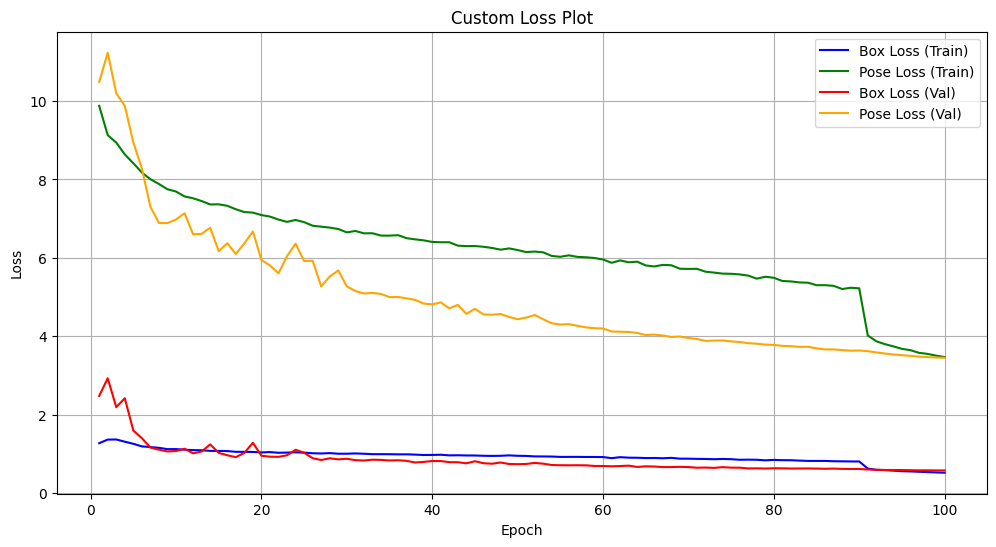

In [ ]:
plot_training_validation_loss(data, title="Custom Loss Plot")

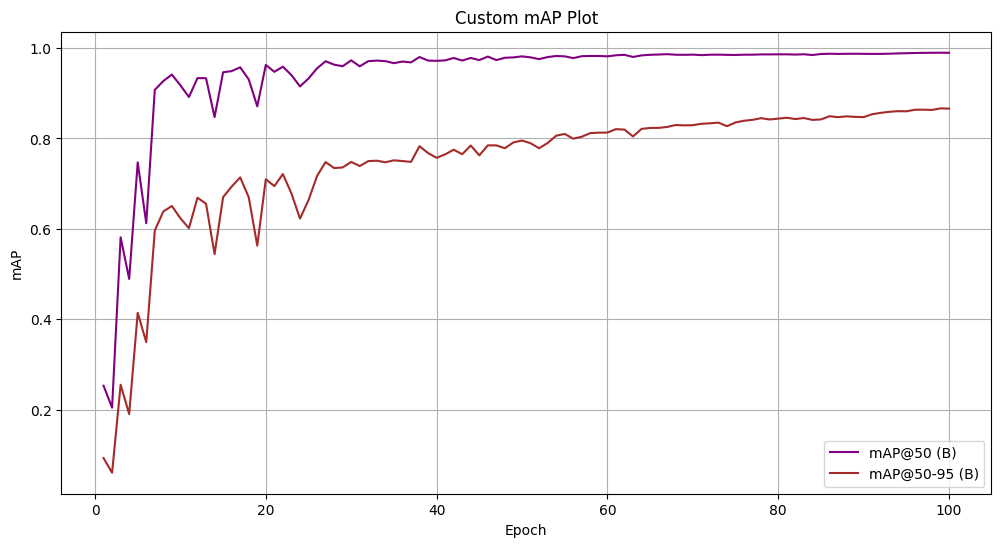

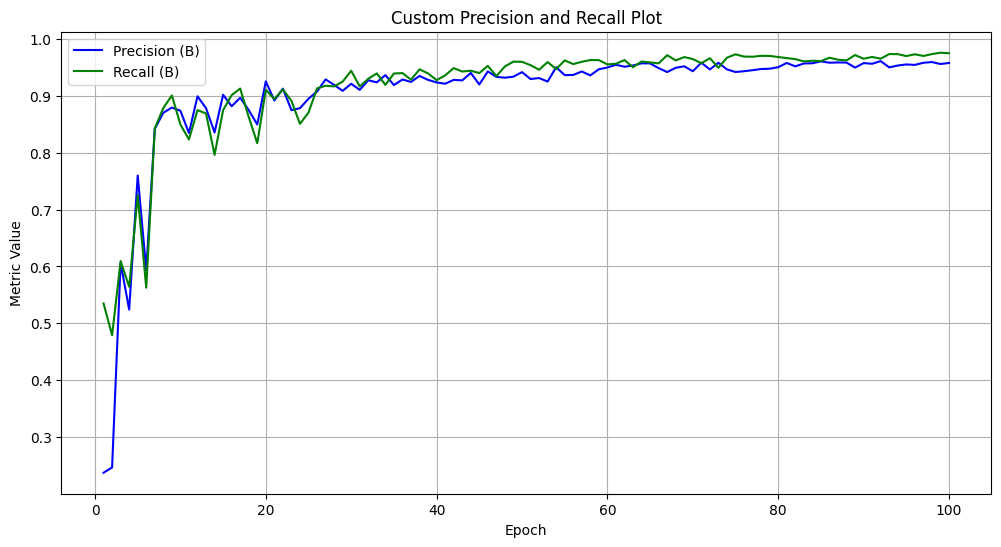

In [ ]:
plot_map_metrics(data, title="Custom mAP Plot")
plot_precision_recall(data, title="Custom Precision and Recall Plot")

##Descarga del modelo k

In [ ]:
# # Ruta de la carpeta a comprimir
# train_folder_path = "./runs/pose/train6"

# # Ruta donde guardar el archivo comprimido
# output_zip_path = "./train6_backup.zip"

# # Comprimir la carpeta
# shutil.make_archive(output_zip_path.replace('.zip', ''), 'zip', train_folder_path)

# print(f"Copia de seguridad creada: {output_zip_path}")

##Inferencia de keypoints


0: 256x320 1 dog, 103.7ms
Speed: 3.6ms preprocess, 103.7ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)


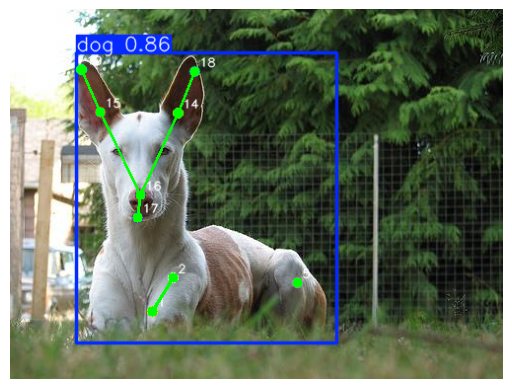

Keypoints detectados (x, y):
0: (x: 0.00, y: 0.00)
1: (x: 144.15, y: 306.89)
2: (x: 165.36, y: 272.65)
3: (x: 0.00, y: 0.00)
4: (x: 0.00, y: 0.00)
5: (x: 291.76, y: 277.60)
6: (x: 0.00, y: 0.00)
7: (x: 0.00, y: 0.00)
8: (x: 0.00, y: 0.00)
9: (x: 0.00, y: 0.00)
10: (x: 0.00, y: 0.00)
11: (x: 0.00, y: 0.00)
12: (x: 0.00, y: 0.00)
13: (x: 0.00, y: 0.00)
14: (x: 170.83, y: 105.33)
15: (x: 91.86, y: 104.12)
16: (x: 132.56, y: 188.02)
17: (x: 129.26, y: 211.71)
18: (x: 187.02, y: 63.50)
19: (x: 72.60, y: 61.23)
20: (x: 0.00, y: 0.00)
21: (x: 0.00, y: 0.00)
22: (x: 0.00, y: 0.00)
23: (x: 0.00, y: 0.00)


In [ ]:
predict_random_image(model_best,"./datasets/dog-pose/val/images")

Nota: se observa que para todas las muestras los keypoints del 20 al 23 tienen coordenadas nulas, por lo que se decide eliminarlas.

##Etiquetado de clases de pose

In [ ]:
# # Ruta del dataset
# images_path = "./datasets/dog-pose/train/images"

# # Cargar etiquetas existentes, si las hay
# output_labels = {}
# if os.path.exists('labels5.json'):
#     with open('labels5.json', 'r') as f:
#         output_labels = json.load(f)

# # Crear una lista de imágenes
# image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png'))]

# # Obtener el índice inicial basado en imágenes etiquetadas
# current_index = len(output_labels)

# # Obtener el índice inicial basado en imágenes ya etiquetadas
# labeled_images = set(output_labels.keys())  # Imágenes ya etiquetadas
# current_index = 0
# for i, img_name in enumerate(image_files):
#     if img_name not in labeled_images:
#         current_index = i
#         break

# # Iniciar etiquetado desde el índice actual
# #label_current_image()
# label_current_image_with_keypoints(model_best,images_path)

In [ ]:
# # Guardar etiquetas en un archivo JSON
# with open("labels5.json", "w") as f:
#     json.dump(output_labels, f)

# # Imprimir el largo del JSON (cantidad de elementos)
# print("Etiquetas guardadas en labels5.json")
# print(f"Largo del JSON: {len(output_labels)}")

# # Contar la frecuencia de cada clase directamente sobre output_labels
# class_counts = Counter(output_labels.values())

# # Imprimir el conteo de valores por clase
# print("Conteo de valores por clase:")
# for label, count in class_counts.items():
#     print(f"{label}: {count}")

##Armado del dataset para entrenamiento de pose

In [ ]:
# labels_file = 'labels5.json'
# # Cargar etiquetas desde el archivo JSON
# if os.path.exists(labels_file):
#     with open(labels_file, 'r') as f:
#         labels_data = json.load(f)
# else:
#     raise FileNotFoundError(f"El archivo {labels_file} no existe.")

In [ ]:
# # Lista de índices de keypoints que deseas usar
keypoints_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

# keypoints_to_labels_with_balance(
#     model=model_best,
#     images_path="./datasets/dog-pose/train/images",
#     labels_data=labels_data,
#     output_file="keypoints_labels.npy",
#     balance_option=2,
#     keypoints_list=keypoints_list
# )

In [ ]:
# # Cargar los datos del archivo .npy
# dataset = np.load('keypoints_labels.npy', allow_pickle=True)

# # Extraer las etiquetas (segundo elemento de cada fila)
# labels = [row[1] for row in dataset]

# # Contar la frecuencia de cada clase
# class_counts = Counter(labels)

# # Mostrar el conteo
# print("Conteo de datos por clase:")
# for label, count in class_counts.items():
#     print(f"Clase {label}: {count}")

##Entrenamiento del modelo p

In [ ]:
# # Separar las coordenadas x, y y aplanarlas
# coordinates = np.array([np.array(row[2]).flatten() for row in dataset])
# labels = np.array([row[1] for row in dataset])

# # Preprocesar los datos, se convierten las etiquetas en una matriz de one-hot
# X = coordinates
# y = to_categorical(labels, num_classes=3)

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# # Dividir en train y test de manera balanceada
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=labels
# )

# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=10,
#     verbose=1
# )

# # Configurar el callback de Early Stopping
# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Monitorea la pérdida en los datos de validación
#     patience=10,         # Número de épocas sin mejora antes de detener el entrenamiento
#     restore_best_weights=True,  # Restaura los pesos del modelo en la mejor época
#     verbose=1            # Muestra información en consola
# )

In [ ]:
# # Definir el modelo
# model_p = Sequential([
#     Dense(256, activation='relu', input_shape=(2*len(keypoints_list),)),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(128, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(64, activation='relu'),
#     Dropout(0.5),
#     Dense(3, activation='softmax')
# ])

# # Compilar el modelo con F1 como métrica
# model_p.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_score])

# # Entrenar el modelo con los datos de entrenamiento, separando un 20% de ellos para validación
# history_p = model_p.fit(
#     X_train, y_train,
#     epochs=150,
#     batch_size=64,
#     validation_split=0.2,
#     callbacks=[early_stopping]
# )

# # Guardar el modelo en un archivo .h5
# model_p.save('model_p.h5')
# print("Modelo guardado en 'model_p.h5'.")

# # Evaluar el modelo
# test_loss, test_f1 = model_p.evaluate(X_test, y_test)
# print(f"F1-score en datos de prueba: {test_f1:.2f}")

# # Guardar el scaler en un archivo
# joblib.dump(scaler, "scaler.pkl")
# print("Scaler exportado a scaler.pkl")

# # Imprimir gráfico con valores de F1 durante el entrenamiento
# plt.title('F1 Score vs Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('F1 Score')
# plt.plot(history_p.history['f1_score'], label='train F1')
# plt.plot(history_p.history['val_f1_score'], label='validation F1')
# plt.legend()
# plt.show()

##Matriz de confusión del modelo p

In [ ]:
# # Cargar el modelo
# model_p = load_model("model_p.h5")

# # Predicciones y etiquetas verdaderas
# y_pred = model_p.predict(X_test).argmax(axis=1)
# y_true = y_test.argmax(axis=1)

# # Crear la matriz de confusión
# cm = confusion_matrix(y_true, y_pred)

# # Definir las etiquetas de las clases
# class_labels = ["Tumbado", "Sentado", "Parado"]

# # Mostrar la matriz de confusión con etiquetas personalizadas
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
# disp.plot(cmap="Blues")  # Puedes cambiar el colormap si lo deseas

##Reducción de keypoints para entrenamiento de pose

In [ ]:
lesskeypoints_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17]

# keypoints_to_labels_with_balance(
#     model=model_best,
#     images_path="./datasets/dog-pose/train/images",
#     labels_data=labels_data,
#     output_file="lesskeypoints_labels.npy",
#     balance_option=2,
#     keypoints_list=lesskeypoints_list
# )

In [ ]:
# Cargar los datos del archivo .npy
dataset = np.load('lesskeypoints_labels.npy', allow_pickle=True)

# Extraer las etiquetas (segundo elemento de cada fila)
labels = [row[1] for row in dataset]

# Contar la frecuencia de cada clase
class_counts = Counter(labels)

# Mostrar el conteo
print("Conteo de datos por clase:")
for label, count in class_counts.items():
    print(f"Clase {label}: {count}")

Conteo de datos por clase:
Clase 0: 339
Clase 1: 339
Clase 2: 339


##Entrenamiento del modelo p con lesskeypoints_list

In [ ]:
# Separar las coordenadas x, y y aplanarlas
coordinates = np.array([np.array(row[2]).flatten() for row in dataset])
labels = np.array([row[1] for row in dataset])

# Preprocesar los datos, se convierten las etiquetas en una matriz de one-hot
X = coordinates
y = to_categorical(labels, num_classes=3)

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir en train y test de manera balanceada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=labels
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

# Configurar el callback de Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida en los datos de validación
    patience=10,         # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True,  # Restaura los pesos del modelo en la mejor época
    verbose=1            # Muestra información en consola
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - f1_score: 0.3600 - loss: 1.7850 - val_f1_score: 0.0767 - val_loss: 1.0113
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - f1_score: 0.4409 - loss: 1.5159 - val_f1_score: 0.1315 - val_loss: 0.9434
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score: 0.4544 - loss: 1.3816 - val_f1_score: 0.2588 - val_loss: 0.8882
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - f1_score: 0.4720 - loss: 1.2414 - val_f1_score: 0.3646 - val_loss: 0.8520
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.5641 - loss: 1.0851 - val_f1_score: 0.4380 - val_loss: 0.8189
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.5724 - loss: 0.9926 - val_f1_score: 0.5083 - val_loss: 0.7829
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - f1_score: 0.5757 - loss: 1.0295 - val_f1_score: 0.5904 - val_loss: 0.7486
Epoch 8/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - f1_score: 0.6590 - loss: 0.8400 - val_f1_score: 0.6242

Modelo guardado en 'model_pless.h5'.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.9114 - loss: 0.3099 
F1-score en datos de prueba: 0.90
Scaler exportado a scaler.pkl


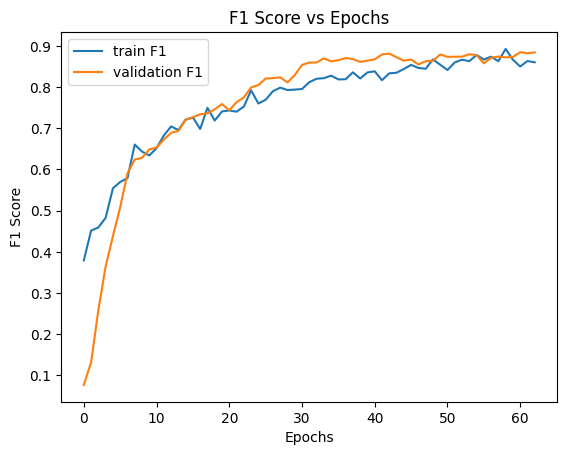

In [ ]:
# Definir el modelo
model_pless = Sequential([
    Dense(256, activation='relu', input_shape=(2*len(lesskeypoints_list),)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compilar el modelo con F1 como métrica
model_pless.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_score])

# Entrenar el modelo con los datos de entrenamiento, separando un 20% de ellos para validación
history_pless = model_pless.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Guardar el modelo en un archivo .h5
model_pless.save('model_pless.h5')
print("Modelo guardado en 'model_pless.h5'.")

# Evaluar el modelo
test_loss, test_f1 = model_pless.evaluate(X_test, y_test)
print(f"F1-score en datos de prueba: {test_f1:.2f}")

# Guardar el scaler en un archivo
joblib.dump(scaler, "scaler.pkl")
print("Scaler exportado a scaler.pkl")

# Imprimir gráfico con valores de F1 durante el entrenamiento
plt.title('F1 Score vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.plot(history_pless.history['f1_score'], label='train F1')
plt.plot(history_pless.history['val_f1_score'], label='validation F1')
plt.legend()
plt.show()

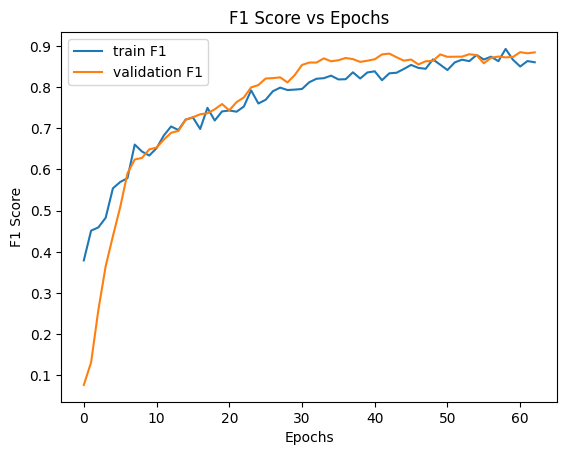

##Matriz de confusión del modelo p con lesskeypoints

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


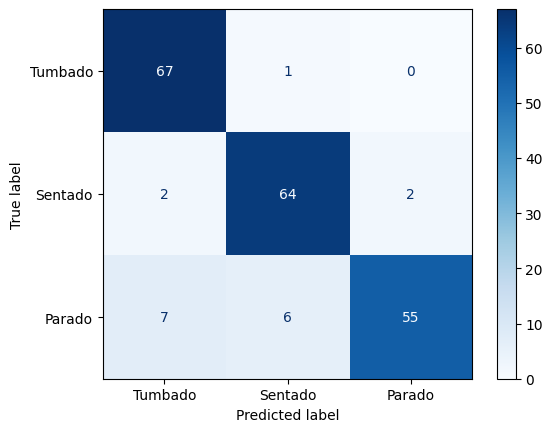

In [ ]:
# Cargar el modelo
model_pless = load_model("model_pless.h5")

# Predicciones y etiquetas verdaderas
y_pred = model_pless.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Definir las etiquetas de las clases
class_labels = ["Tumbado", "Sentado", "Parado"]

# Mostrar la matriz de confusión con etiquetas personalizadas
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Blues")  # Puedes cambiar el colormap si lo deseas

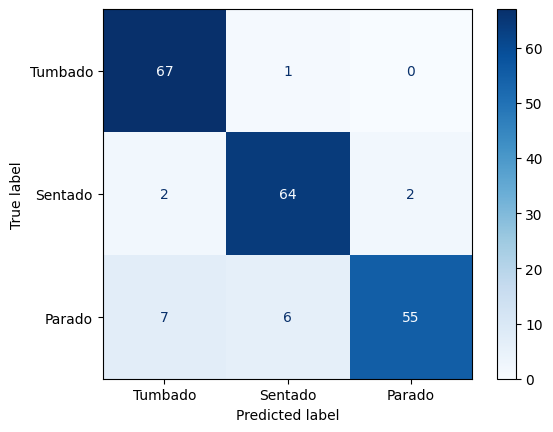

##Reetiquetado de clases

In [ ]:
# json_path = "labels5.json"
images_path = "./datasets/dog-pose/train/images"
# target_class = "Sentado"
# relabel_image_with_keypoints(target_class, json_path, images_path, model_best)

In [ ]:
# # Guardar etiquetas en un archivo JSON
# with open("labels5.json", "w") as f:
#     json.dump(output_labels, f)

# # Imprimir el largo del JSON (cantidad de elementos)
# print("Etiquetas guardadas en labels5.json")
# print(f"Largo del JSON: {len(output_labels)}")

# # Contar la frecuencia de cada clase directamente sobre output_labels
# class_counts = Counter(output_labels.values())

# # Imprimir el conteo de valores por clase
# print("Conteo de valores por clase:")
# for label, count in class_counts.items():
#     print(f"{label}: {count}")

##Etiquetado automático labels_auto99

In [ ]:
# auto_label_images(
#     model_k=model_best,
#     model_p=model_pless,
#     scaler=scaler,
#     images_path=images_path,
#     lesskeypoints_list=lesskeypoints_list,
#     output_json="labels6.json",
#     threshold=0.99
#     #num_images=1000
# )

##Entrenamiento de modelo pless con labels_auto99.json

In [ ]:
def keypoints_to_labels_with_balance(model, images_path, labels_data, output_file, balance_option=1, keypoints_list=None):
    """
    Procesa imágenes y etiquetas para generar un archivo .npy balanceado que contenga IDs, etiquetas y keypoints.

    Argumentos:
        model: Modelo YOLO cargado previamente.
        images_path: Ruta de la carpeta que contiene las imágenes.
        labels_data: Diccionario de etiquetas cargado desde labels.json.
        output_file: Nombre del archivo .npy donde se guardarán los resultados.
        balance_option: 1 para submuestreo, 2 para sobremuestreo con aumentación.
        keypoints_list: Lista de índices de keypoints que se desean utilizar (opcional).
    """
    # Mapeo de etiquetas a valores numéricos
    label_mapping = {
        "tumbado": 0,
        "sentado": 1,
        "parado": 2
    }

    # Diccionario para almacenar los datos por clase
    data_by_class = {0: [], 1: [], 2: []}

    # Procesar imágenes y obtener keypoints
    for image_name, label_text in tqdm(labels_data.items(), desc="Procesando imágenes", unit="imagen"):
        # Convertir la etiqueta de texto a su valor numérico
        label = label_mapping.get(label_text.lower(), -1)
        if label == -1:
            print(f"Etiqueta '{label_text}' no válida para la imagen {image_name}. Omitiendo.")
            continue

        # Ruta de la imagen
        image_path = os.path.join(images_path, image_name)

        # Verificar si la imagen existe
        if not os.path.exists(image_path):
            print(f"La imagen {image_name} no se encuentra en la ruta especificada. Omitiendo.")
            continue

        # Cargar la imagen
        image = cv2.imread(image_path)

        # Realizar la predicción
        results = model(image)

        # Obtener keypoints de la predicción
        keypoints = []
        if hasattr(results[0], "keypoints") and results[0].keypoints is not None:
            keypoints_data = results[0].keypoints.data.cpu().numpy()
            for row in keypoints_data[0]:
                keypoints.append((float(row[0]), float(row[1])))

        if not keypoints:
            print(f"No se encontraron keypoints para la imagen {image_name}. Omitiendo.")
            continue

        # Filtrar keypoints según la lista proporcionada
        if keypoints_list is not None:
            keypoints = [keypoints[i] for i in keypoints_list if i < len(keypoints)]

        # Agregar los datos a la clase correspondiente
        data_by_class[label].append([label, keypoints])

    # Balancear las clases
    balanced_data = []
    if balance_option == 1:  # Submuestreo
        min_class_size = min(len(data) for data in data_by_class.values())
        print(f"Balanceando al tamaño mínimo entre clases: {min_class_size}")
        for class_data in data_by_class.values():
            balanced_data.extend(random.sample(class_data, min_class_size))
    elif balance_option == 2:  # Sobremuestreo con aumentación
        max_class_size = max(len(data) for data in data_by_class.values())
        print(f"Balanceando al tamaño máximo entre clases: {max_class_size}")
        for label, class_data in data_by_class.items():
            while len(class_data) < max_class_size:
                original = random.choice(class_data)
                augmented_keypoints = augment_coordinates(
                    original[1],  # Keypoints
                    random.choice(["flip", "translate", "rotate", "scale"]),
                    params={
                        "tx": random.uniform(-10, 10),
                        "ty": random.uniform(-10, 10),
                        "angle": random.uniform(-30, 30),
                        "sx": random.uniform(0.8, 1.2),
                        "sy": random.uniform(0.8, 1.2)
                    }
                )
                class_data.append([label, augmented_keypoints])
            balanced_data.extend(class_data)
    else:
        raise ValueError("Opción no válida. Usa 1 para submuestreo o 2 para sobremuestreo.")

    # Agregar IDs a los datos balanceados y guardar
    data_with_ids = [[idx] + item for idx, item in enumerate(balanced_data)]
    np.save(output_file, np.array(data_with_ids, dtype=object))
    print(f"Datos balanceados y guardados exitosamente en {output_file}")


In [ ]:
labels_file = 'labels_auto99.json'
# Cargar etiquetas desde el archivo JSON
if os.path.exists(labels_file):
    with open(labels_file, 'r') as f:
        labels_data = json.load(f)
else:
    raise FileNotFoundError(f"El archivo {labels_file} no existe.")

In [ ]:
# keypoints_to_labels_with_balance(
#     model=model_best,
#     images_path="./datasets/dog-pose/train/images",
#     labels_data=labels_data,
#     output_file="lesskeypoints_labels_auto99.npy",
#     balance_option=2,
#     keypoints_list=lesskeypoints_list
# )

In [ ]:
# Cargar los datos del archivo .npy
dataset = np.load('lesskeypoints_labels_auto99.npy', allow_pickle=True)

# Extraer las etiquetas (segundo elemento de cada fila)
labels = [row[1] for row in dataset]

# Contar la frecuencia de cada clase
class_counts = Counter(labels)

# Mostrar el conteo
print("Conteo de datos por clase:")
for label, count in class_counts.items():
    print(f"Clase {label}: {count}")

Conteo de datos por clase:
Clase 0: 2100
Clase 1: 2100
Clase 2: 2100


In [ ]:
# Separar las coordenadas x, y y aplanarlas
coordinates = np.array([np.array(row[2]).flatten() for row in dataset])
labels = np.array([row[1] for row in dataset])

# Preprocesar los datos, se convierten las etiquetas en una matriz de one-hot
X = coordinates
y = to_categorical(labels, num_classes=3)

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir en train y test de manera balanceada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=labels
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

# Configurar el callback de Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida en los datos de validación
    patience=10,         # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True,  # Restaura los pesos del modelo en la mejor época
    verbose=1            # Muestra información en consola
)

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - f1_score: 0.4966 - loss: 1.3954 - val_f1_score: 0.8066 - val_loss: 0.5965
Epoch 2/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.7751 - loss: 0.5869 - val_f1_score: 0.8811 - val_loss: 0.3982
Epoch 3/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.8464 - loss: 0.4551 - val_f1_score: 0.9119 - val_loss: 0.2964
Epoch 4/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.8617 - loss: 0.3969 - val_f1_score: 0.9303 - val_loss: 0.2323
Epoch 5/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.8938 - loss: 0.3260 - val_f1_score: 0.9282 - val_loss: 0.1998
Epoch 6/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_score: 0.8988 - loss: 0.3173 - val_f1_score: 0.9424 - val_loss: 0.1759
Epoch 7/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_score: 0.9036 - loss: 0.2887 - val_f1_score: 0.9459 - val_loss: 0.1594
Epoch 8/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.9093 - loss: 0.2441 - val_f1_score: 0.9484 - val_loss: 0.1

Modelo guardado en 'model_pless.h5'.
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_score: 0.9742 - loss: 0.0601 
F1-score en datos de prueba: 0.97
Scaler exportado a scaler.pkl


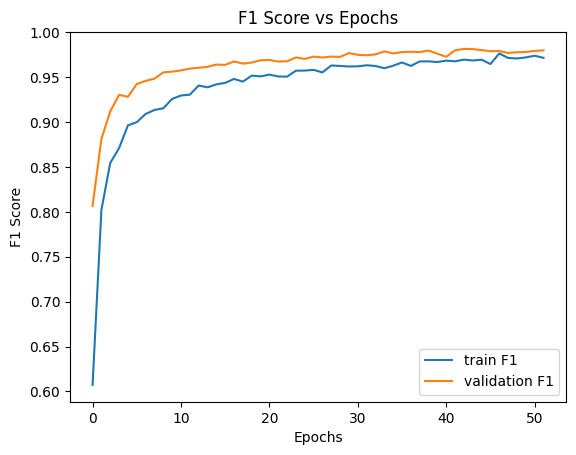

In [ ]:
# Definir el modelo
model_pless = Sequential([
    Dense(256, activation='relu', input_shape=(2*len(lesskeypoints_list),)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compilar el modelo con F1 como métrica
model_pless.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_score])

# Entrenar el modelo con los datos de entrenamiento, separando un 20% de ellos para validación
history_pless = model_pless.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Guardar el modelo en un archivo .h5
model_pless.save('model_pless.h5')
print("Modelo guardado en 'model_pless.h5'.")

# Evaluar el modelo
test_loss, test_f1 = model_pless.evaluate(X_test, y_test)
print(f"F1-score en datos de prueba: {test_f1:.2f}")

# Guardar el scaler en un archivo
joblib.dump(scaler, "scaler.pkl")
print("Scaler exportado a scaler.pkl")

# Imprimir gráfico con valores de F1 durante el entrenamiento
plt.title('F1 Score vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.plot(history_pless.history['f1_score'], label='train F1')
plt.plot(history_pless.history['val_f1_score'], label='validation F1')
plt.legend()
plt.show()

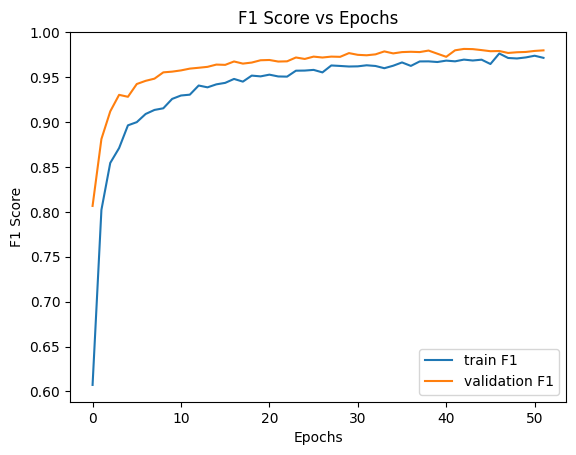

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


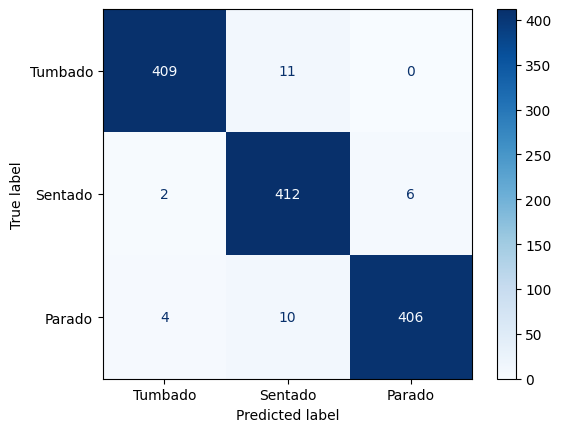

In [ ]:
# Cargar el modelo
model_pless = load_model("model_pless.h5")

# Predicciones y etiquetas verdaderas
y_pred = model_pless.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Definir las etiquetas de las clases
class_labels = ["Tumbado", "Sentado", "Parado"]

# Mostrar la matriz de confusión con etiquetas personalizadas
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Blues")  # Puedes cambiar el colormap si lo deseas

##Etiquetado automático labels_auto95

In [ ]:
# auto_label_images(
#     model_k=model_best,
#     model_p=model_pless,
#     scaler=scaler,
#     images_path=images_path,
#     lesskeypoints_list=lesskeypoints_list,
#     output_json="labels_auto95.json",
#     threshold=0.95
#     #num_images=1000
# )

##Entrenamiento de modelo pless con labels_auto95.json

In [ ]:
# labels_file = 'labels_auto95.json'
# # Cargar etiquetas desde el archivo JSON
# if os.path.exists(labels_file):
#     with open(labels_file, 'r') as f:
#         labels_data = json.load(f)
# else:
#     raise FileNotFoundError(f"El archivo {labels_file} no existe.")

In [ ]:
# keypoints_to_labels_with_balance(
#     model=model_best,
#     images_path="./datasets/dog-pose/train/images",
#     labels_data=labels_data,
#     output_file="lesskeypoints_labels_auto95.npy",
#     balance_option=2,
#     keypoints_list=lesskeypoints_list
# )

In [ ]:
# # Cargar los datos del archivo .npy
# dataset = np.load('lesskeypoints_labels_auto95.npy', allow_pickle=True)

# # Extraer las etiquetas (segundo elemento de cada fila)
# labels = [row[1] for row in dataset]

# # Contar la frecuencia de cada clase
# class_counts = Counter(labels)

# # Mostrar el conteo
# print("Conteo de datos por clase:")
# for label, count in class_counts.items():
#     print(f"Clase {label}: {count}")

In [ ]:
# # Separar las coordenadas x, y y aplanarlas
# coordinates = np.array([np.array(row[2]).flatten() for row in dataset])
# labels = np.array([row[1] for row in dataset])

# # Preprocesar los datos, se convierten las etiquetas en una matriz de one-hot
# X = coordinates
# y = to_categorical(labels, num_classes=3)

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# # Dividir en train y test de manera balanceada
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=labels
# )

# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=5,
#     verbose=1
# )

# # Configurar el callback de Early Stopping
# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Monitorea la pérdida en los datos de validación
#     patience=10,         # Número de épocas sin mejora antes de detener el entrenamiento
#     restore_best_weights=True,  # Restaura los pesos del modelo en la mejor época
#     verbose=1            # Muestra información en consola
# )

In [ ]:
# # Definir el modelo
# model_pless = Sequential([
#     Dense(256, activation='relu', input_shape=(2*len(lesskeypoints_list),)),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(128, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(64, activation='relu'),
#     Dropout(0.5),
#     Dense(3, activation='softmax')
# ])

# # Compilar el modelo con F1 como métrica
# model_pless.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_score])

# # Entrenar el modelo con los datos de entrenamiento, separando un 20% de ellos para validación
# history_pless = model_pless.fit(
#     X_train, y_train,
#     epochs=150,
#     batch_size=64,
#     validation_split=0.2,
#     callbacks=[early_stopping]
# )

# # Guardar el modelo en un archivo .h5
# model_pless.save('model_pless.h5')
# print("Modelo guardado en 'model_pless.h5'.")

# # Evaluar el modelo
# test_loss, test_f1 = model_pless.evaluate(X_test, y_test)
# print(f"F1-score en datos de prueba: {test_f1:.2f}")

# # Guardar el scaler en un archivo
# joblib.dump(scaler, "scaler.pkl")
# print("Scaler exportado a scaler.pkl")

# # Imprimir gráfico con valores de F1 durante el entrenamiento
# plt.title('F1 Score vs Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('F1 Score')
# plt.plot(history_pless.history['f1_score'], label='train F1')
# plt.plot(history_pless.history['val_f1_score'], label='validation F1')
# plt.legend()
# plt.show()

In [ ]:
# # Cargar el modelo
# model_pless = load_model("model_pless.h5")

# # Predicciones y etiquetas verdaderas
# y_pred = model_pless.predict(X_test).argmax(axis=1)
# y_true = y_test.argmax(axis=1)

# # Crear la matriz de confusión
# cm = confusion_matrix(y_true, y_pred)

# # Definir las etiquetas de las clases
# class_labels = ["Tumbado", "Sentado", "Parado"]

# # Mostrar la matriz de confusión con etiquetas personalizadas
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
# disp.plot(cmap="Blues")  # Puedes cambiar el colormap si lo deseas

##Inferencia de pose


0: 256x320 1 dog, 71.5ms
Speed: 1.6ms preprocess, 71.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


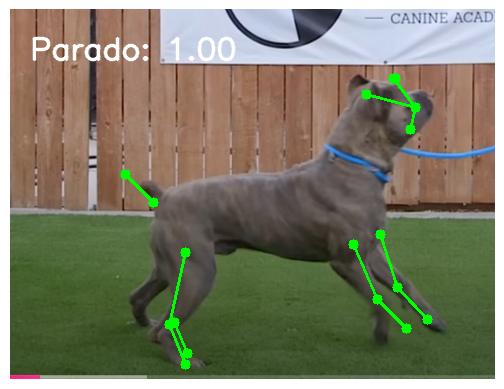

Clase predicha: Parado
Probabilidades: [ 1.8495e-07  1.5137e-05     0.99998]
Clase predicha: Parado


In [ ]:
image_path="./test"

coordinates_example, predicted_class_label = predict_pose(model_best, model_pless, scaler, image_path,lesskeypoints_list)
print("Clase predicha:", predicted_class_label)


0: 224x320 1 dog, 53.0ms
Speed: 1.4ms preprocess, 53.0ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


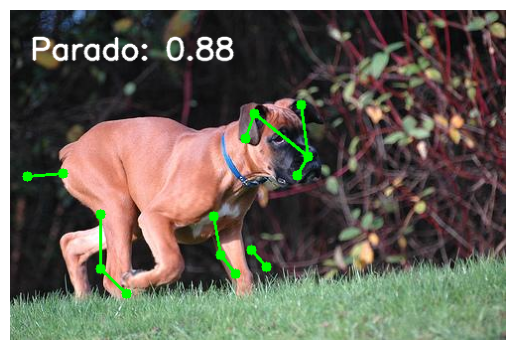

Clase predicha: Parado
Probabilidades: [    0.11793    0.006207     0.87586]
Clase predicha: Parado


In [ ]:
image_path="./datasets/dog-pose/val/images"

coordinates_example, predicted_class_label = predict_pose(model_best, model_pless, scaler, image_path,lesskeypoints_list)
print("Clase predicha:", predicted_class_label)

Procesando imágenes:   0%|          | 0/1703 [00:00<?, ?it/s]


0: 256x320 1 dog, 231.6ms
Speed: 2.0ms preprocess, 231.6ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Procesando imágenes:   0%|          | 1/1703 [00:00<16:10,  1.75it/s]

Etiqueta no encontrada para la imagen n02108422_5432.jpg. Saltando...

0: 256x320 1 dog, 403.7ms
Speed: 10.6ms preprocess, 403.7ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Procesando imágenes:   0%|          | 3/1703 [00:01<13:13,  2.14it/s]

Etiqueta no encontrada para la imagen n02110806_518.jpg. Saltando...

0: 320x224 1 dog, 378.7ms
Speed: 4.3ms preprocess, 378.7ms inference, 10.9ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Procesando imágenes:   0%|          | 5/1703 [00:02<11:39,  2.43it/s]


0: 320x224 1 dog, 239.2ms
Speed: 1.5ms preprocess, 239.2ms inference, 6.9ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Procesando imágenes:   0%|          | 6/1703 [00:02<13:31,  2.09it/s]


0: 224x320 1 dog, 278.7ms
Speed: 1.4ms preprocess, 278.7ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Procesando imágenes:   0%|          | 7/1703 [00:03<16:37,  1.70it/s]


0: 256x320 1 dog, 258.1ms
Speed: 1.5ms preprocess, 258.1ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Procesando imágenes:   0%|          | 8/1703 [00:04<17:12,  1.64it/s]


0: 320x256 1 dog, 129.8ms
Speed: 1.5ms preprocess, 129.8ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:   1%|          | 9/1703 [00:04<15:31,  1.82it/s]


0: 320x320 1 dog, 173.5ms
Speed: 5.5ms preprocess, 173.5ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:   1%|          | 10/1703 [00:05<13:36,  2.07it/s]


0: 224x320 1 dog, 153.1ms
Speed: 1.5ms preprocess, 153.1ms inference, 6.9ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:   1%|          | 11/1703 [00:05<13:08,  2.14it/s]


0: 320x320 1 dog, 121.0ms
Speed: 1.4ms preprocess, 121.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:   1%|          | 12/1703 [00:05<11:37,  2.43it/s]

Etiqueta no encontrada para la imagen n02087046_2127.jpg. Saltando...

0: 320x256 1 dog, 125.7ms
Speed: 1.4ms preprocess, 125.7ms inference, 4.9ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Procesando imágenes:   1%|          | 14/1703 [00:06<08:16,  3.40it/s]

Etiqueta no encontrada para la imagen n02095570_2972.jpg. Saltando...

0: 256x320 1 dog, 87.8ms
Speed: 1.4ms preprocess, 87.8ms inference, 8.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Procesando imágenes:   1%|          | 16/1703 [00:06<06:32,  4.30it/s]


0: 288x320 1 dog, 102.2ms
Speed: 5.3ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:   1%|          | 17/1703 [00:06<06:35,  4.26it/s]

Etiqueta no encontrada para la imagen n02110063_11052.jpg. Saltando...

0: 256x320 1 dog, 92.1ms
Speed: 3.3ms preprocess, 92.1ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:   1%|          | 19/1703 [00:06<05:25,  5.17it/s]

Etiqueta no encontrada para la imagen n02096585_11417.jpg. Saltando...
Etiqueta no encontrada para la imagen n02090379_2083.jpg. Saltando...
Etiqueta no encontrada para la imagen n02097209_3823.jpg. Saltando...
Etiqueta no encontrada para la imagen n02095570_510.jpg. Saltando...
Etiqueta no encontrada para la imagen n02095889_4649.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102177_2611.jpg. Saltando...
Etiqueta no encontrada para la imagen n02090721_873.jpg. Saltando...

0: 224x320 1 dog, 92.8ms
Speed: 2.5ms preprocess, 92.8ms inference, 3.9ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Procesando imágenes:   2%|▏         | 27/1703 [00:07<02:24, 11.58it/s]

Etiqueta no encontrada para la imagen n02102480_6027.jpg. Saltando...

0: 224x320 1 dog, 130.9ms
Speed: 3.7ms preprocess, 130.9ms inference, 4.3ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Procesando imágenes:   2%|▏         | 29/1703 [00:07<02:46, 10.05it/s]

Etiqueta no encontrada para la imagen n02091032_10435.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096437_3655.jpg. Saltando...

0: 320x224 1 dog, 165.6ms
Speed: 1.4ms preprocess, 165.6ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Procesando imágenes:   2%|▏         | 32/1703 [00:07<03:15,  8.57it/s]


0: 320x256 1 dog, 220.3ms
Speed: 1.6ms preprocess, 220.3ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Procesando imágenes:   2%|▏         | 33/1703 [00:08<04:24,  6.32it/s]


0: 320x256 1 dog, 315.0ms
Speed: 1.5ms preprocess, 315.0ms inference, 12.8ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Procesando imágenes:   2%|▏         | 34/1703 [00:08<05:52,  4.73it/s]


0: 320x320 1 dog, 217.5ms
Speed: 1.4ms preprocess, 217.5ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Procesando imágenes:   2%|▏         | 35/1703 [00:09<07:07,  3.90it/s]


0: 224x320 1 dog, 277.6ms
Speed: 1.3ms preprocess, 277.6ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Procesando imágenes:   2%|▏         | 36/1703 [00:09<08:08,  3.41it/s]

Etiqueta no encontrada para la imagen n02099849_3383.jpg. Saltando...

0: 256x320 1 dog, 241.8ms
Speed: 1.3ms preprocess, 241.8ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Procesando imágenes:   2%|▏         | 38/1703 [00:10<07:44,  3.58it/s]

Etiqueta no encontrada para la imagen n02093647_2326.jpg. Saltando...
Etiqueta no encontrada para la imagen n02099712_1150.jpg. Saltando...
Etiqueta no encontrada para la imagen n02091831_13774.jpg. Saltando...
Etiqueta no encontrada para la imagen n02094114_4158.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107908_5662.jpg. Saltando...

0: 224x320 1 dog, 109.5ms
Speed: 6.7ms preprocess, 109.5ms inference, 1.8ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:   3%|▎         | 44/1703 [00:10<03:49,  7.23it/s]


0: 320x320 1 dog, 195.7ms
Speed: 1.6ms preprocess, 195.7ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:   3%|▎         | 45/1703 [00:10<04:41,  5.89it/s]

Etiqueta no encontrada para la imagen n02104365_6498.jpg. Saltando...

0: 256x320 1 dog, 56.3ms
Speed: 3.7ms preprocess, 56.3ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Procesando imágenes:   3%|▎         | 47/1703 [00:11<03:57,  6.97it/s]

Etiqueta no encontrada para la imagen n02087394_9686.jpg. Saltando...
Etiqueta no encontrada para la imagen n02094258_1460.jpg. Saltando...

0: 224x320 1 dog, 50.4ms
Speed: 2.1ms preprocess, 50.4ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:   3%|▎         | 50/1703 [00:11<03:05,  8.91it/s]


0: 256x320 1 dog, 67.4ms
Speed: 3.1ms preprocess, 67.4ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:   3%|▎         | 52/1703 [00:11<04:33,  6.03it/s]

Etiqueta no encontrada para la imagen n02098105_1583.jpg. Saltando...

0: 256x320 1 dog, 59.9ms
Speed: 1.5ms preprocess, 59.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:   3%|▎         | 53/1703 [00:12<04:32,  6.05it/s]

Etiqueta no encontrada para la imagen n02099712_5017.jpg. Saltando...

0: 256x320 1 dog, 58.3ms
Speed: 1.6ms preprocess, 58.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Procesando imágenes:   3%|▎         | 55/1703 [00:12<03:53,  7.06it/s]


0: 288x320 1 dog, 68.2ms
Speed: 1.5ms preprocess, 68.2ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:   3%|▎         | 56/1703 [00:12<04:05,  6.71it/s]


0: 256x320 1 dog, 58.9ms
Speed: 1.5ms preprocess, 58.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:   3%|▎         | 57/1703 [00:12<04:07,  6.66it/s]

Etiqueta no encontrada para la imagen n02093754_4213.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096051_3660.jpg. Saltando...

0: 256x320 1 dog, 56.3ms
Speed: 3.6ms preprocess, 56.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:   4%|▎         | 60/1703 [00:12<02:55,  9.38it/s]


0: 256x320 1 dog, 68.6ms
Speed: 2.0ms preprocess, 68.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

0: 320x288 1 dog, 67.9ms
Speed: 3.1ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:   4%|▎         | 62/1703 [00:13<03:27,  7.91it/s]

Etiqueta no encontrada para la imagen n02088466_1555.jpg. Saltando...

0: 256x320 1 dog, 58.1ms
Speed: 2.5ms preprocess, 58.1ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Procesando imágenes:   4%|▍         | 64/1703 [00:13<03:09,  8.66it/s]


0: 224x320 1 dog, 75.8ms
Speed: 3.7ms preprocess, 75.8ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:   4%|▍         | 65/1703 [00:13<03:30,  7.76it/s]


0: 256x320 1 dog, 60.8ms
Speed: 3.5ms preprocess, 60.8ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:   4%|▍         | 66/1703 [00:13<03:40,  7.43it/s]


0: 256x320 1 dog, 61.5ms
Speed: 3.9ms preprocess, 61.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:   4%|▍         | 67/1703 [00:13<03:51,  7.07it/s]

Etiqueta no encontrada para la imagen n02093754_4332.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096585_904.jpg. Saltando...

0: 224x320 1 dog, 54.3ms
Speed: 1.4ms preprocess, 54.3ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:   4%|▍         | 70/1703 [00:14<02:42, 10.04it/s]


0: 320x224 1 dog, 60.5ms
Speed: 1.4ms preprocess, 60.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:   4%|▍         | 72/1703 [00:14<02:30, 10.81it/s]

Etiqueta no encontrada para la imagen n02102480_5651.jpg. Saltando...

0: 320x224 1 dog, 52.5ms
Speed: 2.8ms preprocess, 52.5ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

0: 256x320 1 dog, 79.7ms
Speed: 4.2ms preprocess, 79.7ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Procesando imágenes:   4%|▍         | 74/1703 [00:14<03:26,  7.89it/s]


0: 256x320 1 dog, 93.0ms
Speed: 1.5ms preprocess, 93.0ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:   4%|▍         | 75/1703 [00:14<03:56,  6.89it/s]

Etiqueta no encontrada para la imagen n02111500_2018.jpg. Saltando...
Etiqueta no encontrada para la imagen n02091467_4427.jpg. Saltando...

0: 288x320 1 dog, 103.8ms
Speed: 1.5ms preprocess, 103.8ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:   5%|▍         | 78/1703 [00:15<03:08,  8.62it/s]

Etiqueta no encontrada para la imagen n02107574_581.jpg. Saltando...

0: 320x256 1 dog, 102.5ms
Speed: 1.5ms preprocess, 102.5ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Procesando imágenes:   5%|▍         | 80/1703 [00:15<03:18,  8.17it/s]

Etiqueta no encontrada para la imagen n02110627_2748.jpg. Saltando...

0: 256x320 1 dog, 117.4ms
Speed: 1.5ms preprocess, 117.4ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Procesando imágenes:   5%|▍         | 82/1703 [00:15<03:17,  8.20it/s]


0: 320x224 1 dog, 83.4ms
Speed: 1.4ms preprocess, 83.4ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:   5%|▍         | 83/1703 [00:15<03:42,  7.29it/s]


0: 192x320 1 dog, 68.0ms
Speed: 1.2ms preprocess, 68.0ms inference, 1.4ms postprocess per image at shape (1, 3, 192, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:   5%|▍         | 84/1703 [00:15<03:56,  6.84it/s]


0: 320x320 1 dog, 117.9ms
Speed: 1.8ms preprocess, 117.9ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Procesando imágenes:   5%|▍         | 85/1703 [00:16<04:37,  5.83it/s]

Etiqueta no encontrada para la imagen n02099267_3044.jpg. Saltando...

0: 256x320 1 dog, 116.3ms
Speed: 4.3ms preprocess, 116.3ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:   5%|▌         | 87/1703 [00:16<04:10,  6.44it/s]


0: 256x320 1 dog, 93.9ms
Speed: 1.9ms preprocess, 93.9ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Procesando imágenes:   5%|▌         | 88/1703 [00:16<05:10,  5.21it/s]


0: 320x256 1 dog, 103.5ms
Speed: 1.5ms preprocess, 103.5ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:   5%|▌         | 89/1703 [00:17<05:32,  4.86it/s]

Etiqueta no encontrada para la imagen n02105641_10188.jpg. Saltando...

0: 288x320 1 dog, 110.7ms
Speed: 1.5ms preprocess, 110.7ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:   5%|▌         | 91/1703 [00:17<04:41,  5.73it/s]


0: 224x320 1 dog, 87.5ms
Speed: 1.9ms preprocess, 87.5ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:   5%|▌         | 92/1703 [00:17<04:57,  5.42it/s]


0: 224x320 1 dog, 91.6ms
Speed: 2.9ms preprocess, 91.6ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:   5%|▌         | 93/1703 [00:17<05:09,  5.20it/s]


0: 320x320 1 dog, 129.6ms
Speed: 1.4ms preprocess, 129.6ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:   6%|▌         | 94/1703 [00:17<05:40,  4.72it/s]

Etiqueta no encontrada para la imagen n02104365_8334.jpg. Saltando...

0: 224x320 1 dog, 91.8ms
Speed: 1.2ms preprocess, 91.8ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:   6%|▌         | 96/1703 [00:18<04:34,  5.86it/s]


0: 256x320 1 dog, 88.8ms
Speed: 1.5ms preprocess, 88.8ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:   6%|▌         | 97/1703 [00:18<04:50,  5.54it/s]

Etiqueta no encontrada para la imagen n02107574_1390.jpg. Saltando...
Etiqueta no encontrada para la imagen n02088094_13011.jpg. Saltando...
Etiqueta no encontrada para la imagen n02105162_957.jpg. Saltando...

0: 256x320 2 dogs, 79.4ms
Speed: 1.6ms preprocess, 79.4ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:   6%|▌         | 101/1703 [00:18<02:45,  9.67it/s]

Etiqueta no encontrada para la imagen n02108000_877.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107574_2662.jpg. Saltando...
Etiqueta no encontrada para la imagen n02091032_5134.jpg. Saltando...

0: 288x320 1 dog, 63.3ms
Speed: 3.9ms preprocess, 63.3ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:   6%|▌         | 105/1703 [00:18<02:00, 13.25it/s]

Etiqueta no encontrada para la imagen n02088466_9167.jpg. Saltando...

0: 224x320 2 dogs, 55.4ms
Speed: 1.3ms preprocess, 55.4ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:   6%|▋         | 107/1703 [00:18<02:01, 13.11it/s]

Etiqueta no encontrada para la imagen n02092339_4410.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107683_3931.jpg. Saltando...

0: 320x320 1 dog, 75.7ms
Speed: 1.4ms preprocess, 75.7ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:   6%|▋         | 110/1703 [00:19<01:52, 14.21it/s]


0: 256x320 1 dog, 58.3ms
Speed: 1.7ms preprocess, 58.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Procesando imágenes:   7%|▋         | 112/1703 [00:19<02:02, 12.97it/s]

Etiqueta no encontrada para la imagen n02098413_1492.jpg. Saltando...
Etiqueta no encontrada para la imagen n02095889_4198.jpg. Saltando...

0: 256x320 1 dog, 74.5ms
Speed: 1.5ms preprocess, 74.5ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:   7%|▋         | 114/1703 [00:19<02:08, 12.40it/s]


0: 320x256 1 dog, 59.1ms
Speed: 3.3ms preprocess, 59.1ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

0: 256x320 1 dog, 67.0ms
Speed: 3.3ms preprocess, 67.0ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:   7%|▋         | 116/1703 [00:19<02:42,  9.79it/s]


0: 320x256 1 dog, 58.2ms
Speed: 1.7ms preprocess, 58.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

0: 256x320 1 dog, 61.8ms
Speed: 1.5ms preprocess, 61.8ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:   7%|▋         | 118/1703 [00:20<03:09,  8.37it/s]

Etiqueta no encontrada para la imagen n02086910_3020.jpg. Saltando...

0: 256x320 1 dog, 58.4ms
Speed: 1.5ms preprocess, 58.4ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Procesando imágenes:   7%|▋         | 120/1703 [00:20<02:58,  8.87it/s]

Etiqueta no encontrada para la imagen n02086910_2909.jpg. Saltando...
Etiqueta no encontrada para la imagen n02094258_648.jpg. Saltando...

0: 320x256 1 dog, 72.8ms
Speed: 2.2ms preprocess, 72.8ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:   7%|▋         | 123/1703 [00:20<02:25, 10.83it/s]


0: 224x320 1 dog, 55.0ms
Speed: 1.2ms preprocess, 55.0ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

0: 256x320 1 dog, 61.8ms
Speed: 1.5ms preprocess, 61.8ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:   7%|▋         | 125/1703 [00:20<02:49,  9.33it/s]


0: 256x320 1 dog, 59.9ms
Speed: 1.5ms preprocess, 59.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:   7%|▋         | 127/1703 [00:20<02:37, 10.03it/s]

Etiqueta no encontrada para la imagen n02096051_668.jpg. Saltando...

0: 256x320 1 dog, 57.2ms
Speed: 3.0ms preprocess, 57.2ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

0: 288x320 1 dog, 69.5ms
Speed: 1.6ms preprocess, 69.5ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:   8%|▊         | 129/1703 [00:21<03:08,  8.34it/s]

Etiqueta no encontrada para la imagen n02086079_5197.jpg. Saltando...

0: 224x320 1 dog, 79.5ms
Speed: 4.0ms preprocess, 79.5ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:   8%|▊         | 131/1703 [00:21<02:58,  8.79it/s]

Etiqueta no encontrada para la imagen n02097298_3618.jpg. Saltando...
Etiqueta no encontrada para la imagen n02090721_7104.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107312_5055.jpg. Saltando...
Etiqueta no encontrada para la imagen n02112018_2728.jpg. Saltando...
Etiqueta no encontrada para la imagen n02091134_18069.jpg. Saltando...
Etiqueta no encontrada para la imagen n02086079_12321.jpg. Saltando...

0: 288x320 1 dog, 64.1ms
Speed: 3.5ms preprocess, 64.1ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:   8%|▊         | 138/1703 [00:21<01:35, 16.43it/s]

Etiqueta no encontrada para la imagen n02096294_2188.jpg. Saltando...

0: 320x320 1 dog, 70.5ms
Speed: 1.7ms preprocess, 70.5ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:   8%|▊         | 140/1703 [00:21<01:43, 15.16it/s]


0: 256x320 1 dog, 58.9ms
Speed: 1.5ms preprocess, 58.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

0: 320x224 1 dog, 59.7ms
Speed: 2.9ms preprocess, 59.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:   8%|▊         | 142/1703 [00:22<02:15, 11.50it/s]

Etiqueta no encontrada para la imagen n02107574_2651.jpg. Saltando...

0: 224x320 1 dog, 55.2ms
Speed: 1.8ms preprocess, 55.2ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:   8%|▊         | 144/1703 [00:22<02:15, 11.48it/s]


0: 256x320 1 dog, 83.3ms
Speed: 1.5ms preprocess, 83.3ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:   9%|▊         | 146/1703 [00:22<02:17, 11.31it/s]

Etiqueta no encontrada para la imagen n02097474_3180.jpg. Saltando...

0: 256x320 1 dog, 60.5ms
Speed: 2.3ms preprocess, 60.5ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

0: 256x320 1 dog, 59.4ms
Speed: 2.8ms preprocess, 59.4ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:   9%|▊         | 148/1703 [00:22<02:44,  9.45it/s]


0: 320x224 1 dog, 53.6ms
Speed: 1.4ms preprocess, 53.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:   9%|▉         | 150/1703 [00:22<02:30, 10.33it/s]

Etiqueta no encontrada para la imagen n02088466_7344.jpg. Saltando...

0: 320x192 1 dog, 49.2ms
Speed: 1.2ms preprocess, 49.2ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 192)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

0: 256x320 1 dog, 70.5ms
Speed: 3.8ms preprocess, 70.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Procesando imágenes:   9%|▉         | 152/1703 [00:23<03:03,  8.44it/s]

Etiqueta no encontrada para la imagen n02086240_1295.jpg. Saltando...

0: 256x320 1 dog, 92.5ms
Speed: 1.8ms preprocess, 92.5ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:   9%|▉         | 154/1703 [00:23<02:53,  8.91it/s]


0: 256x320 1 dog, 63.5ms
Speed: 1.5ms preprocess, 63.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:   9%|▉         | 155/1703 [00:23<03:04,  8.39it/s]

Etiqueta no encontrada para la imagen n02108089_2106.jpg. Saltando...

0: 320x288 3 dogs, 63.0ms
Speed: 1.6ms preprocess, 63.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:   9%|▉         | 157/1703 [00:23<02:44,  9.42it/s]

Etiqueta no encontrada para la imagen n02094433_4248.jpg. Saltando...

0: 256x320 1 dog, 60.5ms
Speed: 2.3ms preprocess, 60.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:   9%|▉         | 159/1703 [00:23<02:30, 10.24it/s]


0: 288x320 1 dog, 64.4ms
Speed: 1.7ms preprocess, 64.4ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:   9%|▉         | 161/1703 [00:24<02:23, 10.73it/s]

Etiqueta no encontrada para la imagen n02095570_4782.jpg. Saltando...

0: 320x224 1 dog, 66.4ms
Speed: 1.4ms preprocess, 66.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

0: 256x320 1 dog, 68.3ms
Speed: 2.3ms preprocess, 68.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  10%|▉         | 163/1703 [00:24<03:06,  8.27it/s]

Etiqueta no encontrada para la imagen n02096294_1429.jpg. Saltando...

0: 320x256 1 dog, 64.3ms
Speed: 2.4ms preprocess, 64.3ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  10%|▉         | 165/1703 [00:24<02:46,  9.24it/s]

Etiqueta no encontrada para la imagen n02096437_2508.jpg. Saltando...

0: 320x256 1 dog, 58.3ms
Speed: 1.8ms preprocess, 58.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  10%|▉         | 167/1703 [00:24<02:31, 10.13it/s]

Etiqueta no encontrada para la imagen n02094258_3197.jpg. Saltando...

0: 256x320 1 dog, 60.8ms
Speed: 2.0ms preprocess, 60.8ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  10%|▉         | 169/1703 [00:24<02:20, 10.94it/s]


0: 256x320 1 dog, 64.4ms
Speed: 1.8ms preprocess, 64.4ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

0: 320x224 1 dog, 62.4ms
Speed: 1.4ms preprocess, 62.4ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  10%|█         | 171/1703 [00:25<03:01,  8.42it/s]

Etiqueta no encontrada para la imagen n02102040_571.jpg. Saltando...
Etiqueta no encontrada para la imagen n02091831_13354.jpg. Saltando...
Etiqueta no encontrada para la imagen n02085936_2020.jpg. Saltando...

0: 256x320 1 dog, 70.0ms
Speed: 2.7ms preprocess, 70.0ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  10%|█         | 175/1703 [00:25<02:09, 11.79it/s]


0: 320x320 1 dog, 71.7ms
Speed: 1.5ms preprocess, 71.7ms inference, 2.8ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  10%|█         | 177/1703 [00:25<02:12, 11.55it/s]

Etiqueta no encontrada para la imagen n02102480_5158.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107683_2693.jpg. Saltando...

0: 320x320 1 dog, 65.0ms
Speed: 3.5ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  11%|█         | 179/1703 [00:25<02:09, 11.74it/s]

Etiqueta no encontrada para la imagen n02105855_3399.jpg. Saltando...

0: 224x320 1 dog, 54.4ms
Speed: 1.3ms preprocess, 54.4ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  11%|█         | 181/1703 [00:26<02:05, 12.13it/s]

Etiqueta no encontrada para la imagen n02096585_12880.jpg. Saltando...
Etiqueta no encontrada para la imagen n02105412_369.jpg. Saltando...
Etiqueta no encontrada para la imagen n02112018_653.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102973_4048.jpg. Saltando...

0: 320x320 1 dog, 72.5ms
Speed: 1.7ms preprocess, 72.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  11%|█         | 186/1703 [00:26<01:30, 16.84it/s]


0: 256x320 1 dog, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

0: 256x320 1 dog, 59.5ms
Speed: 2.4ms preprocess, 59.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  11%|█         | 188/1703 [00:26<02:12, 11.44it/s]

Etiqueta no encontrada para la imagen n02086240_7299.jpg. Saltando...
Etiqueta no encontrada para la imagen n02095570_1816.jpg. Saltando...

0: 224x320 1 dog, 52.3ms
Speed: 1.3ms preprocess, 52.3ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  11%|█         | 191/1703 [00:26<01:55, 13.12it/s]


0: 256x320 1 dog, 61.1ms
Speed: 1.5ms preprocess, 61.1ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  11%|█▏        | 193/1703 [00:26<01:57, 12.85it/s]

Etiqueta no encontrada para la imagen n02093647_981.jpg. Saltando...

0: 288x320 1 dog, 62.1ms
Speed: 1.6ms preprocess, 62.1ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  11%|█▏        | 195/1703 [00:27<01:56, 12.90it/s]

Etiqueta no encontrada para la imagen n02096437_2313.jpg. Saltando...

0: 256x320 1 dog, 62.8ms
Speed: 3.4ms preprocess, 62.8ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  12%|█▏        | 197/1703 [00:27<01:57, 12.83it/s]

Etiqueta no encontrada para la imagen n02105505_1293.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102480_7929.jpg. Saltando...
Etiqueta no encontrada para la imagen n02110958_15015.jpg. Saltando...

0: 256x320 1 dog, 80.2ms
Speed: 2.2ms preprocess, 80.2ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  12%|█▏        | 200/1703 [00:27<01:53, 13.28it/s]


0: 320x224 1 dog, 55.4ms
Speed: 1.4ms preprocess, 55.4ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:  12%|█▏        | 202/1703 [00:27<01:55, 12.95it/s]

Etiqueta no encontrada para la imagen n02100236_2045.jpg. Saltando...

0: 256x320 1 dog, 56.9ms
Speed: 2.1ms preprocess, 56.9ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  12%|█▏        | 204/1703 [00:27<01:58, 12.66it/s]

Etiqueta no encontrada para la imagen n02088364_11130.jpg. Saltando...

0: 256x320 1 dog, 75.6ms
Speed: 1.4ms preprocess, 75.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

0: 320x320 1 dog, 70.0ms
Speed: 1.7ms preprocess, 70.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  12%|█▏        | 206/1703 [00:28<02:39,  9.38it/s]


0: 256x320 1 dog, 58.3ms
Speed: 3.2ms preprocess, 58.3ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

0: 224x320 1 dog, 96.7ms
Speed: 1.4ms preprocess, 96.7ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:  12%|█▏        | 208/1703 [00:28<03:32,  7.03it/s]


0: 288x320 1 dog, 125.8ms
Speed: 1.6ms preprocess, 125.8ms inference, 2.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Procesando imágenes:  12%|█▏        | 209/1703 [00:28<04:02,  6.15it/s]

Etiqueta no encontrada para la imagen n02097130_1780.jpg. Saltando...

0: 224x320 1 dog, 96.4ms
Speed: 1.7ms preprocess, 96.4ms inference, 3.3ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Procesando imágenes:  12%|█▏        | 211/1703 [00:29<03:48,  6.52it/s]

Etiqueta no encontrada para la imagen n02087046_2185.jpg. Saltando...
Etiqueta no encontrada para la imagen n02099849_415.jpg. Saltando...
Etiqueta no encontrada para la imagen n02088632_3912.jpg. Saltando...
Etiqueta no encontrada para la imagen n02094258_201.jpg. Saltando...
Etiqueta no encontrada para la imagen n02099849_3881.jpg. Saltando...

0: 224x320 1 dog, 107.3ms
Speed: 1.4ms preprocess, 107.3ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Procesando imágenes:  13%|█▎        | 217/1703 [00:29<02:16, 10.90it/s]

Etiqueta no encontrada para la imagen n02088632_2743.jpg. Saltando...
Etiqueta no encontrada para la imagen n02110806_4297.jpg. Saltando...

0: 256x320 1 dog, 109.2ms
Speed: 1.5ms preprocess, 109.2ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Procesando imágenes:  13%|█▎        | 220/1703 [00:29<02:16, 10.84it/s]


0: 256x320 1 dog, 115.2ms
Speed: 1.6ms preprocess, 115.2ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  13%|█▎        | 222/1703 [00:29<02:28, 10.00it/s]

Etiqueta no encontrada para la imagen n02091032_10079.jpg. Saltando...

0: 320x320 1 dog, 152.8ms
Speed: 1.8ms preprocess, 152.8ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

0: 256x320 1 dog, 157.2ms
Speed: 4.7ms preprocess, 157.2ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:  13%|█▎        | 224/1703 [00:30<03:40,  6.71it/s]


0: 256x320 1 dog, 90.8ms
Speed: 1.3ms preprocess, 90.8ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Procesando imágenes:  13%|█▎        | 225/1703 [00:30<03:56,  6.25it/s]


0: 320x192 1 dog, 106.5ms
Speed: 3.4ms preprocess, 106.5ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 192)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Procesando imágenes:  13%|█▎        | 226/1703 [00:31<04:21,  5.65it/s]

Etiqueta no encontrada para la imagen n02101556_6573.jpg. Saltando...

0: 224x320 1 dog, 114.4ms
Speed: 2.6ms preprocess, 114.4ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Procesando imágenes:  13%|█▎        | 228/1703 [00:31<04:07,  5.95it/s]

Etiqueta no encontrada para la imagen n02091134_13334.jpg. Saltando...

0: 256x320 1 dog, 133.0ms
Speed: 1.2ms preprocess, 133.0ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Procesando imágenes:  14%|█▎        | 230/1703 [00:31<04:02,  6.07it/s]


0: 320x256 1 dog, 113.7ms
Speed: 1.8ms preprocess, 113.7ms inference, 4.6ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Procesando imágenes:  14%|█▎        | 231/1703 [00:31<04:33,  5.38it/s]


0: 256x320 1 dog, 113.5ms
Speed: 1.8ms preprocess, 113.5ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Procesando imágenes:  14%|█▎        | 232/1703 [00:32<05:00,  4.89it/s]


0: 320x224 1 dog, 121.7ms
Speed: 1.4ms preprocess, 121.7ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Procesando imágenes:  14%|█▎        | 233/1703 [00:32<05:26,  4.51it/s]


0: 288x320 1 dog, 129.2ms
Speed: 1.5ms preprocess, 129.2ms inference, 2.4ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:  14%|█▎        | 234/1703 [00:32<05:49,  4.20it/s]


0: 320x288 1 dog, 126.8ms
Speed: 1.5ms preprocess, 126.8ms inference, 2.6ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Procesando imágenes:  14%|█▍        | 235/1703 [00:33<06:10,  3.96it/s]


0: 288x320 1 dog, 113.4ms
Speed: 4.7ms preprocess, 113.4ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  14%|█▍        | 236/1703 [00:33<06:13,  3.93it/s]


0: 320x320 1 dog, 156.2ms
Speed: 2.6ms preprocess, 156.2ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Procesando imágenes:  14%|█▍        | 237/1703 [00:33<07:18,  3.35it/s]

Etiqueta no encontrada para la imagen n02096177_5274.jpg. Saltando...
Etiqueta no encontrada para la imagen n02093428_2645.jpg. Saltando...
Etiqueta no encontrada para la imagen n02086646_1461.jpg. Saltando...
Etiqueta no encontrada para la imagen n02110185_5143.jpg. Saltando...

0: 224x320 1 dog, 114.2ms
Speed: 1.5ms preprocess, 114.2ms inference, 1.9ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Procesando imágenes:  14%|█▍        | 242/1703 [00:34<03:26,  7.09it/s]

Etiqueta no encontrada para la imagen n02107908_2913.jpg. Saltando...

0: 256x320 1 dog, 144.3ms
Speed: 2.0ms preprocess, 144.3ms inference, 3.8ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Procesando imágenes:  14%|█▍        | 244/1703 [00:34<03:47,  6.40it/s]

Etiqueta no encontrada para la imagen n02091134_18902.jpg. Saltando...

0: 256x320 1 dog, 126.5ms
Speed: 1.7ms preprocess, 126.5ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:  14%|█▍        | 246/1703 [00:34<03:37,  6.70it/s]


0: 320x256 1 dog, 94.2ms
Speed: 3.2ms preprocess, 94.2ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:  15%|█▍        | 247/1703 [00:34<03:57,  6.14it/s]


0: 256x320 1 dog, 96.0ms
Speed: 4.3ms preprocess, 96.0ms inference, 1.9ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Procesando imágenes:  15%|█▍        | 248/1703 [00:35<04:21,  5.56it/s]

Etiqueta no encontrada para la imagen n02108915_4860.jpg. Saltando...

0: 320x320 1 dog, 99.9ms
Speed: 2.8ms preprocess, 99.9ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  15%|█▍        | 250/1703 [00:35<03:47,  6.39it/s]

Etiqueta no encontrada para la imagen n02095570_429.jpg. Saltando...
Etiqueta no encontrada para la imagen n02105162_5983.jpg. Saltando...
Etiqueta no encontrada para la imagen n02086240_6992.jpg. Saltando...

0: 224x320 1 dog, 54.6ms
Speed: 1.3ms preprocess, 54.6ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  15%|█▍        | 254/1703 [00:35<02:23, 10.09it/s]


0: 256x320 1 dog, 60.0ms
Speed: 1.6ms preprocess, 60.0ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

0: 320x224 1 dog, 54.4ms
Speed: 1.4ms preprocess, 54.4ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  15%|█▌        | 256/1703 [00:35<02:47,  8.63it/s]


0: 224x320 1 dog, 54.2ms
Speed: 1.4ms preprocess, 54.2ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  15%|█▌        | 257/1703 [00:36<02:56,  8.17it/s]


0: 256x320 1 dog, 58.8ms
Speed: 1.7ms preprocess, 58.8ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  15%|█▌        | 258/1703 [00:36<03:10,  7.60it/s]


0: 320x256 1 dog, 86.7ms
Speed: 1.3ms preprocess, 86.7ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  15%|█▌        | 259/1703 [00:36<03:32,  6.80it/s]


0: 320x320 1 dog, 75.3ms
Speed: 1.5ms preprocess, 75.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  15%|█▌        | 260/1703 [00:36<03:40,  6.54it/s]


0: 224x320 1 dog, 55.1ms
Speed: 1.4ms preprocess, 55.1ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  15%|█▌        | 261/1703 [00:36<03:39,  6.58it/s]

Etiqueta no encontrada para la imagen n02090622_2518.jpg. Saltando...

0: 256x320 1 dog, 60.1ms
Speed: 1.4ms preprocess, 60.1ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  15%|█▌        | 263/1703 [00:36<02:58,  8.05it/s]


0: 224x320 1 dog, 54.4ms
Speed: 1.6ms preprocess, 54.4ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  16%|█▌        | 264/1703 [00:37<03:06,  7.70it/s]

Etiqueta no encontrada para la imagen n02090721_1819.jpg. Saltando...

0: 320x224 1 dog, 53.6ms
Speed: 2.8ms preprocess, 53.6ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  16%|█▌        | 266/1703 [00:37<02:47,  8.60it/s]


0: 224x320 1 dog, 78.3ms
Speed: 2.4ms preprocess, 78.3ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  16%|█▌        | 267/1703 [00:37<03:09,  7.58it/s]


0: 320x320 1 dog, 73.9ms
Speed: 3.4ms preprocess, 73.9ms inference, 2.8ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  16%|█▌        | 268/1703 [00:37<03:23,  7.05it/s]


0: 320x224 1 dog, 53.5ms
Speed: 1.4ms preprocess, 53.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  16%|█▌        | 269/1703 [00:37<03:26,  6.95it/s]


0: 256x320 1 dog, 60.8ms
Speed: 1.0ms preprocess, 60.8ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  16%|█▌        | 270/1703 [00:37<03:32,  6.75it/s]

Etiqueta no encontrada para la imagen n02099267_5089.jpg. Saltando...

0: 288x320 1 dog, 65.6ms
Speed: 1.4ms preprocess, 65.6ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  16%|█▌        | 272/1703 [00:38<02:51,  8.35it/s]


0: 320x320 1 dog, 76.1ms
Speed: 1.8ms preprocess, 76.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  16%|█▌        | 273/1703 [00:38<03:14,  7.34it/s]


0: 288x320 1 dog, 84.2ms
Speed: 1.7ms preprocess, 84.2ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  16%|█▌        | 274/1703 [00:38<03:34,  6.66it/s]


0: 288x320 1 dog, 66.7ms
Speed: 1.7ms preprocess, 66.7ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  16%|█▌        | 275/1703 [00:38<03:44,  6.35it/s]


0: 224x320 1 dog, 54.4ms
Speed: 2.0ms preprocess, 54.4ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  16%|█▌        | 276/1703 [00:38<03:43,  6.40it/s]

Etiqueta no encontrada para la imagen n02105056_5276.jpg. Saltando...
Etiqueta no encontrada para la imagen n02099429_1359.jpg. Saltando...

0: 320x224 1 dog, 59.3ms
Speed: 1.8ms preprocess, 59.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  16%|█▋        | 279/1703 [00:38<02:23,  9.94it/s]

Etiqueta no encontrada para la imagen n02097047_1556.jpg. Saltando...

0: 256x320 1 dog, 59.3ms
Speed: 2.1ms preprocess, 59.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  17%|█▋        | 281/1703 [00:39<02:13, 10.67it/s]


0: 256x320 1 dog, 67.1ms
Speed: 1.7ms preprocess, 67.1ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

0: 256x320 1 dog, 75.5ms
Speed: 2.6ms preprocess, 75.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  17%|█▋        | 283/1703 [00:39<03:03,  7.75it/s]


0: 224x320 1 dog, 57.3ms
Speed: 4.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  17%|█▋        | 284/1703 [00:39<03:09,  7.48it/s]

Etiqueta no encontrada para la imagen n02096294_2580.jpg. Saltando...

0: 256x320 1 dog, 59.6ms
Speed: 1.5ms preprocess, 59.6ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  17%|█▋        | 286/1703 [00:39<02:40,  8.86it/s]


0: 224x320 1 dog, 56.6ms
Speed: 1.3ms preprocess, 56.6ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  17%|█▋        | 287/1703 [00:40<02:52,  8.22it/s]

Etiqueta no encontrada para la imagen n02096437_3992.jpg. Saltando...
Etiqueta no encontrada para la imagen n02093859_676.jpg. Saltando...
Etiqueta no encontrada para la imagen n02091032_5383.jpg. Saltando...

0: 320x256 1 dog, 60.8ms
Speed: 2.0ms preprocess, 60.8ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  17%|█▋        | 291/1703 [00:40<01:49, 12.91it/s]


0: 256x320 1 dog, 74.6ms
Speed: 1.6ms preprocess, 74.6ms inference, 2.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  17%|█▋        | 293/1703 [00:40<02:00, 11.69it/s]

Etiqueta no encontrada para la imagen n02086079_7959.jpg. Saltando...
Etiqueta no encontrada para la imagen n02086240_11539.jpg. Saltando...

0: 320x256 1 dog, 75.0ms
Speed: 2.6ms preprocess, 75.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  17%|█▋        | 295/1703 [00:40<02:02, 11.48it/s]

Etiqueta no encontrada para la imagen n02090721_2319.jpg. Saltando...
Etiqueta no encontrada para la imagen n02095570_774.jpg. Saltando...

0: 224x320 1 dog, 54.7ms
Speed: 1.4ms preprocess, 54.7ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  17%|█▋        | 298/1703 [00:40<01:45, 13.33it/s]

Etiqueta no encontrada para la imagen n02096437_1098.jpg. Saltando...
Etiqueta no encontrada para la imagen n02099601_5857.jpg. Saltando...

0: 256x320 1 dog, 60.1ms
Speed: 1.6ms preprocess, 60.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  18%|█▊        | 301/1703 [00:40<01:36, 14.59it/s]

Etiqueta no encontrada para la imagen n02109525_1624.jpg. Saltando...

0: 320x256 1 dog, 62.4ms
Speed: 3.0ms preprocess, 62.4ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  18%|█▊        | 303/1703 [00:41<01:39, 14.05it/s]

Etiqueta no encontrada para la imagen n02093647_2747.jpg. Saltando...

0: 288x320 1 dog, 70.3ms
Speed: 1.5ms preprocess, 70.3ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  18%|█▊        | 305/1703 [00:41<01:44, 13.42it/s]


0: 320x256 1 dog, 79.8ms
Speed: 2.5ms preprocess, 79.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

0: 320x288 1 dog, 67.2ms
Speed: 1.9ms preprocess, 67.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  18%|█▊        | 307/1703 [00:41<02:28,  9.41it/s]

Etiqueta no encontrada para la imagen n02086079_20762.jpg. Saltando...
Etiqueta no encontrada para la imagen n02091134_9.jpg. Saltando...

0: 320x256 1 dog, 57.8ms
Speed: 1.5ms preprocess, 57.8ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  18%|█▊        | 310/1703 [00:41<02:01, 11.45it/s]

Etiqueta no encontrada para la imagen n02097209_2214.jpg. Saltando...

0: 288x320 1 dog, 64.0ms
Speed: 2.8ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  18%|█▊        | 312/1703 [00:41<01:58, 11.70it/s]

Etiqueta no encontrada para la imagen n02107312_2958.jpg. Saltando...

0: 256x320 1 dog, 59.4ms
Speed: 1.7ms preprocess, 59.4ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  18%|█▊        | 314/1703 [00:42<01:57, 11.80it/s]


0: 320x320 1 dog, 69.0ms
Speed: 1.8ms preprocess, 69.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  19%|█▊        | 316/1703 [00:42<02:00, 11.51it/s]

Etiqueta no encontrada para la imagen n02097298_4640.jpg. Saltando...

0: 320x320 1 dog, 121.2ms
Speed: 6.2ms preprocess, 121.2ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

0: 320x320 1 dog, 74.5ms
Speed: 2.8ms preprocess, 74.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  19%|█▊        | 318/1703 [00:42<02:46,  8.34it/s]

Etiqueta no encontrada para la imagen n02106166_75.jpg. Saltando...
Etiqueta no encontrada para la imagen n02110063_8757.jpg. Saltando...

0: 256x320 1 dog, 62.1ms
Speed: 1.6ms preprocess, 62.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  19%|█▉        | 321/1703 [00:42<02:13, 10.39it/s]


0: 224x320 1 dog, 55.2ms
Speed: 3.2ms preprocess, 55.2ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  19%|█▉        | 323/1703 [00:43<02:07, 10.85it/s]

Etiqueta no encontrada para la imagen n02099267_3441.jpg. Saltando...

0: 320x320 1 dog, 69.9ms
Speed: 2.5ms preprocess, 69.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

0: 288x320 1 dog, 83.3ms
Speed: 2.7ms preprocess, 83.3ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  19%|█▉        | 325/1703 [00:43<02:46,  8.26it/s]

Etiqueta no encontrada para la imagen n02105251_5304.jpg. Saltando...

0: 256x320 1 dog, 64.9ms
Speed: 1.7ms preprocess, 64.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  19%|█▉        | 327/1703 [00:43<02:32,  9.05it/s]


0: 320x256 1 dog, 59.2ms
Speed: 1.7ms preprocess, 59.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

0: 320x320 1 dog, 67.7ms
Speed: 2.4ms preprocess, 67.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  19%|█▉        | 329/1703 [00:43<02:54,  7.88it/s]


0: 288x320 1 dog, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  19%|█▉        | 330/1703 [00:44<03:03,  7.48it/s]


0: 320x224 1 dog, 62.9ms
Speed: 1.4ms preprocess, 62.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  19%|█▉        | 331/1703 [00:44<03:14,  7.07it/s]


0: 320x320 1 dog, 91.1ms
Speed: 2.0ms preprocess, 91.1ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  19%|█▉        | 332/1703 [00:44<03:35,  6.38it/s]


0: 320x224 1 dog, 58.7ms
Speed: 2.8ms preprocess, 58.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  20%|█▉        | 333/1703 [00:44<03:41,  6.19it/s]


0: 256x320 1 dog, 91.0ms
Speed: 1.5ms preprocess, 91.0ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:  20%|█▉        | 334/1703 [00:44<04:05,  5.57it/s]


0: 256x320 1 dog, 90.8ms
Speed: 3.3ms preprocess, 90.8ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Procesando imágenes:  20%|█▉        | 335/1703 [00:45<04:21,  5.23it/s]


0: 256x320 1 dog, 95.8ms
Speed: 1.5ms preprocess, 95.8ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando imágenes:  20%|█▉        | 336/1703 [00:45<04:47,  4.76it/s]


0: 320x256 1 dog, 133.6ms
Speed: 5.9ms preprocess, 133.6ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Procesando imágenes:  20%|█▉        | 337/1703 [00:45<05:15,  4.32it/s]


0: 320x256 1 dog, 89.6ms
Speed: 1.5ms preprocess, 89.6ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  20%|█▉        | 338/1703 [00:45<05:11,  4.39it/s]

Etiqueta no encontrada para la imagen n02093428_17557.jpg. Saltando...
Etiqueta no encontrada para la imagen n02099712_8242.jpg. Saltando...

0: 256x320 1 dog, 96.2ms
Speed: 2.0ms preprocess, 96.2ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Procesando imágenes:  20%|██        | 341/1703 [00:46<03:12,  7.07it/s]


0: 256x320 1 dog, 100.8ms
Speed: 1.6ms preprocess, 100.8ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Procesando imágenes:  20%|██        | 342/1703 [00:46<03:46,  6.00it/s]


0: 320x320 1 dog, 128.5ms
Speed: 1.9ms preprocess, 128.5ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Procesando imágenes:  20%|██        | 343/1703 [00:46<04:22,  5.19it/s]


0: 256x320 1 dog, 96.0ms
Speed: 2.8ms preprocess, 96.0ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Procesando imágenes:  20%|██        | 344/1703 [00:46<04:31,  5.01it/s]


0: 320x256 1 dog, 96.6ms
Speed: 1.5ms preprocess, 96.6ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  20%|██        | 345/1703 [00:47<04:40,  4.84it/s]


0: 256x320 1 dog, 100.6ms
Speed: 1.8ms preprocess, 100.6ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  20%|██        | 346/1703 [00:47<04:56,  4.58it/s]


0: 256x320 1 dog, 105.0ms
Speed: 1.6ms preprocess, 105.0ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Procesando imágenes:  20%|██        | 347/1703 [00:47<05:06,  4.42it/s]

Etiqueta no encontrada para la imagen n02088238_9467.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102480_7472.jpg. Saltando...

0: 256x320 1 dog, 108.2ms
Speed: 3.9ms preprocess, 108.2ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:  21%|██        | 350/1703 [00:47<03:20,  6.75it/s]


0: 320x256 1 dog, 105.8ms
Speed: 1.5ms preprocess, 105.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:  21%|██        | 351/1703 [00:48<03:47,  5.95it/s]

Etiqueta no encontrada para la imagen n02090721_5049.jpg. Saltando...
Etiqueta no encontrada para la imagen n02090721_6232.jpg. Saltando...

0: 320x224 1 dog, 84.8ms
Speed: 5.2ms preprocess, 84.8ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Procesando imágenes:  21%|██        | 354/1703 [00:48<02:53,  7.76it/s]


0: 320x256 1 dog, 122.9ms
Speed: 1.5ms preprocess, 122.9ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Procesando imágenes:  21%|██        | 355/1703 [00:48<03:33,  6.32it/s]

Etiqueta no encontrada para la imagen n02093991_4356.jpg. Saltando...
Etiqueta no encontrada para la imagen n02100583_12793.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107312_6375.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107683_3278.jpg. Saltando...

0: 224x320 1 dog, 110.5ms
Speed: 2.1ms preprocess, 110.5ms inference, 1.9ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Procesando imágenes:  21%|██        | 360/1703 [00:48<02:13, 10.06it/s]


0: 256x320 1 dog, 75.6ms
Speed: 1.6ms preprocess, 75.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

0: 256x320 1 dog, 57.6ms
Speed: 1.5ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  21%|██▏       | 362/1703 [00:49<02:32,  8.77it/s]


0: 256x320 1 dog, 77.3ms
Speed: 1.8ms preprocess, 77.3ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  21%|██▏       | 363/1703 [00:49<02:51,  7.80it/s]


0: 224x320 1 dog, 54.4ms
Speed: 3.0ms preprocess, 54.4ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  21%|██▏       | 364/1703 [00:49<02:59,  7.46it/s]


0: 320x256 1 dog, 62.2ms
Speed: 1.5ms preprocess, 62.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  21%|██▏       | 365/1703 [00:49<03:10,  7.02it/s]

Etiqueta no encontrada para la imagen n02107142_16424.jpg. Saltando...

0: 256x320 1 dog, 61.1ms
Speed: 1.6ms preprocess, 61.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  22%|██▏       | 367/1703 [00:49<02:39,  8.38it/s]

Etiqueta no encontrada para la imagen n02096051_1941.jpg. Saltando...
Etiqueta no encontrada para la imagen n02112137_8769.jpg. Saltando...
Etiqueta no encontrada para la imagen n02104029_1138.jpg. Saltando...

0: 320x288 1 dog, 71.4ms
Speed: 4.5ms preprocess, 71.4ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  22%|██▏       | 371/1703 [00:50<01:45, 12.58it/s]

Etiqueta no encontrada para la imagen n02105855_16893.jpg. Saltando...

0: 224x320 1 dog, 53.6ms
Speed: 1.4ms preprocess, 53.6ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  22%|██▏       | 373/1703 [00:50<01:48, 12.24it/s]


0: 320x288 1 dog, 88.8ms
Speed: 1.7ms preprocess, 88.8ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  22%|██▏       | 375/1703 [00:50<01:58, 11.18it/s]

Etiqueta no encontrada para la imagen n02095570_2815.jpg. Saltando...
Etiqueta no encontrada para la imagen n02091244_5982.jpg. Saltando...

0: 288x320 1 dog, 73.9ms
Speed: 1.5ms preprocess, 73.9ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  22%|██▏       | 377/1703 [00:50<02:00, 11.01it/s]

Etiqueta no encontrada para la imagen n02092002_1029.jpg. Saltando...
Etiqueta no encontrada para la imagen n02105056_5193.jpg. Saltando...

0: 320x320 1 dog, 73.5ms
Speed: 1.9ms preprocess, 73.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  22%|██▏       | 380/1703 [00:50<01:45, 12.58it/s]

Etiqueta no encontrada para la imagen n02095889_199.jpg. Saltando...

0: 320x320 1 dog, 75.6ms
Speed: 1.9ms preprocess, 75.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  22%|██▏       | 382/1703 [00:51<01:49, 12.02it/s]


0: 256x320 1 dog, 69.4ms
Speed: 1.3ms preprocess, 69.4ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

0: 320x320 1 dog, 85.4ms
Speed: 2.7ms preprocess, 85.4ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  23%|██▎       | 384/1703 [00:51<02:27,  8.92it/s]

Etiqueta no encontrada para la imagen n02097130_3046.jpg. Saltando...

0: 256x320 1 dog, 68.0ms
Speed: 1.4ms preprocess, 68.0ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  23%|██▎       | 386/1703 [00:51<02:18,  9.51it/s]

Etiqueta no encontrada para la imagen n02097209_1963.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102973_4328.jpg. Saltando...

0: 320x256 1 dog, 61.3ms
Speed: 2.5ms preprocess, 61.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  23%|██▎       | 389/1703 [00:51<01:52, 11.65it/s]

Etiqueta no encontrada para la imagen n02091831_6114.jpg. Saltando...

0: 224x320 1 dog, 64.9ms
Speed: 1.7ms preprocess, 64.9ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  23%|██▎       | 391/1703 [00:51<01:52, 11.63it/s]

Etiqueta no encontrada para la imagen n02093647_1071.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107683_2137.jpg. Saltando...

0: 224x320 1 dog, 52.6ms
Speed: 1.5ms preprocess, 52.6ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  23%|██▎       | 394/1703 [00:52<01:36, 13.56it/s]

Etiqueta no encontrada para la imagen n02100583_4228.jpg. Saltando...

0: 320x224 1 dog, 57.7ms
Speed: 1.2ms preprocess, 57.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  23%|██▎       | 396/1703 [00:52<01:38, 13.32it/s]

Etiqueta no encontrada para la imagen n02090721_348.jpg. Saltando...

0: 256x320 1 dog, 94.2ms
Speed: 1.5ms preprocess, 94.2ms inference, 2.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  23%|██▎       | 398/1703 [00:52<01:50, 11.78it/s]

Etiqueta no encontrada para la imagen n02091635_2011.jpg. Saltando...

0: 320x256 1 dog, 58.1ms
Speed: 1.5ms preprocess, 58.1ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  23%|██▎       | 400/1703 [00:52<01:53, 11.51it/s]

Etiqueta no encontrada para la imagen n02109961_18163.jpg. Saltando...

0: 256x320 1 dog, 60.3ms
Speed: 3.1ms preprocess, 60.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  24%|██▎       | 402/1703 [00:52<01:52, 11.61it/s]


0: 256x320 1 dog, 75.4ms
Speed: 2.0ms preprocess, 75.4ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Etiqueta no encontrada para la imagen n02105162_2158.jpg. Saltando...


Procesando imágenes:  24%|██▎       | 404/1703 [00:52<01:53, 11.41it/s]

Etiqueta no encontrada para la imagen n02088364_10108.jpg. Saltando...

0: 224x320 1 dog, 54.6ms
Speed: 4.4ms preprocess, 54.6ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  24%|██▍       | 406/1703 [00:53<01:51, 11.67it/s]


0: 320x320 1 dog, 75.9ms
Speed: 2.0ms preprocess, 75.9ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

0: 256x320 1 dog, 78.8ms
Speed: 3.3ms preprocess, 78.8ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  24%|██▍       | 408/1703 [00:53<02:33,  8.43it/s]


0: 288x320 1 dog, 68.4ms
Speed: 1.8ms preprocess, 68.4ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  24%|██▍       | 409/1703 [00:53<02:44,  7.89it/s]


0: 320x320 1 dog, 72.3ms
Speed: 1.9ms preprocess, 72.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:  24%|██▍       | 410/1703 [00:53<02:58,  7.26it/s]


0: 224x320 1 dog, 62.6ms
Speed: 2.1ms preprocess, 62.6ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  24%|██▍       | 411/1703 [00:54<03:05,  6.97it/s]

Etiqueta no encontrada para la imagen n02102177_1999.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107908_933.jpg. Saltando...
Etiqueta no encontrada para la imagen n02093647_1759.jpg. Saltando...

0: 256x320 1 dog, 68.5ms
Speed: 1.0ms preprocess, 68.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  24%|██▍       | 415/1703 [00:54<01:51, 11.60it/s]

Etiqueta no encontrada para la imagen n02091134_917.jpg. Saltando...
Etiqueta no encontrada para la imagen n02098413_14565.jpg. Saltando...
Etiqueta no encontrada para la imagen n02091032_1481.jpg. Saltando...

0: 256x320 1 dog, 82.0ms
Speed: 1.8ms preprocess, 82.0ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  25%|██▍       | 419/1703 [00:54<01:30, 14.12it/s]

Etiqueta no encontrada para la imagen n02107683_5663.jpg. Saltando...
Etiqueta no encontrada para la imagen n02089867_3585.jpg. Saltando...

0: 320x224 1 dog, 55.5ms
Speed: 1.4ms preprocess, 55.5ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  25%|██▍       | 422/1703 [00:54<01:25, 14.98it/s]

Etiqueta no encontrada para la imagen n02100583_2744.jpg. Saltando...

0: 288x320 1 dog, 68.4ms
Speed: 2.1ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  25%|██▍       | 424/1703 [00:54<01:33, 13.71it/s]


0: 256x320 1 dog, 58.4ms
Speed: 1.8ms preprocess, 58.4ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

0: 256x320 1 dog, 61.8ms
Speed: 1.5ms preprocess, 61.8ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  25%|██▌       | 426/1703 [00:55<02:01, 10.51it/s]


0: 224x320 1 dog, 56.0ms
Speed: 1.2ms preprocess, 56.0ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  25%|██▌       | 428/1703 [00:55<01:54, 11.17it/s]

Etiqueta no encontrada para la imagen n02110627_3972.jpg. Saltando...

0: 320x256 1 dog, 90.5ms
Speed: 1.9ms preprocess, 90.5ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  25%|██▌       | 430/1703 [00:55<02:00, 10.57it/s]

Etiqueta no encontrada para la imagen n02105162_10640.jpg. Saltando...

0: 256x320 1 dog, 59.7ms
Speed: 1.5ms preprocess, 59.7ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

0: 224x320 1 dog, 53.1ms
Speed: 1.3ms preprocess, 53.1ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  25%|██▌       | 432/1703 [00:55<02:22,  8.89it/s]


0: 288x320 1 dog, 67.2ms
Speed: 1.8ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  25%|██▌       | 433/1703 [00:55<02:38,  8.01it/s]


0: 288x320 1 dog, 65.1ms
Speed: 1.8ms preprocess, 65.1ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  25%|██▌       | 434/1703 [00:56<02:45,  7.65it/s]


0: 320x288 1 dog, 73.3ms
Speed: 1.5ms preprocess, 73.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:  26%|██▌       | 435/1703 [00:56<02:59,  7.05it/s]


0: 320x224 1 dog, 77.6ms
Speed: 1.6ms preprocess, 77.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  26%|██▌       | 436/1703 [00:56<03:11,  6.62it/s]


0: 288x320 1 dog, 70.1ms
Speed: 2.1ms preprocess, 70.1ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  26%|██▌       | 437/1703 [00:56<03:16,  6.45it/s]


0: 256x320 1 dog, 59.6ms
Speed: 1.5ms preprocess, 59.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  26%|██▌       | 438/1703 [00:56<03:18,  6.37it/s]


0: 320x320 1 dog, 72.9ms
Speed: 2.1ms preprocess, 72.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  26%|██▌       | 439/1703 [00:56<03:27,  6.09it/s]

Etiqueta no encontrada para la imagen n02106030_16171.jpg. Saltando...

0: 256x320 1 dog, 63.2ms
Speed: 1.6ms preprocess, 63.2ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  26%|██▌       | 441/1703 [00:57<02:44,  7.67it/s]


0: 224x320 1 dog, 60.0ms
Speed: 1.4ms preprocess, 60.0ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  26%|██▌       | 442/1703 [00:57<03:02,  6.92it/s]


0: 256x320 1 dog, 77.7ms
Speed: 1.5ms preprocess, 77.7ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  26%|██▌       | 443/1703 [00:57<03:14,  6.47it/s]

Etiqueta no encontrada para la imagen n02109961_1767.jpg. Saltando...
Etiqueta no encontrada para la imagen n02090622_8045.jpg. Saltando...
Etiqueta no encontrada para la imagen n02095570_2639.jpg. Saltando...

0: 256x320 1 dog, 62.9ms
Speed: 1.5ms preprocess, 62.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  26%|██▌       | 447/1703 [00:57<01:52, 11.20it/s]

Etiqueta no encontrada para la imagen n02094258_103.jpg. Saltando...

0: 224x320 1 dog, 60.7ms
Speed: 1.5ms preprocess, 60.7ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  26%|██▋       | 449/1703 [00:57<01:49, 11.44it/s]

Etiqueta no encontrada para la imagen n02108089_1353.jpg. Saltando...

0: 320x288 1 dog, 77.2ms
Speed: 1.5ms preprocess, 77.2ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  26%|██▋       | 451/1703 [00:58<01:51, 11.24it/s]


0: 256x320 1 dog, 60.3ms
Speed: 1.3ms preprocess, 60.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  27%|██▋       | 453/1703 [00:58<01:48, 11.56it/s]

Etiqueta no encontrada para la imagen n02091134_3522.jpg. Saltando...
Etiqueta no encontrada para la imagen n02086910_557.jpg. Saltando...

0: 320x320 1 dog, 103.1ms
Speed: 3.3ms preprocess, 103.1ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  27%|██▋       | 455/1703 [00:58<01:56, 10.68it/s]


0: 256x320 1 dog, 60.9ms
Speed: 1.6ms preprocess, 60.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

0: 256x320 1 dog, 58.2ms
Speed: 2.3ms preprocess, 58.2ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  27%|██▋       | 457/1703 [00:58<02:23,  8.66it/s]


0: 256x320 1 dog, 67.3ms
Speed: 1.6ms preprocess, 67.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Procesando imágenes:  27%|██▋       | 458/1703 [00:58<02:39,  7.79it/s]


0: 256x320 1 dog, 111.2ms
Speed: 3.3ms preprocess, 111.2ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Procesando imágenes:  27%|██▋       | 459/1703 [00:59<03:12,  6.47it/s]

Etiqueta no encontrada para la imagen n02088238_9864.jpg. Saltando...

0: 224x320 1 dog, 104.4ms
Speed: 1.5ms preprocess, 104.4ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  27%|██▋       | 461/1703 [00:59<02:58,  6.94it/s]


0: 192x320 1 dog, 81.3ms
Speed: 3.1ms preprocess, 81.3ms inference, 1.3ms postprocess per image at shape (1, 3, 192, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  27%|██▋       | 462/1703 [00:59<03:20,  6.19it/s]


0: 256x320 1 dog, 90.6ms
Speed: 1.3ms preprocess, 90.6ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  27%|██▋       | 463/1703 [00:59<03:33,  5.80it/s]


0: 320x224 1 dog, 85.7ms
Speed: 1.4ms preprocess, 85.7ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  27%|██▋       | 464/1703 [01:00<03:48,  5.41it/s]


0: 320x256 1 dog, 94.3ms
Speed: 2.1ms preprocess, 94.3ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  27%|██▋       | 465/1703 [01:00<04:02,  5.11it/s]


0: 224x320 1 dog, 90.6ms
Speed: 1.4ms preprocess, 90.6ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  27%|██▋       | 466/1703 [01:00<04:04,  5.06it/s]


0: 256x320 1 dog, 103.7ms
Speed: 1.4ms preprocess, 103.7ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  27%|██▋       | 467/1703 [01:00<04:12,  4.89it/s]


0: 256x320 2 dogs, 99.9ms
Speed: 1.5ms preprocess, 99.9ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  27%|██▋       | 468/1703 [01:01<04:21,  4.72it/s]

Etiqueta no encontrada para la imagen n02108000_3027.jpg. Saltando...

0: 288x320 1 dog, 111.5ms
Speed: 1.4ms preprocess, 111.5ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Procesando imágenes:  28%|██▊       | 470/1703 [01:01<03:33,  5.77it/s]


0: 256x320 1 dog, 113.3ms
Speed: 1.7ms preprocess, 113.3ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Procesando imágenes:  28%|██▊       | 471/1703 [01:01<04:00,  5.13it/s]

Etiqueta no encontrada para la imagen n02111500_1474.jpg. Saltando...

0: 256x320 1 dog, 107.9ms
Speed: 2.7ms preprocess, 107.9ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:  28%|██▊       | 473/1703 [01:01<03:26,  5.95it/s]

Etiqueta no encontrada para la imagen n02108551_1326.jpg. Saltando...

0: 256x320 1 dog, 88.7ms
Speed: 1.5ms preprocess, 88.7ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Procesando imágenes:  28%|██▊       | 475/1703 [01:02<03:01,  6.75it/s]


0: 256x320 1 dog, 90.6ms
Speed: 1.5ms preprocess, 90.6ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Procesando imágenes:  28%|██▊       | 476/1703 [01:02<03:28,  5.88it/s]

Etiqueta no encontrada para la imagen n02108089_5423.jpg. Saltando...
Etiqueta no encontrada para la imagen n02108915_12288.jpg. Saltando...

0: 320x224 1 dog, 120.2ms
Speed: 1.5ms preprocess, 120.2ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  28%|██▊       | 479/1703 [01:02<02:37,  7.75it/s]


0: 256x320 1 dog, 101.3ms
Speed: 1.4ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  28%|██▊       | 480/1703 [01:02<03:02,  6.71it/s]


0: 288x320 1 dog, 120.8ms
Speed: 1.6ms preprocess, 120.8ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  28%|██▊       | 481/1703 [01:03<03:25,  5.94it/s]

Etiqueta no encontrada para la imagen n02107908_7567.jpg. Saltando...
Etiqueta no encontrada para la imagen n02097658_1270.jpg. Saltando...

0: 256x320 1 dog, 99.0ms
Speed: 3.8ms preprocess, 99.0ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Procesando imágenes:  28%|██▊       | 484/1703 [01:03<02:37,  7.76it/s]


0: 320x224 1 dog, 113.6ms
Speed: 1.4ms preprocess, 113.6ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  28%|██▊       | 485/1703 [01:03<03:00,  6.74it/s]

Etiqueta no encontrada para la imagen n02086910_6306.jpg. Saltando...
Etiqueta no encontrada para la imagen n02104365_8398.jpg. Saltando...

0: 320x320 1 dog, 75.7ms
Speed: 1.5ms preprocess, 75.7ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  29%|██▊       | 488/1703 [01:03<02:10,  9.31it/s]

Etiqueta no encontrada para la imagen n02107574_1472.jpg. Saltando...
Etiqueta no encontrada para la imagen n02088238_7131.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096177_2203.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102040_312.jpg. Saltando...

0: 320x256 1 dog, 72.5ms
Speed: 1.6ms preprocess, 72.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  29%|██▉       | 493/1703 [01:03<01:24, 14.33it/s]

Etiqueta no encontrada para la imagen n02091467_5003.jpg. Saltando...

0: 256x320 1 dog, 60.0ms
Speed: 2.4ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  29%|██▉       | 495/1703 [01:03<01:26, 13.95it/s]


0: 320x320 1 dog, 74.8ms
Speed: 1.8ms preprocess, 74.8ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

0: 256x320 1 dog, 71.6ms
Speed: 2.3ms preprocess, 71.6ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Procesando imágenes:  29%|██▉       | 497/1703 [01:04<02:05,  9.62it/s]


0: 288x320 1 dog, 74.4ms
Speed: 1.5ms preprocess, 74.4ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:  29%|██▉       | 499/1703 [01:04<02:00,  9.96it/s]

Etiqueta no encontrada para la imagen n02093754_5891.jpg. Saltando...

0: 256x320 1 dog, 63.3ms
Speed: 1.7ms preprocess, 63.3ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  29%|██▉       | 501/1703 [01:04<01:57, 10.25it/s]

Etiqueta no encontrada para la imagen n02105251_7627.jpg. Saltando...

0: 320x224 1 dog, 61.8ms
Speed: 1.3ms preprocess, 61.8ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

0: 256x320 1 dog, 59.9ms
Speed: 1.5ms preprocess, 59.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  30%|██▉       | 503/1703 [01:05<02:19,  8.62it/s]

Etiqueta no encontrada para la imagen n02097474_5572.jpg. Saltando...

0: 320x320 1 dog, 73.9ms
Speed: 1.7ms preprocess, 73.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Procesando imágenes:  30%|██▉       | 505/1703 [01:05<02:13,  9.00it/s]

Etiqueta no encontrada para la imagen n02102973_914.jpg. Saltando...
Etiqueta no encontrada para la imagen n02097474_7545.jpg. Saltando...
Etiqueta no encontrada para la imagen n02111129_1111.jpg. Saltando...

0: 320x256 1 dog, 109.6ms
Speed: 2.9ms preprocess, 109.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  30%|██▉       | 509/1703 [01:05<01:42, 11.65it/s]

Etiqueta no encontrada para la imagen n02094433_745.jpg. Saltando...

0: 256x320 1 dog, 70.2ms
Speed: 1.5ms preprocess, 70.2ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  30%|███       | 511/1703 [01:05<01:41, 11.75it/s]


0: 256x320 1 dog, 67.0ms
Speed: 1.6ms preprocess, 67.0ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  30%|███       | 513/1703 [01:05<01:41, 11.71it/s]

Etiqueta no encontrada para la imagen n02097130_3018.jpg. Saltando...

0: 320x256 1 dog, 62.4ms
Speed: 1.5ms preprocess, 62.4ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  30%|███       | 515/1703 [01:06<01:40, 11.85it/s]

Etiqueta no encontrada para la imagen n02096585_1970.jpg. Saltando...

0: 320x320 1 dog, 71.1ms
Speed: 4.1ms preprocess, 71.1ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

0: 224x320 1 dog, 62.9ms
Speed: 1.3ms preprocess, 62.9ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  30%|███       | 517/1703 [01:06<02:13,  8.89it/s]

Etiqueta no encontrada para la imagen n02086240_1082.jpg. Saltando...
Etiqueta no encontrada para la imagen n02097047_1412.jpg. Saltando...

0: 320x224 1 dog, 82.3ms
Speed: 2.9ms preprocess, 82.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  31%|███       | 520/1703 [01:06<01:50, 10.67it/s]

Etiqueta no encontrada para la imagen n02086910_9084.jpg. Saltando...

0: 320x320 1 dog, 76.8ms
Speed: 2.2ms preprocess, 76.8ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  31%|███       | 522/1703 [01:06<01:49, 10.75it/s]

Etiqueta no encontrada para la imagen n02089973_2756.jpg. Saltando...

0: 256x320 1 dog, 69.3ms
Speed: 1.8ms preprocess, 69.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  31%|███       | 524/1703 [01:06<01:46, 11.04it/s]


0: 256x320 1 dog, 63.9ms
Speed: 1.5ms preprocess, 63.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  31%|███       | 526/1703 [01:07<01:45, 11.15it/s]

Etiqueta no encontrada para la imagen n02098286_4546.jpg. Saltando...

0: 320x288 1 dog, 68.3ms
Speed: 1.7ms preprocess, 68.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  31%|███       | 528/1703 [01:07<01:45, 11.10it/s]

Etiqueta no encontrada para la imagen n02096585_341.jpg. Saltando...

0: 224x320 1 dog, 80.0ms
Speed: 1.6ms preprocess, 80.0ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

0: 320x224 1 dog, 64.4ms
Speed: 1.9ms preprocess, 64.4ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  31%|███       | 530/1703 [01:07<02:17,  8.56it/s]


0: 320x320 1 dog, 77.0ms
Speed: 2.1ms preprocess, 77.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  31%|███       | 531/1703 [01:07<02:29,  7.86it/s]


0: 256x320 1 dog, 66.4ms
Speed: 1.6ms preprocess, 66.4ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  31%|███       | 532/1703 [01:07<02:40,  7.30it/s]


0: 224x320 1 dog, 60.3ms
Speed: 2.4ms preprocess, 60.3ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  31%|███▏      | 533/1703 [01:08<02:45,  7.08it/s]


0: 320x224 1 dog, 65.1ms
Speed: 1.3ms preprocess, 65.1ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:  31%|███▏      | 534/1703 [01:08<03:02,  6.42it/s]


0: 224x320 1 dog, 69.9ms
Speed: 1.3ms preprocess, 69.9ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:  31%|███▏      | 535/1703 [01:08<03:14,  6.01it/s]


0: 288x320 1 dog, 70.6ms
Speed: 1.7ms preprocess, 70.6ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  31%|███▏      | 536/1703 [01:08<03:15,  5.97it/s]

Etiqueta no encontrada para la imagen n02107142_12182.jpg. Saltando...

0: 320x224 1 dog, 60.9ms
Speed: 1.8ms preprocess, 60.9ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  32%|███▏      | 538/1703 [01:08<02:35,  7.51it/s]


0: 256x320 1 dog, 68.8ms
Speed: 1.6ms preprocess, 68.8ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  32%|███▏      | 539/1703 [01:09<02:47,  6.95it/s]

Etiqueta no encontrada para la imagen n02096177_11295.jpg. Saltando...

0: 320x320 1 dog, 70.4ms
Speed: 1.5ms preprocess, 70.4ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  32%|███▏      | 541/1703 [01:09<02:19,  8.33it/s]

Etiqueta no encontrada para la imagen n02105162_4120.jpg. Saltando...
Etiqueta no encontrada para la imagen n02105641_10264.jpg. Saltando...

0: 320x320 1 dog, 99.4ms
Speed: 1.9ms preprocess, 99.4ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  32%|███▏      | 544/1703 [01:09<01:55, 10.05it/s]

Etiqueta no encontrada para la imagen n02108000_3002.jpg. Saltando...

0: 320x320 1 dog, 85.2ms
Speed: 1.8ms preprocess, 85.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  32%|███▏      | 546/1703 [01:09<01:52, 10.26it/s]


0: 320x224 1 dog, 61.3ms
Speed: 1.5ms preprocess, 61.3ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

0: 320x224 1 dog, 54.7ms
Speed: 1.3ms preprocess, 54.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  32%|███▏      | 548/1703 [01:09<02:15,  8.52it/s]


0: 256x320 1 dog, 63.5ms
Speed: 1.4ms preprocess, 63.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  32%|███▏      | 549/1703 [01:10<02:25,  7.93it/s]


0: 256x320 1 dog, 59.8ms
Speed: 2.0ms preprocess, 59.8ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  32%|███▏      | 550/1703 [01:10<02:36,  7.37it/s]

Etiqueta no encontrada para la imagen n02088466_7015.jpg. Saltando...
Etiqueta no encontrada para la imagen n02099712_2938.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102480_6593.jpg. Saltando...

0: 256x320 1 dog, 77.3ms
Speed: 1.6ms preprocess, 77.3ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  33%|███▎      | 554/1703 [01:10<01:39, 11.50it/s]


0: 320x256 1 dog, 90.9ms
Speed: 3.2ms preprocess, 90.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

0: 320x192 1 dog, 51.9ms
Speed: 1.4ms preprocess, 51.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 192)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  33%|███▎      | 556/1703 [01:10<02:10,  8.80it/s]

Etiqueta no encontrada para la imagen n02098286_4370.jpg. Saltando...

0: 320x320 1 dog, 72.5ms
Speed: 1.5ms preprocess, 72.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  33%|███▎      | 558/1703 [01:11<02:00,  9.47it/s]

Etiqueta no encontrada para la imagen n02100735_6132.jpg. Saltando...

0: 224x320 1 dog, 57.4ms
Speed: 3.7ms preprocess, 57.4ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  33%|███▎      | 560/1703 [01:11<01:54,  9.98it/s]


0: 288x320 1 dog, 92.6ms
Speed: 1.4ms preprocess, 92.6ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  33%|███▎      | 562/1703 [01:11<01:58,  9.61it/s]

Etiqueta no encontrada para la imagen n02086910_6931.jpg. Saltando...

0: 256x320 1 dog, 69.1ms
Speed: 1.5ms preprocess, 69.1ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:  33%|███▎      | 564/1703 [01:11<01:52, 10.08it/s]

Etiqueta no encontrada para la imagen n02102177_1980.jpg. Saltando...

0: 288x320 1 dog, 74.6ms
Speed: 1.8ms preprocess, 74.6ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

0: 256x320 1 dog, 60.1ms
Speed: 1.8ms preprocess, 60.1ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  33%|███▎      | 566/1703 [01:11<02:18,  8.23it/s]


0: 320x320 1 dog, 73.0ms
Speed: 2.0ms preprocess, 73.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  33%|███▎      | 567/1703 [01:12<02:27,  7.71it/s]


0: 320x256 1 dog, 64.4ms
Speed: 1.4ms preprocess, 64.4ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  33%|███▎      | 568/1703 [01:12<02:38,  7.18it/s]

Etiqueta no encontrada para la imagen n02097658_5535.jpg. Saltando...

0: 256x320 1 dog, 81.1ms
Speed: 1.6ms preprocess, 81.1ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  33%|███▎      | 570/1703 [01:12<02:19,  8.11it/s]


0: 320x256 1 dog, 71.5ms
Speed: 2.4ms preprocess, 71.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  34%|███▎      | 571/1703 [01:12<02:34,  7.33it/s]


0: 288x320 1 dog, 68.1ms
Speed: 1.8ms preprocess, 68.1ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  34%|███▎      | 572/1703 [01:12<02:46,  6.80it/s]


0: 256x320 1 dog, 64.7ms
Speed: 1.5ms preprocess, 64.7ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  34%|███▎      | 573/1703 [01:13<02:50,  6.65it/s]


0: 320x288 1 dog, 76.3ms
Speed: 1.0ms preprocess, 76.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  34%|███▎      | 574/1703 [01:13<02:55,  6.42it/s]

Etiqueta no encontrada para la imagen n02085936_11541.jpg. Saltando...

0: 320x288 1 dog, 89.9ms
Speed: 1.5ms preprocess, 89.9ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  34%|███▍      | 576/1703 [01:13<02:31,  7.46it/s]


0: 256x320 1 dog, 75.8ms
Speed: 1.5ms preprocess, 75.8ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Procesando imágenes:  34%|███▍      | 577/1703 [01:13<02:53,  6.48it/s]

Etiqueta no encontrada para la imagen n02107683_3478.jpg. Saltando...

0: 256x320 1 dog, 103.5ms
Speed: 1.9ms preprocess, 103.5ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:  34%|███▍      | 579/1703 [01:13<02:39,  7.04it/s]

Etiqueta no encontrada para la imagen n02097130_234.jpg. Saltando...

0: 256x320 1 dog, 93.9ms
Speed: 1.6ms preprocess, 93.9ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  34%|███▍      | 581/1703 [01:14<02:28,  7.54it/s]


0: 320x320 1 dog, 108.9ms
Speed: 1.8ms preprocess, 108.9ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Procesando imágenes:  34%|███▍      | 582/1703 [01:14<03:00,  6.21it/s]

Etiqueta no encontrada para la imagen n02088364_769.jpg. Saltando...
Etiqueta no encontrada para la imagen n02097209_4177.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102318_11865.jpg. Saltando...
Etiqueta no encontrada para la imagen n02106550_6926.jpg. Saltando...
Etiqueta no encontrada para la imagen n02097047_4443.jpg. Saltando...

0: 256x320 1 dog, 110.2ms
Speed: 1.6ms preprocess, 110.2ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  35%|███▍      | 588/1703 [01:14<01:34, 11.76it/s]

Etiqueta no encontrada para la imagen n02107312_811.jpg. Saltando...

0: 256x320 1 dog, 112.9ms
Speed: 1.6ms preprocess, 112.9ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  35%|███▍      | 590/1703 [01:14<01:44, 10.64it/s]


0: 320x256 1 dog, 107.4ms
Speed: 1.6ms preprocess, 107.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

0: 256x320 1 dog, 92.2ms
Speed: 1.9ms preprocess, 92.2ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Procesando imágenes:  35%|███▍      | 592/1703 [01:15<02:23,  7.75it/s]


0: 320x320 1 dog, 142.6ms
Speed: 2.5ms preprocess, 142.6ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Procesando imágenes:  35%|███▍      | 593/1703 [01:15<02:51,  6.49it/s]


0: 320x256 1 dog, 96.1ms
Speed: 1.5ms preprocess, 96.1ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Procesando imágenes:  35%|███▍      | 594/1703 [01:15<03:09,  5.86it/s]

Etiqueta no encontrada para la imagen n02094114_1467.jpg. Saltando...

0: 320x320 1 dog, 114.9ms
Speed: 2.2ms preprocess, 114.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Procesando imágenes:  35%|███▍      | 596/1703 [01:16<02:53,  6.38it/s]


0: 320x320 1 dog, 125.6ms
Speed: 1.8ms preprocess, 125.6ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Procesando imágenes:  35%|███▌      | 597/1703 [01:16<03:19,  5.54it/s]


0: 256x320 1 dog, 101.2ms
Speed: 1.6ms preprocess, 101.2ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  35%|███▌      | 598/1703 [01:16<03:36,  5.10it/s]


0: 320x224 1 dog, 92.3ms
Speed: 2.4ms preprocess, 92.3ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Procesando imágenes:  35%|███▌      | 599/1703 [01:16<03:47,  4.85it/s]

Etiqueta no encontrada para la imagen n02110063_12292.jpg. Saltando...

0: 224x320 1 dog, 93.3ms
Speed: 1.3ms preprocess, 93.3ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  35%|███▌      | 601/1703 [01:17<03:05,  5.94it/s]


0: 320x320 1 dog, 127.1ms
Speed: 1.9ms preprocess, 127.1ms inference, 2.4ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando imágenes:  35%|███▌      | 602/1703 [01:17<03:41,  4.97it/s]


0: 256x320 1 dog, 94.4ms
Speed: 1.5ms preprocess, 94.4ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  35%|███▌      | 603/1703 [01:17<03:55,  4.68it/s]


0: 320x256 1 dog, 125.5ms
Speed: 1.6ms preprocess, 125.5ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  35%|███▌      | 604/1703 [01:17<04:09,  4.41it/s]


0: 288x320 1 dog, 72.7ms
Speed: 1.7ms preprocess, 72.7ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  36%|███▌      | 605/1703 [01:18<03:53,  4.70it/s]


0: 256x320 1 dog, 61.1ms
Speed: 1.5ms preprocess, 61.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:  36%|███▌      | 606/1703 [01:18<03:47,  4.82it/s]

Etiqueta no encontrada para la imagen n02091467_5359.jpg. Saltando...

0: 256x320 1 dog, 71.2ms
Speed: 2.8ms preprocess, 71.2ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  36%|███▌      | 608/1703 [01:18<02:51,  6.38it/s]


0: 256x320 1 dog, 67.3ms
Speed: 2.0ms preprocess, 67.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  36%|███▌      | 609/1703 [01:18<02:58,  6.15it/s]


0: 320x320 1 dog, 99.2ms
Speed: 2.5ms preprocess, 99.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  36%|███▌      | 610/1703 [01:18<03:13,  5.64it/s]


0: 320x256 1 dog, 77.8ms
Speed: 2.5ms preprocess, 77.8ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  36%|███▌      | 611/1703 [01:19<03:13,  5.65it/s]


0: 320x224 1 dog, 61.3ms
Speed: 1.8ms preprocess, 61.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  36%|███▌      | 612/1703 [01:19<03:19,  5.46it/s]

Etiqueta no encontrada para la imagen n02093754_7701.jpg. Saltando...

0: 320x256 1 dog, 69.6ms
Speed: 3.8ms preprocess, 69.6ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  36%|███▌      | 614/1703 [01:19<02:35,  7.01it/s]


0: 288x320 1 dog, 76.6ms
Speed: 1.4ms preprocess, 76.6ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  36%|███▌      | 615/1703 [01:19<02:46,  6.55it/s]


0: 256x320 1 dog, 68.7ms
Speed: 1.3ms preprocess, 68.7ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  36%|███▌      | 616/1703 [01:19<02:53,  6.28it/s]


0: 256x320 1 dog, 61.6ms
Speed: 1.6ms preprocess, 61.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  36%|███▌      | 617/1703 [01:20<02:59,  6.05it/s]


0: 256x320 1 dog, 61.6ms
Speed: 1.7ms preprocess, 61.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  36%|███▋      | 618/1703 [01:20<02:57,  6.12it/s]


0: 256x320 1 dog, 81.6ms
Speed: 1.7ms preprocess, 81.6ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  36%|███▋      | 619/1703 [01:20<03:12,  5.64it/s]

Etiqueta no encontrada para la imagen n02105251_5065.jpg. Saltando...
Etiqueta no encontrada para la imagen n02099429_1593.jpg. Saltando...

0: 320x320 1 dog, 73.5ms
Speed: 1.8ms preprocess, 73.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  37%|███▋      | 622/1703 [01:20<02:02,  8.84it/s]

Etiqueta no encontrada para la imagen n02088094_688.jpg. Saltando...
Etiqueta no encontrada para la imagen n02094258_2513.jpg. Saltando...
Etiqueta no encontrada para la imagen n02110063_7911.jpg. Saltando...

0: 224x320 1 dog, 61.8ms
Speed: 1.1ms preprocess, 61.8ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  37%|███▋      | 626/1703 [01:20<01:22, 13.02it/s]


0: 256x320 1 dog, 66.9ms
Speed: 1.5ms preprocess, 66.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

0: 288x320 1 dog, 70.8ms
Speed: 2.3ms preprocess, 70.8ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  37%|███▋      | 628/1703 [01:21<01:53,  9.47it/s]

Etiqueta no encontrada para la imagen n02099429_3371.jpg. Saltando...

0: 320x288 1 dog, 76.4ms
Speed: 1.4ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  37%|███▋      | 630/1703 [01:21<01:53,  9.47it/s]


0: 256x320 1 dog, 75.1ms
Speed: 1.3ms preprocess, 75.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

0: 288x320 1 dog, 70.7ms
Speed: 1.9ms preprocess, 70.7ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  37%|███▋      | 632/1703 [01:21<02:15,  7.92it/s]

Etiqueta no encontrada para la imagen n02102177_4225.jpg. Saltando...

0: 256x320 1 dog, 66.0ms
Speed: 1.6ms preprocess, 66.0ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  37%|███▋      | 634/1703 [01:21<02:01,  8.81it/s]

Etiqueta no encontrada para la imagen n02110958_1108.jpg. Saltando...
Etiqueta no encontrada para la imagen n02087046_217.jpg. Saltando...
Etiqueta no encontrada para la imagen n02089867_724.jpg. Saltando...

0: 320x320 1 dog, 77.8ms
Speed: 4.5ms preprocess, 77.8ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  37%|███▋      | 638/1703 [01:22<01:29, 11.92it/s]

Etiqueta no encontrada para la imagen n02110063_12449.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096051_2314.jpg. Saltando...

0: 256x320 1 dog, 74.0ms
Speed: 2.1ms preprocess, 74.0ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  38%|███▊      | 641/1703 [01:22<01:20, 13.27it/s]


0: 288x320 1 dog, 93.1ms
Speed: 4.9ms preprocess, 93.1ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

0: 320x320 1 dog, 77.8ms
Speed: 2.7ms preprocess, 77.8ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  38%|███▊      | 643/1703 [01:22<01:49,  9.64it/s]


0: 224x320 1 dog, 69.1ms
Speed: 1.4ms preprocess, 69.1ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

0: 288x320 1 dog, 72.9ms
Speed: 2.5ms preprocess, 72.9ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:  38%|███▊      | 645/1703 [01:22<02:07,  8.28it/s]


0: 320x256 1 dog, 68.0ms
Speed: 1.5ms preprocess, 68.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  38%|███▊      | 646/1703 [01:23<02:19,  7.55it/s]


0: 224x320 1 dog, 58.6ms
Speed: 1.4ms preprocess, 58.6ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:  38%|███▊      | 647/1703 [01:23<02:32,  6.92it/s]


0: 224x320 1 dog, 64.0ms
Speed: 1.3ms preprocess, 64.0ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  38%|███▊      | 648/1703 [01:23<02:36,  6.74it/s]


0: 320x320 1 dog, 83.1ms
Speed: 1.6ms preprocess, 83.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  38%|███▊      | 649/1703 [01:23<02:45,  6.37it/s]


0: 224x320 1 dog, 59.7ms
Speed: 1.3ms preprocess, 59.7ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  38%|███▊      | 650/1703 [01:23<02:50,  6.19it/s]


0: 224x320 1 dog, 55.3ms
Speed: 1.5ms preprocess, 55.3ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  38%|███▊      | 651/1703 [01:24<02:47,  6.27it/s]

Etiqueta no encontrada para la imagen n02102040_661.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096177_7701.jpg. Saltando...

0: 320x320 1 dog, 92.8ms
Speed: 4.1ms preprocess, 92.8ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  38%|███▊      | 654/1703 [01:24<01:55,  9.05it/s]


0: 256x320 1 dog, 82.5ms
Speed: 1.5ms preprocess, 82.5ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  38%|███▊      | 655/1703 [01:24<02:16,  7.68it/s]


0: 224x320 1 dog, 56.8ms
Speed: 1.5ms preprocess, 56.8ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  39%|███▊      | 656/1703 [01:24<02:24,  7.26it/s]

Etiqueta no encontrada para la imagen n02088094_1479.jpg. Saltando...

0: 256x320 1 dog, 71.7ms
Speed: 1.2ms preprocess, 71.7ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  39%|███▊      | 658/1703 [01:24<02:01,  8.62it/s]

Etiqueta no encontrada para la imagen n02107312_1207.jpg. Saltando...

0: 256x320 1 dog, 63.9ms
Speed: 1.5ms preprocess, 63.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  39%|███▉      | 660/1703 [01:24<01:48,  9.63it/s]


0: 256x320 1 dog, 64.9ms
Speed: 2.0ms preprocess, 64.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  39%|███▉      | 661/1703 [01:25<02:04,  8.35it/s]


0: 320x256 1 dog, 79.4ms
Speed: 1.6ms preprocess, 79.4ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Procesando imágenes:  39%|███▉      | 662/1703 [01:25<02:25,  7.14it/s]


0: 320x192 1 dog, 66.9ms
Speed: 1.2ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 192)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  39%|███▉      | 663/1703 [01:25<02:31,  6.84it/s]

Etiqueta no encontrada para la imagen n02098105_2872.jpg. Saltando...

0: 256x320 1 dog, 68.1ms
Speed: 1.2ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  39%|███▉      | 665/1703 [01:25<02:08,  8.06it/s]


0: 192x320 1 dog, 57.2ms
Speed: 1.2ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 192, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  39%|███▉      | 666/1703 [01:25<02:18,  7.51it/s]


0: 256x320 1 dog, 65.4ms
Speed: 1.4ms preprocess, 65.4ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  39%|███▉      | 667/1703 [01:25<02:25,  7.12it/s]


0: 320x320 1 dog, 75.0ms
Speed: 3.1ms preprocess, 75.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  39%|███▉      | 668/1703 [01:26<02:38,  6.51it/s]


0: 256x320 1 dog, 78.7ms
Speed: 3.7ms preprocess, 78.7ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:  39%|███▉      | 669/1703 [01:26<02:56,  5.86it/s]


0: 288x320 1 dog, 75.4ms
Speed: 1.8ms preprocess, 75.4ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  39%|███▉      | 670/1703 [01:26<03:00,  5.71it/s]


0: 256x320 1 dog, 67.9ms
Speed: 1.4ms preprocess, 67.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Procesando imágenes:  39%|███▉      | 671/1703 [01:26<02:56,  5.84it/s]


0: 224x320 1 dog, 57.8ms
Speed: 1.3ms preprocess, 57.8ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  39%|███▉      | 672/1703 [01:26<02:55,  5.86it/s]


0: 320x288 1 dog, 69.2ms
Speed: 2.0ms preprocess, 69.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  40%|███▉      | 673/1703 [01:27<02:55,  5.86it/s]


0: 256x320 1 dog, 65.4ms
Speed: 1.3ms preprocess, 65.4ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  40%|███▉      | 674/1703 [01:27<03:06,  5.51it/s]


0: 320x320 1 dog, 88.0ms
Speed: 1.9ms preprocess, 88.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  40%|███▉      | 675/1703 [01:27<03:10,  5.41it/s]

Etiqueta no encontrada para la imagen n02106166_950.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107683_1175.jpg. Saltando...
Etiqueta no encontrada para la imagen n02106166_1729.jpg. Saltando...

0: 256x320 1 dog, 71.9ms
Speed: 1.6ms preprocess, 71.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  40%|███▉      | 679/1703 [01:27<01:40, 10.16it/s]


0: 320x320 1 dog, 82.3ms
Speed: 3.0ms preprocess, 82.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

0: 224x320 1 dog, 63.8ms
Speed: 1.4ms preprocess, 63.8ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Procesando imágenes:  40%|███▉      | 681/1703 [01:28<02:13,  7.66it/s]

Etiqueta no encontrada para la imagen n02101388_6377.jpg. Saltando...

0: 288x320 1 dog, 107.6ms
Speed: 1.4ms preprocess, 107.6ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Procesando imágenes:  40%|████      | 683/1703 [01:28<02:15,  7.52it/s]


0: 224x320 1 dog, 101.2ms
Speed: 1.7ms preprocess, 101.2ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Procesando imágenes:  40%|████      | 684/1703 [01:28<02:42,  6.28it/s]


0: 224x320 1 dog, 92.1ms
Speed: 3.8ms preprocess, 92.1ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  40%|████      | 685/1703 [01:28<02:53,  5.86it/s]

Etiqueta no encontrada para la imagen n02100735_6140.jpg. Saltando...

0: 224x320 1 dog, 78.7ms
Speed: 2.0ms preprocess, 78.7ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  40%|████      | 687/1703 [01:29<02:25,  6.98it/s]


0: 256x320 1 dog, 98.1ms
Speed: 2.3ms preprocess, 98.1ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  40%|████      | 688/1703 [01:29<02:46,  6.11it/s]

Etiqueta no encontrada para la imagen n02098286_1079.jpg. Saltando...

0: 256x320 1 dog, 124.4ms
Speed: 1.5ms preprocess, 124.4ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  41%|████      | 690/1703 [01:29<02:32,  6.66it/s]

Etiqueta no encontrada para la imagen n02091244_4110.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107683_5960.jpg. Saltando...
Etiqueta no encontrada para la imagen n02091032_1918.jpg. Saltando...
Etiqueta no encontrada para la imagen n02100236_4490.jpg. Saltando...

0: 224x320 1 dog, 82.5ms
Speed: 1.4ms preprocess, 82.5ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  41%|████      | 695/1703 [01:29<01:30, 11.10it/s]

Etiqueta no encontrada para la imagen n02096051_441.jpg. Saltando...

0: 320x320 1 dog, 104.3ms
Speed: 2.5ms preprocess, 104.3ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Procesando imágenes:  41%|████      | 697/1703 [01:30<01:37, 10.29it/s]

Etiqueta no encontrada para la imagen n02091831_12945.jpg. Saltando...

0: 256x320 1 dog, 109.2ms
Speed: 1.6ms preprocess, 109.2ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Procesando imágenes:  41%|████      | 699/1703 [01:30<01:49,  9.15it/s]


0: 256x320 1 dog, 116.9ms
Speed: 5.4ms preprocess, 116.9ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando imágenes:  41%|████      | 700/1703 [01:30<02:16,  7.36it/s]

Etiqueta no encontrada para la imagen n02099712_5343.jpg. Saltando...

0: 320x256 1 dog, 117.0ms
Speed: 3.4ms preprocess, 117.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Procesando imágenes:  41%|████      | 702/1703 [01:30<02:17,  7.30it/s]


0: 256x320 1 dog, 96.9ms
Speed: 1.4ms preprocess, 96.9ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Procesando imágenes:  41%|████▏     | 703/1703 [01:31<02:34,  6.47it/s]


0: 320x256 1 dog, 108.8ms
Speed: 1.5ms preprocess, 108.8ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Procesando imágenes:  41%|████▏     | 704/1703 [01:31<03:02,  5.47it/s]


0: 320x288 1 dog, 129.7ms
Speed: 1.6ms preprocess, 129.7ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Procesando imágenes:  41%|████▏     | 705/1703 [01:31<03:23,  4.90it/s]


0: 320x320 1 dog, 123.9ms
Speed: 1.9ms preprocess, 123.9ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  41%|████▏     | 706/1703 [01:31<03:44,  4.44it/s]


0: 320x224 1 dog, 91.9ms
Speed: 1.2ms preprocess, 91.9ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:  42%|████▏     | 707/1703 [01:32<03:51,  4.30it/s]

Etiqueta no encontrada para la imagen n02088094_4678.jpg. Saltando...
Etiqueta no encontrada para la imagen n02101006_922.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102177_3710.jpg. Saltando...

0: 288x320 1 dog, 129.0ms
Speed: 1.5ms preprocess, 129.0ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  42%|████▏     | 711/1703 [01:32<02:08,  7.73it/s]

Etiqueta no encontrada para la imagen n02097474_2895.jpg. Saltando...
Etiqueta no encontrada para la imagen n02108089_9778.jpg. Saltando...

0: 224x320 1 dog, 64.8ms
Speed: 1.5ms preprocess, 64.8ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  42%|████▏     | 714/1703 [01:32<01:40,  9.82it/s]


0: 288x320 1 dog, 69.3ms
Speed: 1.7ms preprocess, 69.3ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  42%|████▏     | 716/1703 [01:32<01:37, 10.15it/s]

Etiqueta no encontrada para la imagen n02109525_243.jpg. Saltando...
Etiqueta no encontrada para la imagen n02093754_2801.jpg. Saltando...
Etiqueta no encontrada para la imagen n02092339_5845.jpg. Saltando...

0: 256x320 1 dog, 63.4ms
Speed: 1.5ms preprocess, 63.4ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:  42%|████▏     | 719/1703 [01:32<01:22, 11.92it/s]

Etiqueta no encontrada para la imagen n02087046_3724.jpg. Saltando...

0: 320x320 1 dog, 72.4ms
Speed: 3.2ms preprocess, 72.4ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  42%|████▏     | 721/1703 [01:33<01:22, 11.87it/s]

Etiqueta no encontrada para la imagen n02107683_5112.jpg. Saltando...
Etiqueta no encontrada para la imagen n02106166_470.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096585_5980.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107908_2085.jpg. Saltando...
Etiqueta no encontrada para la imagen n02108915_3575.jpg. Saltando...
Etiqueta no encontrada para la imagen n02090721_2550.jpg. Saltando...

0: 320x320 1 dog, 82.6ms
Speed: 1.5ms preprocess, 82.6ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  43%|████▎     | 728/1703 [01:33<00:52, 18.72it/s]


0: 224x320 1 dog, 67.2ms
Speed: 9.8ms preprocess, 67.2ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

0: 256x320 1 dog, 66.9ms
Speed: 2.1ms preprocess, 66.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  43%|████▎     | 730/1703 [01:33<01:16, 12.72it/s]

Etiqueta no encontrada para la imagen n02105641_6261.jpg. Saltando...
Etiqueta no encontrada para la imagen n02105251_4659.jpg. Saltando...

0: 256x320 1 dog, 67.5ms
Speed: 1.4ms preprocess, 67.5ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  43%|████▎     | 733/1703 [01:33<01:10, 13.83it/s]


0: 288x320 1 dog, 79.9ms
Speed: 1.9ms preprocess, 79.9ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  43%|████▎     | 735/1703 [01:34<01:13, 13.17it/s]

Etiqueta no encontrada para la imagen n02094258_2801.jpg. Saltando...

0: 224x320 1 dog, 61.5ms
Speed: 1.3ms preprocess, 61.5ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

0: 256x320 1 dog, 83.9ms
Speed: 2.6ms preprocess, 83.9ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  43%|████▎     | 737/1703 [01:34<01:38,  9.85it/s]

Etiqueta no encontrada para la imagen n02097047_2426.jpg. Saltando...

0: 256x320 1 dog, 63.4ms
Speed: 1.4ms preprocess, 63.4ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  43%|████▎     | 739/1703 [01:34<01:35, 10.11it/s]


0: 320x320 1 dog, 82.2ms
Speed: 1.6ms preprocess, 82.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

0: 224x320 1 dog, 56.8ms
Speed: 3.3ms preprocess, 56.8ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  44%|████▎     | 741/1703 [01:34<01:52,  8.57it/s]


0: 224x320 1 dog, 61.2ms
Speed: 2.7ms preprocess, 61.2ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  44%|████▎     | 742/1703 [01:35<02:02,  7.84it/s]


0: 224x320 1 dog, 58.4ms
Speed: 2.9ms preprocess, 58.4ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Procesando imágenes:  44%|████▎     | 743/1703 [01:35<02:11,  7.28it/s]

Etiqueta no encontrada para la imagen n02108915_3300.jpg. Saltando...
Etiqueta no encontrada para la imagen n02101006_208.jpg. Saltando...

0: 320x224 1 dog, 84.1ms
Speed: 1.6ms preprocess, 84.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  44%|████▍     | 746/1703 [01:35<01:39,  9.63it/s]


0: 320x224 1 dog, 75.3ms
Speed: 1.4ms preprocess, 75.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  44%|████▍     | 748/1703 [01:35<01:36,  9.93it/s]

Etiqueta no encontrada para la imagen n02091831_151.jpg. Saltando...
Etiqueta no encontrada para la imagen n02091032_6179.jpg. Saltando...
Etiqueta no encontrada para la imagen n02088632_2209.jpg. Saltando...

0: 256x320 1 dog, 67.8ms
Speed: 1.5ms preprocess, 67.8ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  44%|████▍     | 751/1703 [01:35<01:19, 11.94it/s]


0: 320x256 1 dog, 71.0ms
Speed: 1.5ms preprocess, 71.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  44%|████▍     | 753/1703 [01:36<01:22, 11.53it/s]

Etiqueta no encontrada para la imagen n02111277_14422.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102480_7212.jpg. Saltando...
Etiqueta no encontrada para la imagen n02089973_2497.jpg. Saltando...

0: 256x320 1 dog, 68.3ms
Speed: 1.6ms preprocess, 68.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  44%|████▍     | 756/1703 [01:36<01:13, 12.97it/s]

Etiqueta no encontrada para la imagen n02106166_76.jpg. Saltando...

0: 224x320 1 dog, 75.4ms
Speed: 1.3ms preprocess, 75.4ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  45%|████▍     | 758/1703 [01:36<01:20, 11.77it/s]

Etiqueta no encontrada para la imagen n02102318_9216.jpg. Saltando...

0: 256x320 1 dog, 61.0ms
Speed: 1.8ms preprocess, 61.0ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  45%|████▍     | 760/1703 [01:36<01:19, 11.79it/s]

Etiqueta no encontrada para la imagen n02095314_1704.jpg. Saltando...

0: 256x320 1 dog, 68.0ms
Speed: 1.4ms preprocess, 68.0ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  45%|████▍     | 762/1703 [01:36<01:20, 11.69it/s]


0: 320x256 1 dog, 68.6ms
Speed: 1.9ms preprocess, 68.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  45%|████▍     | 764/1703 [01:36<01:19, 11.75it/s]

Etiqueta no encontrada para la imagen n02085936_8867.jpg. Saltando...
Etiqueta no encontrada para la imagen n02086079_8595.jpg. Saltando...

0: 320x256 1 dog, 64.4ms
Speed: 1.3ms preprocess, 64.4ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  45%|████▍     | 766/1703 [01:37<01:19, 11.82it/s]


0: 320x192 1 dog, 57.7ms
Speed: 1.8ms preprocess, 57.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 192)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

0: 256x320 1 dog, 80.5ms
Speed: 1.6ms preprocess, 80.5ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  45%|████▌     | 768/1703 [01:37<01:46,  8.77it/s]

Etiqueta no encontrada para la imagen n02090622_8745.jpg. Saltando...
Etiqueta no encontrada para la imagen n02110958_11870.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096437_2364.jpg. Saltando...
Etiqueta no encontrada para la imagen n02092339_6752.jpg. Saltando...

0: 256x320 1 dog, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:  45%|████▌     | 773/1703 [01:37<01:09, 13.31it/s]


0: 224x320 1 dog, 66.6ms
Speed: 1.3ms preprocess, 66.6ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  46%|████▌     | 775/1703 [01:37<01:12, 12.83it/s]

Etiqueta no encontrada para la imagen n02108089_1418.jpg. Saltando...

0: 320x256 1 dog, 63.4ms
Speed: 1.6ms preprocess, 63.4ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  46%|████▌     | 777/1703 [01:38<01:15, 12.33it/s]

Etiqueta no encontrada para la imagen n02102177_4090.jpg. Saltando...

0: 224x320 1 dog, 54.1ms
Speed: 1.7ms preprocess, 54.1ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

0: 256x320 1 dog, 76.5ms
Speed: 1.5ms preprocess, 76.5ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  46%|████▌     | 779/1703 [01:38<01:43,  8.97it/s]


0: 320x224 1 dog, 65.1ms
Speed: 1.3ms preprocess, 65.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

0: 256x320 1 dog, 86.6ms
Speed: 1.5ms preprocess, 86.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  46%|████▌     | 781/1703 [01:38<01:57,  7.84it/s]


0: 288x320 1 dog, 80.5ms
Speed: 1.5ms preprocess, 80.5ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  46%|████▌     | 782/1703 [01:38<02:04,  7.39it/s]

Etiqueta no encontrada para la imagen n02108422_3958.jpg. Saltando...

0: 320x224 1 dog, 59.7ms
Speed: 1.8ms preprocess, 59.7ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  46%|████▌     | 784/1703 [01:39<01:50,  8.32it/s]


0: 256x320 1 dog, 67.9ms
Speed: 1.5ms preprocess, 67.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  46%|████▌     | 785/1703 [01:39<02:01,  7.58it/s]


0: 224x320 1 dog, 82.3ms
Speed: 1.4ms preprocess, 82.3ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  46%|████▌     | 786/1703 [01:39<02:16,  6.69it/s]

Etiqueta no encontrada para la imagen n02107312_7235.jpg. Saltando...

0: 320x320 1 dog, 84.8ms
Speed: 3.2ms preprocess, 84.8ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  46%|████▋     | 788/1703 [01:39<02:01,  7.54it/s]

Etiqueta no encontrada para la imagen n02108422_2203.jpg. Saltando...

0: 224x320 1 dog, 59.5ms
Speed: 2.7ms preprocess, 59.5ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  46%|████▋     | 790/1703 [01:39<01:45,  8.66it/s]

Etiqueta no encontrada para la imagen n02094433_10123.jpg. Saltando...

0: 320x256 1 dog, 82.2ms
Speed: 1.4ms preprocess, 82.2ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Procesando imágenes:  47%|████▋     | 792/1703 [01:40<02:16,  6.67it/s]


0: 288x320 1 dog, 109.1ms
Speed: 16.2ms preprocess, 109.1ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  47%|████▋     | 793/1703 [01:40<02:38,  5.73it/s]

Etiqueta no encontrada para la imagen n02110806_5642.jpg. Saltando...

0: 224x320 1 dog, 69.2ms
Speed: 1.3ms preprocess, 69.2ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  47%|████▋     | 795/1703 [01:40<02:13,  6.81it/s]


0: 320x320 1 dog, 76.8ms
Speed: 1.7ms preprocess, 76.8ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  47%|████▋     | 796/1703 [01:40<02:18,  6.55it/s]


0: 256x320 1 dog, 186.4ms
Speed: 2.6ms preprocess, 186.4ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Procesando imágenes:  47%|████▋     | 797/1703 [01:41<03:20,  4.52it/s]


0: 320x224 1 dog, 114.0ms
Speed: 8.0ms preprocess, 114.0ms inference, 8.3ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  47%|████▋     | 798/1703 [01:41<03:23,  4.44it/s]

Etiqueta no encontrada para la imagen n02093256_7043.jpg. Saltando...
Etiqueta no encontrada para la imagen n02105162_6449.jpg. Saltando...

0: 320x288 1 dog, 87.7ms
Speed: 1.6ms preprocess, 87.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  47%|████▋     | 801/1703 [01:41<02:07,  7.06it/s]


0: 320x320 1 dog, 88.5ms
Speed: 1.8ms preprocess, 88.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  47%|████▋     | 802/1703 [01:42<02:17,  6.55it/s]


0: 256x320 1 dog, 380.7ms
Speed: 1.6ms preprocess, 380.7ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  47%|████▋     | 803/1703 [01:42<03:54,  3.84it/s]

Etiqueta no encontrada para la imagen n02095570_324.jpg. Saltando...
Etiqueta no encontrada para la imagen n02100735_4949.jpg. Saltando...

0: 224x320 1 dog, 97.0ms
Speed: 1.4ms preprocess, 97.0ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Procesando imágenes:  47%|████▋     | 806/1703 [01:42<02:35,  5.75it/s]

Etiqueta no encontrada para la imagen n02096177_718.jpg. Saltando...

0: 320x320 1 dog, 147.3ms
Speed: 1.8ms preprocess, 147.3ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Procesando imágenes:  47%|████▋     | 808/1703 [01:43<02:28,  6.04it/s]


0: 320x320 1 dog, 129.2ms
Speed: 1.7ms preprocess, 129.2ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Procesando imágenes:  48%|████▊     | 809/1703 [01:43<02:46,  5.38it/s]


0: 320x224 1 dog, 99.3ms
Speed: 1.4ms preprocess, 99.3ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  48%|████▊     | 810/1703 [01:43<02:52,  5.18it/s]

Etiqueta no encontrada para la imagen n02085620_3651.jpg. Saltando...
Etiqueta no encontrada para la imagen n02090721_2347.jpg. Saltando...

0: 256x320 1 dog, 116.4ms
Speed: 1.5ms preprocess, 116.4ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  48%|████▊     | 813/1703 [01:44<02:08,  6.91it/s]

Etiqueta no encontrada para la imagen n02097658_7474.jpg. Saltando...
Etiqueta no encontrada para la imagen n02110806_3376.jpg. Saltando...

0: 256x320 1 dog, 103.8ms
Speed: 2.7ms preprocess, 103.8ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  48%|████▊     | 816/1703 [01:44<01:48,  8.19it/s]


0: 256x320 1 dog, 100.2ms
Speed: 2.6ms preprocess, 100.2ms inference, 2.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:  48%|████▊     | 817/1703 [01:44<02:06,  7.01it/s]

Etiqueta no encontrada para la imagen n02087046_7037.jpg. Saltando...

0: 320x224 1 dog, 96.0ms
Speed: 6.1ms preprocess, 96.0ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:  48%|████▊     | 819/1703 [01:44<02:00,  7.36it/s]


0: 256x320 1 dog, 114.9ms
Speed: 1.8ms preprocess, 114.9ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Procesando imágenes:  48%|████▊     | 820/1703 [01:45<02:18,  6.38it/s]


0: 224x320 1 dog, 96.8ms
Speed: 1.5ms preprocess, 96.8ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  48%|████▊     | 821/1703 [01:45<02:33,  5.74it/s]


0: 320x288 1 dog, 117.9ms
Speed: 4.1ms preprocess, 117.9ms inference, 2.3ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  48%|████▊     | 822/1703 [01:45<02:51,  5.13it/s]

Etiqueta no encontrada para la imagen n02108000_1195.jpg. Saltando...

0: 320x256 1 dog, 121.5ms
Speed: 2.2ms preprocess, 121.5ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  48%|████▊     | 824/1703 [01:45<02:28,  5.91it/s]


0: 256x320 1 dog, 105.2ms
Speed: 1.5ms preprocess, 105.2ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Procesando imágenes:  48%|████▊     | 825/1703 [01:46<02:46,  5.27it/s]


0: 320x256 1 dog, 102.6ms
Speed: 1.6ms preprocess, 102.6ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Procesando imágenes:  49%|████▊     | 826/1703 [01:46<03:01,  4.83it/s]

Etiqueta no encontrada para la imagen n02106550_4039.jpg. Saltando...

0: 224x320 1 dog, 123.7ms
Speed: 1.7ms preprocess, 123.7ms inference, 5.7ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  49%|████▊     | 828/1703 [01:46<02:36,  5.61it/s]


0: 256x320 1 dog, 88.6ms
Speed: 2.5ms preprocess, 88.6ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Procesando imágenes:  49%|████▊     | 829/1703 [01:46<02:45,  5.27it/s]

Etiqueta no encontrada para la imagen n02099601_3569.jpg. Saltando...

0: 288x320 1 dog, 121.1ms
Speed: 1.4ms preprocess, 121.1ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Procesando imágenes:  49%|████▉     | 831/1703 [01:47<02:27,  5.90it/s]

Etiqueta no encontrada para la imagen n02086079_10689.jpg. Saltando...

0: 224x320 1 dog, 101.0ms
Speed: 1.4ms preprocess, 101.0ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  49%|████▉     | 833/1703 [01:47<02:18,  6.29it/s]


0: 288x320 1 dog, 93.5ms
Speed: 2.8ms preprocess, 93.5ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  49%|████▉     | 834/1703 [01:47<02:27,  5.90it/s]


0: 288x320 1 dog, 69.3ms
Speed: 1.6ms preprocess, 69.3ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  49%|████▉     | 835/1703 [01:47<02:26,  5.93it/s]


0: 320x320 1 dog, 79.0ms
Speed: 2.2ms preprocess, 79.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  49%|████▉     | 836/1703 [01:47<02:30,  5.77it/s]


0: 256x320 1 dog, 67.5ms
Speed: 1.6ms preprocess, 67.5ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  49%|████▉     | 837/1703 [01:48<02:31,  5.70it/s]


0: 320x320 1 dog, 80.8ms
Speed: 1.8ms preprocess, 80.8ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  49%|████▉     | 838/1703 [01:48<02:36,  5.53it/s]


0: 320x256 1 dog, 85.5ms
Speed: 1.4ms preprocess, 85.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  49%|████▉     | 839/1703 [01:48<02:41,  5.36it/s]


0: 256x320 1 dog, 71.8ms
Speed: 2.7ms preprocess, 71.8ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  49%|████▉     | 840/1703 [01:48<02:41,  5.36it/s]


0: 320x256 1 dog, 73.0ms
Speed: 2.4ms preprocess, 73.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:  49%|████▉     | 841/1703 [01:48<02:43,  5.28it/s]

Etiqueta no encontrada para la imagen n02090379_3996.jpg. Saltando...

0: 320x320 1 dog, 81.6ms
Speed: 2.4ms preprocess, 81.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  50%|████▉     | 843/1703 [01:49<02:07,  6.77it/s]

Etiqueta no encontrada para la imagen n02109961_8835.jpg. Saltando...
Etiqueta no encontrada para la imagen n02087394_7544.jpg. Saltando...

0: 256x320 1 dog, 84.8ms
Speed: 1.6ms preprocess, 84.8ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  50%|████▉     | 846/1703 [01:49<01:35,  8.98it/s]


0: 320x256 1 dog, 81.8ms
Speed: 4.0ms preprocess, 81.8ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  50%|████▉     | 847/1703 [01:49<01:49,  7.81it/s]

Etiqueta no encontrada para la imagen n02088632_916.jpg. Saltando...
Etiqueta no encontrada para la imagen n02101388_2773.jpg. Saltando...
Etiqueta no encontrada para la imagen n02105162_6081.jpg. Saltando...

0: 320x256 1 dog, 67.7ms
Speed: 0.9ms preprocess, 67.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  50%|████▉     | 851/1703 [01:49<01:12, 11.80it/s]


0: 320x224 1 dog, 63.3ms
Speed: 2.8ms preprocess, 63.3ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

0: 256x320 1 dog, 61.1ms
Speed: 1.5ms preprocess, 61.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  50%|█████     | 853/1703 [01:50<01:31,  9.29it/s]


0: 256x320 1 dog, 63.6ms
Speed: 1.6ms preprocess, 63.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  50%|█████     | 855/1703 [01:50<01:26,  9.80it/s]

Etiqueta no encontrada para la imagen n02086240_4544.jpg. Saltando...

0: 320x256 1 dog, 98.8ms
Speed: 2.1ms preprocess, 98.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  50%|█████     | 857/1703 [01:50<01:26,  9.73it/s]

Etiqueta no encontrada para la imagen n02095570_6192.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096585_2696.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107908_7711.jpg. Saltando...

0: 224x320 1 dog, 60.4ms
Speed: 1.5ms preprocess, 60.4ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  50%|█████     | 860/1703 [01:50<01:11, 11.81it/s]


0: 320x256 1 dog, 71.3ms
Speed: 2.1ms preprocess, 71.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

0: 256x320 1 dog, 65.2ms
Speed: 2.4ms preprocess, 65.2ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  51%|█████     | 862/1703 [01:50<01:31,  9.14it/s]


0: 320x320 1 dog, 77.1ms
Speed: 1.7ms preprocess, 77.1ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

0: 320x224 1 dog, 84.2ms
Speed: 1.4ms preprocess, 84.2ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Procesando imágenes:  51%|█████     | 864/1703 [01:51<01:53,  7.38it/s]

Etiqueta no encontrada para la imagen n02096437_4276.jpg. Saltando...

0: 256x320 1 dog, 73.4ms
Speed: 1.5ms preprocess, 73.4ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  51%|█████     | 866/1703 [01:51<01:44,  8.04it/s]


0: 288x320 1 dog, 71.8ms
Speed: 2.1ms preprocess, 71.8ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  51%|█████     | 867/1703 [01:51<01:53,  7.34it/s]

Etiqueta no encontrada para la imagen n02091032_1933.jpg. Saltando...

0: 320x256 1 dog, 68.8ms
Speed: 1.7ms preprocess, 68.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  51%|█████     | 869/1703 [01:51<01:40,  8.28it/s]

Etiqueta no encontrada para la imagen n02094433_2474.jpg. Saltando...
Etiqueta no encontrada para la imagen n02108551_598.jpg. Saltando...

0: 320x256 1 dog, 74.6ms
Speed: 1.5ms preprocess, 74.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  51%|█████     | 872/1703 [01:52<01:19, 10.47it/s]

Etiqueta no encontrada para la imagen n02110806_4400.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107574_1467.jpg. Saltando...

0: 224x320 1 dog, 63.4ms
Speed: 3.0ms preprocess, 63.4ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  51%|█████▏    | 875/1703 [01:52<01:08, 12.01it/s]


0: 320x320 1 dog, 102.8ms
Speed: 2.5ms preprocess, 102.8ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  51%|█████▏    | 877/1703 [01:52<01:14, 11.09it/s]

Etiqueta no encontrada para la imagen n02086240_12342.jpg. Saltando...

0: 320x320 1 dog, 73.4ms
Speed: 1.8ms preprocess, 73.4ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  52%|█████▏    | 879/1703 [01:52<01:12, 11.32it/s]

Etiqueta no encontrada para la imagen n02091244_289.jpg. Saltando...

0: 224x320 1 dog, 69.8ms
Speed: 1.4ms preprocess, 69.8ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  52%|█████▏    | 881/1703 [01:52<01:12, 11.32it/s]

Etiqueta no encontrada para la imagen n02092339_2640.jpg. Saltando...
Etiqueta no encontrada para la imagen n02090379_3320.jpg. Saltando...

0: 224x320 1 dog, 59.6ms
Speed: 2.2ms preprocess, 59.6ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  52%|█████▏    | 883/1703 [01:53<01:11, 11.51it/s]


0: 320x224 1 dog, 61.3ms
Speed: 2.0ms preprocess, 61.3ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  52%|█████▏    | 885/1703 [01:53<01:11, 11.46it/s]

Etiqueta no encontrada para la imagen n02104365_6354.jpg. Saltando...

0: 256x320 1 dog, 93.4ms
Speed: 1.9ms preprocess, 93.4ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  52%|█████▏    | 887/1703 [01:53<01:16, 10.61it/s]

Etiqueta no encontrada para la imagen n02110958_14111.jpg. Saltando...
Etiqueta no encontrada para la imagen n02099712_311.jpg. Saltando...
Etiqueta no encontrada para la imagen n02092002_7825.jpg. Saltando...
Etiqueta no encontrada para la imagen n02094258_1091.jpg. Saltando...

0: 256x320 1 dog, 66.3ms
Speed: 2.0ms preprocess, 66.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  52%|█████▏    | 891/1703 [01:53<00:58, 13.89it/s]


0: 256x320 1 dog, 69.2ms
Speed: 2.0ms preprocess, 69.2ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

0: 320x256 1 dog, 65.7ms
Speed: 1.5ms preprocess, 65.7ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  52%|█████▏    | 893/1703 [01:53<01:17, 10.50it/s]


0: 224x320 1 dog, 64.1ms
Speed: 1.6ms preprocess, 64.1ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

0: 256x320 1 dog, 64.7ms
Speed: 1.5ms preprocess, 64.7ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:  53%|█████▎    | 895/1703 [01:54<01:34,  8.59it/s]


0: 224x320 1 dog, 102.6ms
Speed: 4.7ms preprocess, 102.6ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  53%|█████▎    | 896/1703 [01:54<01:45,  7.69it/s]


0: 320x288 1 dog, 77.0ms
Speed: 1.7ms preprocess, 77.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  53%|█████▎    | 897/1703 [01:54<01:53,  7.09it/s]

Etiqueta no encontrada para la imagen n02086240_1958.jpg. Saltando...
Etiqueta no encontrada para la imagen n02090721_1452.jpg. Saltando...

0: 320x288 1 dog, 75.5ms
Speed: 1.7ms preprocess, 75.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  53%|█████▎    | 900/1703 [01:54<01:25,  9.44it/s]

Etiqueta no encontrada para la imagen n02107574_2361.jpg. Saltando...
Etiqueta no encontrada para la imagen n02088632_3531.jpg. Saltando...

0: 256x320 1 dog, 64.4ms
Speed: 1.8ms preprocess, 64.4ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  53%|█████▎    | 903/1703 [01:55<01:08, 11.65it/s]


0: 320x288 1 dog, 77.3ms
Speed: 2.2ms preprocess, 77.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  53%|█████▎    | 905/1703 [01:55<01:09, 11.49it/s]

Etiqueta no encontrada para la imagen n02110627_8071.jpg. Saltando...

0: 224x320 1 dog, 80.7ms
Speed: 1.3ms preprocess, 80.7ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

0: 320x224 1 dog, 53.1ms
Speed: 1.4ms preprocess, 53.1ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:  53%|█████▎    | 907/1703 [01:55<01:33,  8.51it/s]


0: 256x320 1 dog, 64.1ms
Speed: 2.3ms preprocess, 64.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  53%|█████▎    | 909/1703 [01:55<01:26,  9.19it/s]

Etiqueta no encontrada para la imagen n02111500_9250.jpg. Saltando...

0: 288x320 1 dog, 70.3ms
Speed: 1.4ms preprocess, 70.3ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

0: 256x320 1 dog, 66.5ms
Speed: 2.2ms preprocess, 66.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  53%|█████▎    | 911/1703 [01:56<01:41,  7.78it/s]

Etiqueta no encontrada para la imagen n02095314_2230.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107574_1007.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096437_1420.jpg. Saltando...

0: 320x288 1 dog, 76.2ms
Speed: 3.3ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  54%|█████▎    | 915/1703 [01:56<01:13, 10.70it/s]

Etiqueta no encontrada para la imagen n02108915_1895.jpg. Saltando...

0: 256x320 1 dog, 95.5ms
Speed: 1.8ms preprocess, 95.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  54%|█████▍    | 917/1703 [01:56<01:15, 10.40it/s]

Etiqueta no encontrada para la imagen n02085936_10307.jpg. Saltando...
Etiqueta no encontrada para la imagen n02088466_10335.jpg. Saltando...

0: 320x320 1 dog, 78.7ms
Speed: 1.5ms preprocess, 78.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  54%|█████▍    | 920/1703 [01:56<01:05, 11.96it/s]


0: 288x320 1 dog, 76.4ms
Speed: 4.4ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  54%|█████▍    | 922/1703 [01:56<01:06, 11.76it/s]

Etiqueta no encontrada para la imagen n02096177_1385.jpg. Saltando...

0: 256x320 1 dog, 69.7ms
Speed: 1.4ms preprocess, 69.7ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  54%|█████▍    | 924/1703 [01:57<01:07, 11.60it/s]

Etiqueta no encontrada para la imagen n02095889_4290.jpg. Saltando...
Etiqueta no encontrada para la imagen n02110063_11658.jpg. Saltando...

0: 320x224 1 dog, 61.0ms
Speed: 1.4ms preprocess, 61.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  54%|█████▍    | 926/1703 [01:57<01:07, 11.47it/s]


0: 256x320 1 dog, 92.4ms
Speed: 4.3ms preprocess, 92.4ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

0: 224x320 1 dog, 89.9ms
Speed: 3.9ms preprocess, 89.9ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:  54%|█████▍    | 928/1703 [01:57<01:38,  7.84it/s]

Etiqueta no encontrada para la imagen n02086240_6463.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096437_1320.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107908_4296.jpg. Saltando...

0: 224x320 1 dog, 89.9ms
Speed: 3.6ms preprocess, 89.9ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  55%|█████▍    | 932/1703 [01:57<01:14, 10.39it/s]


0: 256x320 1 dog, 95.3ms
Speed: 1.5ms preprocess, 95.3ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Procesando imágenes:  55%|█████▍    | 934/1703 [01:58<01:18,  9.78it/s]

Etiqueta no encontrada para la imagen n02085620_712.jpg. Saltando...
Etiqueta no encontrada para la imagen n02097298_2671.jpg. Saltando...

0: 256x320 2 dogs, 116.0ms
Speed: 1.8ms preprocess, 116.0ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Procesando imágenes:  55%|█████▍    | 936/1703 [01:58<01:27,  8.80it/s]


0: 256x320 1 dog, 113.7ms
Speed: 2.5ms preprocess, 113.7ms inference, 1.9ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:  55%|█████▌    | 937/1703 [01:58<01:42,  7.46it/s]

Etiqueta no encontrada para la imagen n02093754_897.jpg. Saltando...

0: 320x224 1 dog, 106.5ms
Speed: 2.6ms preprocess, 106.5ms inference, 2.6ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  55%|█████▌    | 939/1703 [01:58<01:40,  7.57it/s]


0: 288x320 1 dog, 120.5ms
Speed: 1.6ms preprocess, 120.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  55%|█████▌    | 940/1703 [01:59<01:55,  6.62it/s]


0: 320x224 1 dog, 137.4ms
Speed: 1.5ms preprocess, 137.4ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  55%|█████▌    | 941/1703 [01:59<02:13,  5.72it/s]

Etiqueta no encontrada para la imagen n02107574_2960.jpg. Saltando...
Etiqueta no encontrada para la imagen n02095314_2139.jpg. Saltando...

0: 320x288 1 dog, 139.9ms
Speed: 1.6ms preprocess, 139.9ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  55%|█████▌    | 944/1703 [01:59<01:44,  7.25it/s]

Etiqueta no encontrada para la imagen n02102973_479.jpg. Saltando...

0: 320x288 1 dog, 119.5ms
Speed: 1.7ms preprocess, 119.5ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  56%|█████▌    | 946/1703 [02:00<01:40,  7.52it/s]


0: 256x320 1 dog, 100.0ms
Speed: 1.4ms preprocess, 100.0ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  56%|█████▌    | 947/1703 [02:00<01:53,  6.65it/s]


0: 320x320 1 dog, 122.6ms
Speed: 3.4ms preprocess, 122.6ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  56%|█████▌    | 948/1703 [02:00<02:11,  5.76it/s]

Etiqueta no encontrada para la imagen n02090379_1401.jpg. Saltando...
Etiqueta no encontrada para la imagen n02110806_2903.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107683_735.jpg. Saltando...

0: 224x320 1 dog, 117.8ms
Speed: 1.5ms preprocess, 117.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Procesando imágenes:  56%|█████▌    | 952/1703 [02:00<01:29,  8.36it/s]


0: 320x288 1 dog, 112.7ms
Speed: 2.0ms preprocess, 112.7ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  56%|█████▌    | 953/1703 [02:01<01:47,  6.97it/s]


0: 320x320 1 dog, 119.1ms
Speed: 2.0ms preprocess, 119.1ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Procesando imágenes:  56%|█████▌    | 954/1703 [02:01<02:16,  5.50it/s]

Etiqueta no encontrada para la imagen n02096051_1723.jpg. Saltando...
Etiqueta no encontrada para la imagen n02108000_143.jpg. Saltando...
Etiqueta no encontrada para la imagen n02106030_16162.jpg. Saltando...

0: 256x320 1 dog, 99.8ms
Speed: 1.5ms preprocess, 99.8ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  56%|█████▋    | 958/1703 [02:01<01:28,  8.44it/s]

Etiqueta no encontrada para la imagen n02102177_859.jpg. Saltando...
Etiqueta no encontrada para la imagen n02097298_6077.jpg. Saltando...
Etiqueta no encontrada para la imagen n02097209_541.jpg. Saltando...
Etiqueta no encontrada para la imagen n02085782_572.jpg. Saltando...
Etiqueta no encontrada para la imagen n02087046_133.jpg. Saltando...

0: 256x320 1 dog, 116.5ms
Speed: 2.1ms preprocess, 116.5ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:  57%|█████▋    | 964/1703 [02:01<00:59, 12.45it/s]

Etiqueta no encontrada para la imagen n02095570_1461.jpg. Saltando...

0: 288x320 1 dog, 106.8ms
Speed: 1.5ms preprocess, 106.8ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:  57%|█████▋    | 966/1703 [02:02<01:05, 11.21it/s]

Etiqueta no encontrada para la imagen n02097130_1699.jpg. Saltando...

0: 320x192 2 dogs, 97.6ms
Speed: 1.9ms preprocess, 97.6ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 192)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Procesando imágenes:  57%|█████▋    | 968/1703 [02:02<01:14,  9.91it/s]


0: 256x320 1 dog, 103.5ms
Speed: 1.8ms preprocess, 103.5ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

0: 320x224 1 dog, 78.9ms
Speed: 1.4ms preprocess, 78.9ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  57%|█████▋    | 970/1703 [02:02<01:33,  7.86it/s]

Etiqueta no encontrada para la imagen n02087394_9520.jpg. Saltando...

0: 320x224 1 dog, 64.3ms
Speed: 1.4ms preprocess, 64.3ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  57%|█████▋    | 972/1703 [02:03<01:25,  8.52it/s]


0: 320x256 1 dog, 67.1ms
Speed: 1.5ms preprocess, 67.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  57%|█████▋    | 973/1703 [02:03<01:32,  7.92it/s]

Etiqueta no encontrada para la imagen n02096294_1954.jpg. Saltando...
Etiqueta no encontrada para la imagen n02099849_3753.jpg. Saltando...

0: 320x224 1 dog, 81.0ms
Speed: 1.4ms preprocess, 81.0ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  57%|█████▋    | 976/1703 [02:03<01:14,  9.74it/s]

Etiqueta no encontrada para la imagen n02107908_895.jpg. Saltando...

0: 256x320 1 dog, 70.0ms
Speed: 1.4ms preprocess, 70.0ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  57%|█████▋    | 978/1703 [02:03<01:12,  9.99it/s]


0: 320x256 1 dog, 69.5ms
Speed: 2.0ms preprocess, 69.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Procesando imágenes:  58%|█████▊    | 980/1703 [02:03<01:11, 10.15it/s]

Etiqueta no encontrada para la imagen n02088238_1454.jpg. Saltando...

0: 224x320 1 dog, 63.4ms
Speed: 1.5ms preprocess, 63.4ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

0: 256x320 1 dog, 67.7ms
Speed: 1.5ms preprocess, 67.7ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  58%|█████▊    | 982/1703 [02:04<01:27,  8.26it/s]

Etiqueta no encontrada para la imagen n02092339_2247.jpg. Saltando...
Etiqueta no encontrada para la imagen n02086910_336.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096051_6473.jpg. Saltando...
Etiqueta no encontrada para la imagen n02088238_6707.jpg. Saltando...

0: 256x320 1 dog, 79.1ms
Speed: 1.6ms preprocess, 79.1ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  58%|█████▊    | 987/1703 [02:04<00:57, 12.38it/s]


0: 224x320 1 dog, 76.8ms
Speed: 1.3ms preprocess, 76.8ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  58%|█████▊    | 989/1703 [02:04<00:59, 12.04it/s]

Etiqueta no encontrada para la imagen n02102040_5133.jpg. Saltando...

0: 256x320 1 dog, 73.1ms
Speed: 1.2ms preprocess, 73.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  58%|█████▊    | 991/1703 [02:04<00:59, 11.88it/s]

Etiqueta no encontrada para la imagen n02095314_493.jpg. Saltando...

0: 256x320 1 dog, 75.8ms
Speed: 1.6ms preprocess, 75.8ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

0: 256x320 1 dog, 66.6ms
Speed: 1.5ms preprocess, 66.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  58%|█████▊    | 993/1703 [02:05<01:17,  9.17it/s]


0: 320x320 1 dog, 89.5ms
Speed: 3.0ms preprocess, 89.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

0: 256x320 1 dog, 81.3ms
Speed: 1.5ms preprocess, 81.3ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  58%|█████▊    | 995/1703 [02:05<01:34,  7.50it/s]


0: 288x320 1 dog, 78.2ms
Speed: 1.4ms preprocess, 78.2ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  58%|█████▊    | 996/1703 [02:05<01:38,  7.16it/s]


0: 320x256 1 dog, 67.1ms
Speed: 1.6ms preprocess, 67.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  59%|█████▊    | 997/1703 [02:05<01:44,  6.76it/s]

Etiqueta no encontrada para la imagen n02090721_1895.jpg. Saltando...
Etiqueta no encontrada para la imagen n02090721_2967.jpg. Saltando...

0: 224x320 1 dog, 78.5ms
Speed: 1.5ms preprocess, 78.5ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  59%|█████▊    | 1000/1703 [02:06<01:18,  9.01it/s]

Etiqueta no encontrada para la imagen n02111889_16666.jpg. Saltando...
Etiqueta no encontrada para la imagen n02088238_11542.jpg. Saltando...

0: 320x256 1 dog, 68.9ms
Speed: 2.2ms preprocess, 68.9ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  59%|█████▉    | 1003/1703 [02:06<01:05, 10.72it/s]

Etiqueta no encontrada para la imagen n02087394_1729.jpg. Saltando...
Etiqueta no encontrada para la imagen n02088632_2661.jpg. Saltando...

0: 256x320 1 dog, 95.2ms
Speed: 1.6ms preprocess, 95.2ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  59%|█████▉    | 1006/1703 [02:06<00:59, 11.68it/s]

Etiqueta no encontrada para la imagen n02088632_4360.jpg. Saltando...

0: 320x288 1 dog, 73.1ms
Speed: 3.8ms preprocess, 73.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  59%|█████▉    | 1008/1703 [02:06<00:59, 11.63it/s]

Etiqueta no encontrada para la imagen n02106030_1199.jpg. Saltando...
Etiqueta no encontrada para la imagen n02111889_4142.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107142_15334.jpg. Saltando...
Etiqueta no encontrada para la imagen n02104365_9489.jpg. Saltando...
Etiqueta no encontrada para la imagen n02110806_1674.jpg. Saltando...
Etiqueta no encontrada para la imagen n02097658_1013.jpg. Saltando...

0: 224x320 1 dog, 65.1ms
Speed: 1.4ms preprocess, 65.1ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  60%|█████▉    | 1015/1703 [02:06<00:36, 18.92it/s]

Etiqueta no encontrada para la imagen n02087394_9973.jpg. Saltando...
Etiqueta no encontrada para la imagen n02091244_5818.jpg. Saltando...

0: 256x320 1 dog, 67.0ms
Speed: 1.8ms preprocess, 67.0ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  60%|█████▉    | 1018/1703 [02:07<00:37, 18.12it/s]

Etiqueta no encontrada para la imagen n02096437_470.jpg. Saltando...

0: 320x256 1 dog, 68.8ms
Speed: 1.4ms preprocess, 68.8ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  60%|█████▉    | 1020/1703 [02:07<00:41, 16.52it/s]


0: 320x224 1 dog, 80.5ms
Speed: 1.3ms preprocess, 80.5ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

0: 256x320 1 dog, 73.4ms
Speed: 1.6ms preprocess, 73.4ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Procesando imágenes:  60%|██████    | 1022/1703 [02:07<01:00, 11.31it/s]


0: 256x320 1 dog, 69.1ms
Speed: 1.6ms preprocess, 69.1ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

0: 320x224 1 dog, 57.6ms
Speed: 1.4ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  60%|██████    | 1024/1703 [02:07<01:12,  9.42it/s]

Etiqueta no encontrada para la imagen n02110958_6966.jpg. Saltando...
Etiqueta no encontrada para la imagen n02090622_266.jpg. Saltando...
Etiqueta no encontrada para la imagen n02105855_3498.jpg. Saltando...

0: 256x320 1 dog, 73.7ms
Speed: 1.6ms preprocess, 73.7ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  60%|██████    | 1028/1703 [02:08<00:56, 11.90it/s]


0: 320x224 1 dog, 59.5ms
Speed: 1.5ms preprocess, 59.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

0: 288x320 1 dog, 93.8ms
Speed: 2.5ms preprocess, 93.8ms inference, 5.3ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  60%|██████    | 1030/1703 [02:08<01:11,  9.35it/s]

Etiqueta no encontrada para la imagen n02107312_1590.jpg. Saltando...

0: 320x320 1 dog, 74.1ms
Speed: 2.1ms preprocess, 74.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  61%|██████    | 1032/1703 [02:08<01:10,  9.50it/s]


0: 256x320 1 dog, 74.1ms
Speed: 1.6ms preprocess, 74.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  61%|██████    | 1034/1703 [02:08<01:07,  9.85it/s]

Etiqueta no encontrada para la imagen n02086079_1759.jpg. Saltando...
Etiqueta no encontrada para la imagen n02108915_8425.jpg. Saltando...

0: 320x320 1 dog, 82.2ms
Speed: 1.8ms preprocess, 82.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  61%|██████    | 1036/1703 [02:09<01:07,  9.88it/s]

Etiqueta no encontrada para la imagen n02096585_1439.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107574_785.jpg. Saltando...

0: 288x320 1 dog, 77.8ms
Speed: 1.5ms preprocess, 77.8ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  61%|██████    | 1039/1703 [02:09<00:57, 11.49it/s]


0: 288x320 1 dog, 90.7ms
Speed: 1.6ms preprocess, 90.7ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  61%|██████    | 1041/1703 [02:09<01:01, 10.83it/s]

Etiqueta no encontrada para la imagen n02107312_843.jpg. Saltando...

0: 320x320 1 dog, 86.0ms
Speed: 2.4ms preprocess, 86.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

0: 288x320 1 dog, 79.7ms
Speed: 1.8ms preprocess, 79.7ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  61%|██████    | 1043/1703 [02:09<01:17,  8.50it/s]


0: 224x320 1 dog, 64.4ms
Speed: 1.5ms preprocess, 64.4ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  61%|██████▏   | 1044/1703 [02:09<01:22,  7.97it/s]


0: 320x288 1 dog, 87.6ms
Speed: 2.0ms preprocess, 87.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  61%|██████▏   | 1045/1703 [02:10<01:31,  7.18it/s]


0: 224x320 1 dog, 74.0ms
Speed: 1.8ms preprocess, 74.0ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  61%|██████▏   | 1046/1703 [02:10<01:41,  6.49it/s]

Etiqueta no encontrada para la imagen n02094114_3199.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096051_249.jpg. Saltando...
Etiqueta no encontrada para la imagen n02108089_13898.jpg. Saltando...
Etiqueta no encontrada para la imagen n02108000_121.jpg. Saltando...
Etiqueta no encontrada para la imagen n02110185_8749.jpg. Saltando...
Etiqueta no encontrada para la imagen n02108915_9202.jpg. Saltando...

0: 256x320 1 dog, 66.7ms
Speed: 1.5ms preprocess, 66.7ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  62%|██████▏   | 1053/1703 [02:10<00:43, 14.80it/s]


0: 320x256 1 dog, 70.1ms
Speed: 2.9ms preprocess, 70.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  62%|██████▏   | 1055/1703 [02:10<00:47, 13.71it/s]

Etiqueta no encontrada para la imagen n02110185_10849.jpg. Saltando...

0: 256x320 1 dog, 77.2ms
Speed: 1.9ms preprocess, 77.2ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

0: 224x320 1 dog, 63.1ms
Speed: 1.5ms preprocess, 63.1ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Procesando imágenes:  62%|██████▏   | 1057/1703 [02:11<01:02, 10.37it/s]


0: 320x320 1 dog, 79.4ms
Speed: 1.9ms preprocess, 79.4ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

0: 320x320 1 dog, 98.6ms
Speed: 2.2ms preprocess, 98.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  62%|██████▏   | 1059/1703 [02:11<01:19,  8.08it/s]

Etiqueta no encontrada para la imagen n02108551_2000.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107574_678.jpg. Saltando...

0: 288x320 1 dog, 76.0ms
Speed: 1.4ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  62%|██████▏   | 1062/1703 [02:11<01:04,  9.88it/s]


0: 256x320 1 dog, 69.4ms
Speed: 1.4ms preprocess, 69.4ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

0: 320x320 1 dog, 81.7ms
Speed: 1.7ms preprocess, 81.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  62%|██████▏   | 1064/1703 [02:12<01:15,  8.47it/s]


0: 320x288 1 dog, 92.5ms
Speed: 2.9ms preprocess, 92.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

0: 224x320 1 dog, 77.0ms
Speed: 1.4ms preprocess, 77.0ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  63%|██████▎   | 1066/1703 [02:12<01:27,  7.26it/s]

Etiqueta no encontrada para la imagen n02110063_12970.jpg. Saltando...

0: 256x320 1 dog, 74.8ms
Speed: 1.6ms preprocess, 74.8ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  63%|██████▎   | 1068/1703 [02:12<01:21,  7.82it/s]

Etiqueta no encontrada para la imagen n02097130_4888.jpg. Saltando...

0: 320x320 1 dog, 86.5ms
Speed: 1.7ms preprocess, 86.5ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Procesando imágenes:  63%|██████▎   | 1070/1703 [02:12<01:19,  7.98it/s]

Etiqueta no encontrada para la imagen n02085620_1235.jpg. Saltando...

0: 288x320 1 dog, 119.3ms
Speed: 1.6ms preprocess, 119.3ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Procesando imágenes:  63%|██████▎   | 1072/1703 [02:13<01:20,  7.88it/s]


0: 320x320 1 dog, 132.7ms
Speed: 1.9ms preprocess, 132.7ms inference, 2.5ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:  63%|██████▎   | 1073/1703 [02:13<01:37,  6.46it/s]


0: 320x320 1 dog, 129.2ms
Speed: 2.1ms preprocess, 129.2ms inference, 2.5ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  63%|██████▎   | 1074/1703 [02:13<01:51,  5.66it/s]

Etiqueta no encontrada para la imagen n02104365_7906.jpg. Saltando...

0: 288x320 1 dog, 109.4ms
Speed: 1.6ms preprocess, 109.4ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  63%|██████▎   | 1076/1703 [02:13<01:38,  6.38it/s]

Etiqueta no encontrada para la imagen n02087046_5756.jpg. Saltando...
Etiqueta no encontrada para la imagen n02093647_1514.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102177_3142.jpg. Saltando...

0: 224x320 1 dog, 86.8ms
Speed: 5.1ms preprocess, 86.8ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Procesando imágenes:  63%|██████▎   | 1080/1703 [02:14<01:06,  9.37it/s]


0: 320x256 1 dog, 112.2ms
Speed: 1.7ms preprocess, 112.2ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando imágenes:  63%|██████▎   | 1081/1703 [02:14<01:22,  7.55it/s]


0: 224x320 1 dog, 95.0ms
Speed: 1.5ms preprocess, 95.0ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  64%|██████▎   | 1082/1703 [02:14<01:33,  6.63it/s]


0: 320x224 1 dog, 84.4ms
Speed: 1.5ms preprocess, 84.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  64%|██████▎   | 1083/1703 [02:14<01:40,  6.15it/s]

Etiqueta no encontrada para la imagen n02106550_9348.jpg. Saltando...

0: 288x320 1 dog, 94.5ms
Speed: 1.6ms preprocess, 94.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Procesando imágenes:  64%|██████▎   | 1085/1703 [02:15<01:32,  6.65it/s]

Etiqueta no encontrada para la imagen n02108089_268.jpg. Saltando...

0: 320x224 1 dog, 98.0ms
Speed: 1.4ms preprocess, 98.0ms inference, 5.6ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Procesando imágenes:  64%|██████▍   | 1087/1703 [02:15<01:29,  6.88it/s]

Etiqueta no encontrada para la imagen n02092002_7160.jpg. Saltando...

0: 256x320 1 dog, 108.0ms
Speed: 1.3ms preprocess, 108.0ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:  64%|██████▍   | 1089/1703 [02:15<01:25,  7.17it/s]


0: 320x256 1 dog, 104.0ms
Speed: 1.6ms preprocess, 104.0ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Procesando imágenes:  64%|██████▍   | 1090/1703 [02:15<01:38,  6.20it/s]


0: 256x320 1 dog, 99.6ms
Speed: 1.4ms preprocess, 99.6ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Procesando imágenes:  64%|██████▍   | 1091/1703 [02:16<01:50,  5.54it/s]


0: 256x320 1 dog, 106.7ms
Speed: 1.5ms preprocess, 106.7ms inference, 1.9ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Procesando imágenes:  64%|██████▍   | 1092/1703 [02:16<02:01,  5.02it/s]

Etiqueta no encontrada para la imagen n02106030_5310.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102040_841.jpg. Saltando...
Etiqueta no encontrada para la imagen n02100583_9956.jpg. Saltando...

0: 320x288 1 dog, 143.0ms
Speed: 2.1ms preprocess, 143.0ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:  64%|██████▍   | 1096/1703 [02:16<01:18,  7.72it/s]

Etiqueta no encontrada para la imagen n02106550_3930.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107574_1952.jpg. Saltando...

0: 256x320 1 dog, 101.2ms
Speed: 1.6ms preprocess, 101.2ms inference, 2.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Procesando imágenes:  65%|██████▍   | 1099/1703 [02:16<01:08,  8.88it/s]


0: 224x320 1 dog, 97.5ms
Speed: 1.3ms preprocess, 97.5ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Procesando imágenes:  65%|██████▍   | 1100/1703 [02:17<01:21,  7.38it/s]

Etiqueta no encontrada para la imagen n02086646_3968.jpg. Saltando...

0: 320x224 1 dog, 109.0ms
Speed: 3.9ms preprocess, 109.0ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Procesando imágenes:  65%|██████▍   | 1102/1703 [02:17<01:20,  7.50it/s]


0: 320x256 1 dog, 104.1ms
Speed: 1.6ms preprocess, 104.1ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  65%|██████▍   | 1103/1703 [02:17<01:31,  6.55it/s]

Etiqueta no encontrada para la imagen n02091134_13544.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107312_3888.jpg. Saltando...
Etiqueta no encontrada para la imagen n02090622_1253.jpg. Saltando...

0: 320x288 1 dog, 79.2ms
Speed: 1.7ms preprocess, 79.2ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  65%|██████▌   | 1107/1703 [02:17<00:58, 10.22it/s]

Etiqueta no encontrada para la imagen n02107574_140.jpg. Saltando...
Etiqueta no encontrada para la imagen n02091831_9263.jpg. Saltando...
Etiqueta no encontrada para la imagen n02106662_12028.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102177_3658.jpg. Saltando...

0: 256x320 1 dog, 70.7ms
Speed: 1.7ms preprocess, 70.7ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  65%|██████▌   | 1112/1703 [02:18<00:40, 14.65it/s]


0: 320x320 1 dog, 81.6ms
Speed: 2.8ms preprocess, 81.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  65%|██████▌   | 1114/1703 [02:18<00:43, 13.47it/s]

Etiqueta no encontrada para la imagen n02090721_5722.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102177_839.jpg. Saltando...

0: 224x320 1 dog, 93.4ms
Speed: 1.5ms preprocess, 93.4ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:  66%|██████▌   | 1116/1703 [02:18<00:49, 11.98it/s]

Etiqueta no encontrada para la imagen n02096585_1172.jpg. Saltando...

0: 256x320 1 dog, 71.3ms
Speed: 2.0ms preprocess, 71.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  66%|██████▌   | 1118/1703 [02:18<00:50, 11.64it/s]

Etiqueta no encontrada para la imagen n02087394_7612.jpg. Saltando...
Etiqueta no encontrada para la imagen n02109525_10446.jpg. Saltando...

0: 224x320 1 dog, 70.8ms
Speed: 1.3ms preprocess, 70.8ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  66%|██████▌   | 1121/1703 [02:18<00:45, 12.72it/s]


0: 256x320 1 dog, 94.5ms
Speed: 1.6ms preprocess, 94.5ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

0: 256x320 1 dog, 69.0ms
Speed: 1.6ms preprocess, 69.0ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  66%|██████▌   | 1123/1703 [02:19<01:02,  9.30it/s]


0: 320x224 1 dog, 89.0ms
Speed: 1.5ms preprocess, 89.0ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  66%|██████▌   | 1125/1703 [02:19<01:02,  9.31it/s]

Etiqueta no encontrada para la imagen n02086240_4013.jpg. Saltando...
Etiqueta no encontrada para la imagen n02098105_2462.jpg. Saltando...

0: 288x320 1 dog, 91.3ms
Speed: 1.5ms preprocess, 91.3ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  66%|██████▌   | 1127/1703 [02:19<01:01,  9.44it/s]


0: 288x320 1 dog, 78.4ms
Speed: 2.9ms preprocess, 78.4ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  66%|██████▋   | 1129/1703 [02:19<00:58,  9.80it/s]

Etiqueta no encontrada para la imagen n02105056_5757.jpg. Saltando...

0: 256x320 1 dog, 80.6ms
Speed: 2.0ms preprocess, 80.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  66%|██████▋   | 1131/1703 [02:20<00:57, 10.00it/s]

Etiqueta no encontrada para la imagen n02085936_6034.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096177_3180.jpg. Saltando...

0: 288x320 1 dog, 91.0ms
Speed: 1.7ms preprocess, 91.0ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  67%|██████▋   | 1133/1703 [02:20<00:59,  9.61it/s]


0: 256x320 1 dog, 90.4ms
Speed: 1.9ms preprocess, 90.4ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  67%|██████▋   | 1134/1703 [02:20<01:07,  8.39it/s]


0: 288x320 1 dog, 92.1ms
Speed: 3.0ms preprocess, 92.1ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  67%|██████▋   | 1135/1703 [02:20<01:17,  7.32it/s]

Etiqueta no encontrada para la imagen n02109961_3159.jpg. Saltando...

0: 320x256 1 dog, 69.3ms
Speed: 2.0ms preprocess, 69.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  67%|██████▋   | 1137/1703 [02:20<01:08,  8.22it/s]


0: 320x288 1 dog, 71.9ms
Speed: 2.9ms preprocess, 71.9ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  67%|██████▋   | 1138/1703 [02:21<01:16,  7.37it/s]

Etiqueta no encontrada para la imagen n02108915_2514.jpg. Saltando...

0: 320x320 1 dog, 80.2ms
Speed: 1.6ms preprocess, 80.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  67%|██████▋   | 1140/1703 [02:21<01:08,  8.27it/s]

Etiqueta no encontrada para la imagen n02090721_1292.jpg. Saltando...

0: 320x256 1 dog, 96.0ms
Speed: 2.4ms preprocess, 96.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  67%|██████▋   | 1142/1703 [02:21<01:04,  8.66it/s]


0: 320x320 1 dog, 84.4ms
Speed: 5.8ms preprocess, 84.4ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  67%|██████▋   | 1143/1703 [02:21<01:14,  7.49it/s]

Etiqueta no encontrada para la imagen n02098413_5658.jpg. Saltando...
Etiqueta no encontrada para la imagen n02087046_1004.jpg. Saltando...

0: 320x320 1 dog, 79.2ms
Speed: 3.3ms preprocess, 79.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  67%|██████▋   | 1146/1703 [02:21<00:57,  9.69it/s]


0: 320x256 1 dog, 69.9ms
Speed: 1.5ms preprocess, 69.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  67%|██████▋   | 1147/1703 [02:22<01:04,  8.64it/s]

Etiqueta no encontrada para la imagen n02107142_3709.jpg. Saltando...

0: 320x320 1 dog, 78.3ms
Speed: 3.7ms preprocess, 78.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:  67%|██████▋   | 1149/1703 [02:22<01:00,  9.16it/s]


0: 320x288 1 dog, 104.3ms
Speed: 2.8ms preprocess, 104.3ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  68%|██████▊   | 1150/1703 [02:22<01:12,  7.60it/s]


0: 256x320 1 dog, 72.3ms
Speed: 1.5ms preprocess, 72.3ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:  68%|██████▊   | 1151/1703 [02:22<01:18,  7.06it/s]

Etiqueta no encontrada para la imagen n02100735_2375.jpg. Saltando...

0: 320x288 1 dog, 88.1ms
Speed: 1.5ms preprocess, 88.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  68%|██████▊   | 1153/1703 [02:22<01:08,  8.01it/s]

Etiqueta no encontrada para la imagen n02093428_4654.jpg. Saltando...

0: 320x224 1 dog, 60.7ms
Speed: 1.4ms preprocess, 60.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  68%|██████▊   | 1155/1703 [02:23<00:59,  9.22it/s]


0: 256x320 1 dog, 72.1ms
Speed: 1.5ms preprocess, 72.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  68%|██████▊   | 1156/1703 [02:23<01:08,  8.00it/s]

Etiqueta no encontrada para la imagen n02097298_3968.jpg. Saltando...

0: 224x320 1 dog, 91.8ms
Speed: 2.3ms preprocess, 91.8ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  68%|██████▊   | 1158/1703 [02:23<01:04,  8.50it/s]


0: 320x320 1 dog, 87.3ms
Speed: 1.7ms preprocess, 87.3ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  68%|██████▊   | 1159/1703 [02:23<01:11,  7.56it/s]


0: 320x224 1 dog, 77.2ms
Speed: 1.5ms preprocess, 77.2ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  68%|██████▊   | 1160/1703 [02:23<01:19,  6.86it/s]


0: 224x320 1 dog, 63.4ms
Speed: 1.9ms preprocess, 63.4ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  68%|██████▊   | 1161/1703 [02:23<01:23,  6.51it/s]


0: 256x320 1 dog, 64.9ms
Speed: 1.5ms preprocess, 64.9ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  68%|██████▊   | 1162/1703 [02:24<01:26,  6.26it/s]

Etiqueta no encontrada para la imagen n02105505_3766.jpg. Saltando...
Etiqueta no encontrada para la imagen n02090379_3263.jpg. Saltando...

0: 320x224 1 dog, 72.9ms
Speed: 1.4ms preprocess, 72.9ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  68%|██████▊   | 1165/1703 [02:24<01:00,  8.86it/s]

Etiqueta no encontrada para la imagen n02091032_1690.jpg. Saltando...

0: 256x320 1 dog, 81.3ms
Speed: 2.3ms preprocess, 81.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  69%|██████▊   | 1167/1703 [02:24<00:57,  9.39it/s]

Etiqueta no encontrada para la imagen n02095570_477.jpg. Saltando...

0: 320x256 1 dog, 75.1ms
Speed: 3.3ms preprocess, 75.1ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Procesando imágenes:  69%|██████▊   | 1169/1703 [02:24<00:54,  9.84it/s]


0: 256x320 1 dog, 81.3ms
Speed: 1.5ms preprocess, 81.3ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Procesando imágenes:  69%|██████▊   | 1170/1703 [02:24<01:02,  8.49it/s]


0: 320x320 1 dog, 86.2ms
Speed: 2.1ms preprocess, 86.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  69%|██████▉   | 1171/1703 [02:25<01:11,  7.43it/s]


0: 320x224 1 dog, 61.5ms
Speed: 1.8ms preprocess, 61.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  69%|██████▉   | 1172/1703 [02:25<01:15,  6.99it/s]

Etiqueta no encontrada para la imagen n02091244_177.jpg. Saltando...

0: 320x224 1 dog, 82.0ms
Speed: 1.5ms preprocess, 82.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  69%|██████▉   | 1174/1703 [02:25<01:07,  7.89it/s]

Etiqueta no encontrada para la imagen n02107908_180.jpg. Saltando...

0: 256x320 1 dog, 64.4ms
Speed: 1.6ms preprocess, 64.4ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  69%|██████▉   | 1176/1703 [02:25<00:59,  8.88it/s]


0: 224x320 1 dog, 70.1ms
Speed: 1.5ms preprocess, 70.1ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  69%|██████▉   | 1177/1703 [02:25<01:06,  7.95it/s]

Etiqueta no encontrada para la imagen n02096051_1736.jpg. Saltando...

0: 320x256 1 dog, 73.3ms
Speed: 4.7ms preprocess, 73.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  69%|██████▉   | 1179/1703 [02:26<00:59,  8.86it/s]

Etiqueta no encontrada para la imagen n02111889_1995.jpg. Saltando...
Etiqueta no encontrada para la imagen n02092339_6124.jpg. Saltando...
Etiqueta no encontrada para la imagen n02108915_5306.jpg. Saltando...
Etiqueta no encontrada para la imagen n02099429_2570.jpg. Saltando...

0: 320x320 1 dog, 82.8ms
Speed: 1.8ms preprocess, 82.8ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  70%|██████▉   | 1184/1703 [02:26<00:36, 14.19it/s]

Etiqueta no encontrada para la imagen n02110185_5973.jpg. Saltando...

0: 320x224 1 dog, 87.7ms
Speed: 1.4ms preprocess, 87.7ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  70%|██████▉   | 1186/1703 [02:26<00:41, 12.57it/s]

Etiqueta no encontrada para la imagen n02086240_7100.jpg. Saltando...

0: 320x256 1 dog, 72.7ms
Speed: 1.6ms preprocess, 72.7ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  70%|██████▉   | 1188/1703 [02:26<00:43, 11.89it/s]

Etiqueta no encontrada para la imagen n02111129_3828.jpg. Saltando...
Etiqueta no encontrada para la imagen n02097209_2196.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102480_1748.jpg. Saltando...
Etiqueta no encontrada para la imagen n02110063_13075.jpg. Saltando...

0: 320x320 1 dog, 80.0ms
Speed: 2.0ms preprocess, 80.0ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  70%|███████   | 1193/1703 [02:26<00:32, 15.76it/s]

Etiqueta no encontrada para la imagen n02098413_13638.jpg. Saltando...

0: 256x320 1 dog, 76.5ms
Speed: 1.6ms preprocess, 76.5ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  70%|███████   | 1195/1703 [02:27<00:34, 14.52it/s]


0: 288x320 1 dog, 83.0ms
Speed: 1.7ms preprocess, 83.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  70%|███████   | 1197/1703 [02:27<00:37, 13.38it/s]

Etiqueta no encontrada para la imagen n02102177_1472.jpg. Saltando...

0: 320x256 1 dog, 108.2ms
Speed: 1.5ms preprocess, 108.2ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  70%|███████   | 1199/1703 [02:27<00:42, 11.94it/s]

Etiqueta no encontrada para la imagen n02086910_6509.jpg. Saltando...

0: 256x320 1 dog, 74.0ms
Speed: 1.5ms preprocess, 74.0ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

0: 256x320 1 dog, 66.3ms
Speed: 1.5ms preprocess, 66.3ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando imágenes:  71%|███████   | 1201/1703 [02:27<00:57,  8.71it/s]


0: 320x320 1 dog, 133.0ms
Speed: 2.1ms preprocess, 133.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  71%|███████   | 1202/1703 [02:28<01:10,  7.08it/s]


0: 320x256 1 dog, 105.9ms
Speed: 2.1ms preprocess, 105.9ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Procesando imágenes:  71%|███████   | 1203/1703 [02:28<01:22,  6.07it/s]

Etiqueta no encontrada para la imagen n02095570_4846.jpg. Saltando...

0: 224x320 1 dog, 113.8ms
Speed: 1.9ms preprocess, 113.8ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  71%|███████   | 1205/1703 [02:28<01:15,  6.60it/s]


0: 320x224 1 dog, 109.7ms
Speed: 1.3ms preprocess, 109.7ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Procesando imágenes:  71%|███████   | 1206/1703 [02:28<01:29,  5.55it/s]


0: 288x320 1 dog, 129.5ms
Speed: 2.9ms preprocess, 129.5ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  71%|███████   | 1207/1703 [02:29<01:41,  4.89it/s]


0: 320x192 1 dog, 86.7ms
Speed: 1.1ms preprocess, 86.7ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 192)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  71%|███████   | 1208/1703 [02:29<01:42,  4.83it/s]

Etiqueta no encontrada para la imagen n02096585_956.jpg. Saltando...

0: 256x320 1 dog, 96.8ms
Speed: 1.4ms preprocess, 96.8ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Procesando imágenes:  71%|███████   | 1210/1703 [02:29<01:24,  5.81it/s]


0: 256x320 1 dog, 102.6ms
Speed: 1.8ms preprocess, 102.6ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Procesando imágenes:  71%|███████   | 1211/1703 [02:29<01:32,  5.31it/s]

Etiqueta no encontrada para la imagen n02088364_14892.jpg. Saltando...

0: 288x320 1 dog, 119.7ms
Speed: 1.9ms preprocess, 119.7ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  71%|███████   | 1213/1703 [02:30<01:22,  5.95it/s]


0: 320x256 1 dog, 112.1ms
Speed: 1.6ms preprocess, 112.1ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  71%|███████▏  | 1214/1703 [02:30<01:30,  5.40it/s]


0: 320x224 1 dog, 106.9ms
Speed: 1.5ms preprocess, 106.9ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Procesando imágenes:  71%|███████▏  | 1215/1703 [02:30<01:39,  4.92it/s]


0: 224x320 1 dog, 86.8ms
Speed: 1.8ms preprocess, 86.8ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Procesando imágenes:  71%|███████▏  | 1216/1703 [02:30<01:43,  4.71it/s]


0: 256x320 1 dog, 114.6ms
Speed: 1.5ms preprocess, 114.6ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Procesando imágenes:  71%|███████▏  | 1217/1703 [02:31<01:50,  4.40it/s]


0: 256x320 1 dog, 116.3ms
Speed: 1.2ms preprocess, 116.3ms inference, 5.8ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Procesando imágenes:  72%|███████▏  | 1218/1703 [02:31<01:54,  4.22it/s]


0: 320x288 1 dog, 130.4ms
Speed: 1.7ms preprocess, 130.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Procesando imágenes:  72%|███████▏  | 1219/1703 [02:31<01:59,  4.05it/s]


0: 256x320 1 dog, 94.1ms
Speed: 1.5ms preprocess, 94.1ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  72%|███████▏  | 1220/1703 [02:31<01:56,  4.13it/s]


0: 320x224 1 dog, 90.4ms
Speed: 1.4ms preprocess, 90.4ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Procesando imágenes:  72%|███████▏  | 1221/1703 [02:32<01:57,  4.11it/s]


0: 256x320 1 dog, 133.5ms
Speed: 1.5ms preprocess, 133.5ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Procesando imágenes:  72%|███████▏  | 1222/1703 [02:32<02:05,  3.82it/s]

Etiqueta no encontrada para la imagen n02104029_1150.jpg. Saltando...
Etiqueta no encontrada para la imagen n02088364_6358.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102318_4217.jpg. Saltando...

0: 224x320 1 dog, 100.6ms
Speed: 1.4ms preprocess, 100.6ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  72%|███████▏  | 1226/1703 [02:32<01:03,  7.46it/s]

Etiqueta no encontrada para la imagen n02092339_5981.jpg. Saltando...
Etiqueta no encontrada para la imagen n02105412_6009.jpg. Saltando...

0: 192x320 1 dog, 70.8ms
Speed: 1.4ms preprocess, 70.8ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  72%|███████▏  | 1229/1703 [02:32<00:49,  9.55it/s]

Etiqueta no encontrada para la imagen n02097130_3215.jpg. Saltando...
Etiqueta no encontrada para la imagen n02090721_954.jpg. Saltando...

0: 320x288 1 dog, 77.6ms
Speed: 1.4ms preprocess, 77.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  72%|███████▏  | 1232/1703 [02:33<00:41, 11.24it/s]


0: 288x320 1 dog, 80.9ms
Speed: 1.4ms preprocess, 80.9ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

0: 256x320 1 dog, 87.7ms
Speed: 2.6ms preprocess, 87.7ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  72%|███████▏  | 1234/1703 [02:33<00:55,  8.44it/s]


0: 256x320 1 dog, 71.5ms
Speed: 1.5ms preprocess, 71.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

0: 320x320 1 dog, 76.2ms
Speed: 2.0ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  73%|███████▎  | 1236/1703 [02:33<01:03,  7.32it/s]


0: 224x320 1 dog, 65.2ms
Speed: 1.9ms preprocess, 65.2ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  73%|███████▎  | 1237/1703 [02:34<01:06,  7.05it/s]


0: 288x320 1 dog, 77.6ms
Speed: 1.4ms preprocess, 77.6ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:  73%|███████▎  | 1238/1703 [02:34<01:10,  6.57it/s]

Etiqueta no encontrada para la imagen n02097474_8674.jpg. Saltando...

0: 256x320 1 dog, 97.4ms
Speed: 5.6ms preprocess, 97.4ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  73%|███████▎  | 1240/1703 [02:34<01:04,  7.16it/s]


0: 256x320 1 dog, 73.4ms
Speed: 1.5ms preprocess, 73.4ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  73%|███████▎  | 1241/1703 [02:34<01:09,  6.63it/s]

Etiqueta no encontrada para la imagen n02106166_2477.jpg. Saltando...

0: 288x320 1 dog, 74.9ms
Speed: 1.7ms preprocess, 74.9ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  73%|███████▎  | 1243/1703 [02:34<01:00,  7.59it/s]


0: 256x320 1 dog, 73.8ms
Speed: 2.3ms preprocess, 73.8ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  73%|███████▎  | 1244/1703 [02:35<01:05,  7.00it/s]


0: 256x320 1 dog, 73.0ms
Speed: 1.5ms preprocess, 73.0ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:  73%|███████▎  | 1245/1703 [02:35<01:09,  6.63it/s]

Etiqueta no encontrada para la imagen n02096437_1015.jpg. Saltando...

0: 320x256 1 dog, 97.8ms
Speed: 1.6ms preprocess, 97.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  73%|███████▎  | 1247/1703 [02:35<01:02,  7.35it/s]


0: 288x320 1 dog, 82.6ms
Speed: 1.6ms preprocess, 82.6ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  73%|███████▎  | 1248/1703 [02:35<01:06,  6.87it/s]


0: 320x224 1 dog, 81.4ms
Speed: 2.9ms preprocess, 81.4ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  73%|███████▎  | 1249/1703 [02:35<01:10,  6.48it/s]

Etiqueta no encontrada para la imagen n02097130_2586.jpg. Saltando...
Etiqueta no encontrada para la imagen n02085936_8735.jpg. Saltando...
Etiqueta no encontrada para la imagen n02092002_6508.jpg. Saltando...
Etiqueta no encontrada para la imagen n02093991_3603.jpg. Saltando...

0: 256x320 1 dog, 79.8ms
Speed: 1.5ms preprocess, 79.8ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  74%|███████▎  | 1254/1703 [02:36<00:37, 12.10it/s]

Etiqueta no encontrada para la imagen n02107312_5968.jpg. Saltando...
Etiqueta no encontrada para la imagen n02101006_489.jpg. Saltando...

0: 320x224 1 dog, 65.6ms
Speed: 1.5ms preprocess, 65.6ms inference, 2.6ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  74%|███████▍  | 1257/1703 [02:36<00:33, 13.40it/s]


0: 320x256 1 dog, 102.1ms
Speed: 3.2ms preprocess, 102.1ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

0: 256x320 1 dog, 68.5ms
Speed: 1.0ms preprocess, 68.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  74%|███████▍  | 1259/1703 [02:36<00:48,  9.17it/s]

Etiqueta no encontrada para la imagen n02088466_8982.jpg. Saltando...
Etiqueta no encontrada para la imagen n02089973_3265.jpg. Saltando...
Etiqueta no encontrada para la imagen n02094433_2748.jpg. Saltando...
Etiqueta no encontrada para la imagen n02088094_2732.jpg. Saltando...

0: 288x320 1 dog, 76.4ms
Speed: 1.5ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  74%|███████▍  | 1264/1703 [02:36<00:32, 13.33it/s]

Etiqueta no encontrada para la imagen n02100236_5505.jpg. Saltando...

0: 256x320 1 dog, 71.8ms
Speed: 1.5ms preprocess, 71.8ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  74%|███████▍  | 1266/1703 [02:37<00:34, 12.77it/s]

Etiqueta no encontrada para la imagen n02097658_6672.jpg. Saltando...

0: 256x320 1 dog, 80.6ms
Speed: 3.4ms preprocess, 80.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  74%|███████▍  | 1268/1703 [02:37<00:36, 12.03it/s]


0: 224x320 1 dog, 81.0ms
Speed: 1.2ms preprocess, 81.0ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

0: 320x224 1 dog, 77.4ms
Speed: 1.5ms preprocess, 77.4ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  75%|███████▍  | 1270/1703 [02:37<00:47,  9.03it/s]


0: 256x320 1 dog, 73.6ms
Speed: 1.5ms preprocess, 73.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  75%|███████▍  | 1272/1703 [02:37<00:45,  9.54it/s]

Etiqueta no encontrada para la imagen n02096294_4201.jpg. Saltando...
Etiqueta no encontrada para la imagen n02093428_10245.jpg. Saltando...

0: 320x288 1 dog, 81.7ms
Speed: 1.4ms preprocess, 81.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  75%|███████▍  | 1274/1703 [02:37<00:43,  9.86it/s]

Etiqueta no encontrada para la imagen n02094433_3296.jpg. Saltando...

0: 256x320 1 dog, 84.6ms
Speed: 1.0ms preprocess, 84.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  75%|███████▍  | 1276/1703 [02:38<00:42, 10.00it/s]


0: 320x224 1 dog, 69.7ms
Speed: 1.5ms preprocess, 69.7ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

0: 320x256 1 dog, 80.3ms
Speed: 2.8ms preprocess, 80.3ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  75%|███████▌  | 1278/1703 [02:38<00:55,  7.65it/s]

Etiqueta no encontrada para la imagen n02090721_2442.jpg. Saltando...
Etiqueta no encontrada para la imagen n02099601_447.jpg. Saltando...

0: 320x224 1 dog, 62.9ms
Speed: 1.4ms preprocess, 62.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  75%|███████▌  | 1281/1703 [02:38<00:43,  9.72it/s]


0: 320x288 1 dog, 77.7ms
Speed: 1.6ms preprocess, 77.7ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

0: 224x320 1 dog, 67.8ms
Speed: 1.3ms preprocess, 67.8ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  75%|███████▌  | 1283/1703 [02:39<00:52,  8.02it/s]


0: 256x320 1 dog, 77.8ms
Speed: 1.5ms preprocess, 77.8ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  75%|███████▌  | 1284/1703 [02:39<00:57,  7.26it/s]


0: 320x288 1 dog, 104.2ms
Speed: 1.6ms preprocess, 104.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  75%|███████▌  | 1285/1703 [02:39<01:05,  6.42it/s]

Etiqueta no encontrada para la imagen n02087394_10014.jpg. Saltando...
Etiqueta no encontrada para la imagen n02095889_1328.jpg. Saltando...
Etiqueta no encontrada para la imagen n02098286_1910.jpg. Saltando...

0: 256x320 1 dog, 68.5ms
Speed: 2.8ms preprocess, 68.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  76%|███████▌  | 1289/1703 [02:39<00:41, 10.09it/s]

Etiqueta no encontrada para la imagen n02107574_2724.jpg. Saltando...

0: 288x320 1 dog, 76.0ms
Speed: 1.5ms preprocess, 76.0ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  76%|███████▌  | 1291/1703 [02:39<00:39, 10.42it/s]

Etiqueta no encontrada para la imagen n02102480_5452.jpg. Saltando...
Etiqueta no encontrada para la imagen n02110063_9496.jpg. Saltando...
Etiqueta no encontrada para la imagen n02098286_302.jpg. Saltando...

0: 224x320 1 dog, 85.3ms
Speed: 1.5ms preprocess, 85.3ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  76%|███████▌  | 1295/1703 [02:40<00:30, 13.22it/s]

Etiqueta no encontrada para la imagen n02091134_15245.jpg. Saltando...

0: 256x320 1 dog, 81.7ms
Speed: 1.6ms preprocess, 81.7ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  76%|███████▌  | 1297/1703 [02:40<00:32, 12.50it/s]


0: 320x320 1 dog, 109.5ms
Speed: 3.2ms preprocess, 109.5ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  76%|███████▋  | 1299/1703 [02:40<00:35, 11.37it/s]

Etiqueta no encontrada para la imagen n02107142_4017.jpg. Saltando...

0: 320x224 1 dog, 84.1ms
Speed: 1.7ms preprocess, 84.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

0: 320x320 1 dog, 81.2ms
Speed: 1.8ms preprocess, 81.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  76%|███████▋  | 1301/1703 [02:40<00:45,  8.76it/s]


0: 224x320 1 dog, 71.0ms
Speed: 1.8ms preprocess, 71.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  76%|███████▋  | 1302/1703 [02:41<00:50,  7.94it/s]

Etiqueta no encontrada para la imagen n02105412_7634.jpg. Saltando...
Etiqueta no encontrada para la imagen n02104029_2992.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096585_1692.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107908_5654.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096177_3476.jpg. Saltando...

0: 288x320 1 dog, 82.1ms
Speed: 2.3ms preprocess, 82.1ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  77%|███████▋  | 1308/1703 [02:41<00:28, 13.62it/s]


0: 288x320 1 dog, 104.7ms
Speed: 1.6ms preprocess, 104.7ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

0: 320x224 1 dog, 71.4ms
Speed: 1.6ms preprocess, 71.4ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  77%|███████▋  | 1310/1703 [02:41<00:39,  9.99it/s]

Etiqueta no encontrada para la imagen n02102040_2099.jpg. Saltando...

0: 320x256 1 dog, 76.7ms
Speed: 1.6ms preprocess, 76.7ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  77%|███████▋  | 1312/1703 [02:41<00:38, 10.14it/s]


0: 256x320 1 dog, 73.2ms
Speed: 1.5ms preprocess, 73.2ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

0: 288x320 1 dog, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  77%|███████▋  | 1314/1703 [02:42<00:47,  8.28it/s]


0: 256x320 1 dog, 104.7ms
Speed: 1.5ms preprocess, 104.7ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  77%|███████▋  | 1315/1703 [02:42<00:52,  7.34it/s]

Etiqueta no encontrada para la imagen n02110185_8360.jpg. Saltando...

0: 320x256 1 dog, 75.3ms
Speed: 1.5ms preprocess, 75.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  77%|███████▋  | 1317/1703 [02:42<00:47,  8.06it/s]


0: 320x320 1 dog, 88.6ms
Speed: 1.7ms preprocess, 88.6ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  77%|███████▋  | 1318/1703 [02:42<00:54,  7.12it/s]

Etiqueta no encontrada para la imagen n02096294_2408.jpg. Saltando...
Etiqueta no encontrada para la imagen n02110627_10848.jpg. Saltando...
Etiqueta no encontrada para la imagen n02110185_8005.jpg. Saltando...
Etiqueta no encontrada para la imagen n02105251_7223.jpg. Saltando...

0: 320x320 1 dog, 123.5ms
Speed: 2.0ms preprocess, 123.5ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Procesando imágenes:  78%|███████▊  | 1323/1703 [02:43<00:35, 10.78it/s]


0: 256x320 1 dog, 119.2ms
Speed: 1.5ms preprocess, 119.2ms inference, 2.8ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

0: 320x288 1 dog, 129.1ms
Speed: 1.6ms preprocess, 129.1ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Procesando imágenes:  78%|███████▊  | 1325/1703 [02:43<00:52,  7.18it/s]


0: 256x320 1 dog, 108.4ms
Speed: 2.4ms preprocess, 108.4ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:  78%|███████▊  | 1326/1703 [02:43<00:59,  6.35it/s]


0: 320x320 1 dog, 112.2ms
Speed: 1.6ms preprocess, 112.2ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  78%|███████▊  | 1327/1703 [02:44<01:04,  5.80it/s]

Etiqueta no encontrada para la imagen n02092339_514.jpg. Saltando...

0: 256x320 1 dog, 105.2ms
Speed: 1.5ms preprocess, 105.2ms inference, 2.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:  78%|███████▊  | 1329/1703 [02:44<00:58,  6.36it/s]


0: 320x288 1 dog, 102.7ms
Speed: 1.6ms preprocess, 102.7ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  78%|███████▊  | 1330/1703 [02:44<01:03,  5.86it/s]


0: 256x320 1 dog, 105.8ms
Speed: 1.5ms preprocess, 105.8ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  78%|███████▊  | 1331/1703 [02:44<01:07,  5.49it/s]


0: 320x288 1 dog, 113.6ms
Speed: 1.9ms preprocess, 113.6ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:  78%|███████▊  | 1332/1703 [02:45<01:14,  4.99it/s]

Etiqueta no encontrada para la imagen n02088094_913.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096294_4420.jpg. Saltando...
Etiqueta no encontrada para la imagen n02097658_8767.jpg. Saltando...

0: 320x256 1 dog, 128.7ms
Speed: 1.5ms preprocess, 128.7ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  78%|███████▊  | 1336/1703 [02:45<00:46,  7.81it/s]

Etiqueta no encontrada para la imagen n02091134_12358.jpg. Saltando...

0: 320x256 1 dog, 104.5ms
Speed: 1.6ms preprocess, 104.5ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  79%|███████▊  | 1338/1703 [02:45<00:44,  8.12it/s]


0: 320x224 1 dog, 102.2ms
Speed: 1.4ms preprocess, 102.2ms inference, 5.3ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  79%|███████▊  | 1339/1703 [02:45<00:51,  7.02it/s]

Etiqueta no encontrada para la imagen n02096177_6298.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102177_2405.jpg. Saltando...

0: 320x224 1 dog, 106.0ms
Speed: 6.0ms preprocess, 106.0ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Procesando imágenes:  79%|███████▉  | 1342/1703 [02:46<00:43,  8.25it/s]


0: 256x320 1 dog, 133.1ms
Speed: 1.6ms preprocess, 133.1ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Procesando imágenes:  79%|███████▉  | 1343/1703 [02:46<00:53,  6.71it/s]


0: 320x224 1 dog, 94.5ms
Speed: 1.5ms preprocess, 94.5ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Procesando imágenes:  79%|███████▉  | 1344/1703 [02:46<00:59,  6.06it/s]

Etiqueta no encontrada para la imagen n02085936_1424.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107683_1417.jpg. Saltando...

0: 256x320 1 dog, 104.0ms
Speed: 1.5ms preprocess, 104.0ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  79%|███████▉  | 1347/1703 [02:46<00:46,  7.74it/s]


0: 320x256 1 dog, 92.0ms
Speed: 2.2ms preprocess, 92.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Procesando imágenes:  79%|███████▉  | 1348/1703 [02:47<00:53,  6.70it/s]


0: 320x288 1 dog, 125.0ms
Speed: 1.7ms preprocess, 125.0ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Procesando imágenes:  79%|███████▉  | 1349/1703 [02:47<01:01,  5.76it/s]

Etiqueta no encontrada para la imagen n02098105_1204.jpg. Saltando...

0: 256x320 1 dog, 107.3ms
Speed: 3.1ms preprocess, 107.3ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  79%|███████▉  | 1351/1703 [02:47<00:54,  6.40it/s]


0: 224x320 1 dog, 86.6ms
Speed: 1.3ms preprocess, 86.6ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Procesando imágenes:  79%|███████▉  | 1352/1703 [02:47<01:00,  5.76it/s]

Etiqueta no encontrada para la imagen n02099849_463.jpg. Saltando...
Etiqueta no encontrada para la imagen n02087394_9511.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107908_2963.jpg. Saltando...

0: 224x320 1 dog, 111.4ms
Speed: 2.1ms preprocess, 111.4ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Procesando imágenes:  80%|███████▉  | 1356/1703 [02:48<00:40,  8.50it/s]


0: 320x256 1 dog, 139.8ms
Speed: 2.6ms preprocess, 139.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  80%|███████▉  | 1357/1703 [02:48<00:49,  6.92it/s]


0: 320x320 1 dog, 116.2ms
Speed: 1.8ms preprocess, 116.2ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  80%|███████▉  | 1358/1703 [02:48<00:54,  6.34it/s]

Etiqueta no encontrada para la imagen n02097047_1399.jpg. Saltando...

0: 256x320 1 dog, 78.7ms
Speed: 1.7ms preprocess, 78.7ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  80%|███████▉  | 1360/1703 [02:48<00:46,  7.39it/s]

Etiqueta no encontrada para la imagen n02108915_5087.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107312_4741.jpg. Saltando...

0: 320x320 1 dog, 114.0ms
Speed: 1.7ms preprocess, 114.0ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  80%|████████  | 1363/1703 [02:49<00:37,  8.96it/s]

Etiqueta no encontrada para la imagen n02110063_15416.jpg. Saltando...

0: 320x256 1 dog, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  80%|████████  | 1365/1703 [02:49<00:38,  8.89it/s]

Etiqueta no encontrada para la imagen n02108915_12139.jpg. Saltando...

0: 224x320 1 dog, 75.2ms
Speed: 1.4ms preprocess, 75.2ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  80%|████████  | 1367/1703 [02:49<00:36,  9.24it/s]


0: 256x320 1 dog, 74.1ms
Speed: 2.3ms preprocess, 74.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  80%|████████  | 1368/1703 [02:49<00:40,  8.19it/s]


0: 320x224 1 dog, 67.1ms
Speed: 2.1ms preprocess, 67.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  80%|████████  | 1369/1703 [02:49<00:44,  7.54it/s]


0: 256x320 1 dog, 89.3ms
Speed: 1.8ms preprocess, 89.3ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  80%|████████  | 1370/1703 [02:50<00:49,  6.72it/s]


0: 320x256 1 dog, 95.0ms
Speed: 1.3ms preprocess, 95.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:  81%|████████  | 1371/1703 [02:50<00:56,  5.90it/s]


0: 320x224 1 dog, 69.9ms
Speed: 1.3ms preprocess, 69.9ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  81%|████████  | 1372/1703 [02:50<00:58,  5.71it/s]


0: 256x320 1 dog, 82.1ms
Speed: 1.9ms preprocess, 82.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  81%|████████  | 1373/1703 [02:50<00:59,  5.51it/s]

Etiqueta no encontrada para la imagen n02107908_2340.jpg. Saltando...
Etiqueta no encontrada para la imagen n02108422_5260.jpg. Saltando...

0: 256x320 1 dog, 73.2ms
Speed: 1.4ms preprocess, 73.2ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  81%|████████  | 1376/1703 [02:51<00:38,  8.43it/s]

Etiqueta no encontrada para la imagen n02091134_9398.jpg. Saltando...

0: 256x320 1 dog, 84.8ms
Speed: 1.5ms preprocess, 84.8ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  81%|████████  | 1378/1703 [02:51<00:36,  8.96it/s]


0: 256x320 1 dog, 98.5ms
Speed: 3.8ms preprocess, 98.5ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  81%|████████  | 1379/1703 [02:51<00:43,  7.40it/s]


0: 320x256 1 dog, 79.2ms
Speed: 2.2ms preprocess, 79.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  81%|████████  | 1380/1703 [02:51<00:47,  6.74it/s]

Etiqueta no encontrada para la imagen n02086646_3466.jpg. Saltando...

0: 256x320 1 dog, 69.6ms
Speed: 1.5ms preprocess, 69.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  81%|████████  | 1382/1703 [02:51<00:40,  7.97it/s]


0: 288x320 1 dog, 77.3ms
Speed: 1.6ms preprocess, 77.3ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  81%|████████  | 1383/1703 [02:52<00:45,  7.11it/s]


0: 256x320 1 dog, 71.3ms
Speed: 2.8ms preprocess, 71.3ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  81%|████████▏ | 1384/1703 [02:52<00:49,  6.42it/s]


0: 256x320 1 dog, 97.3ms
Speed: 1.4ms preprocess, 97.3ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  81%|████████▏ | 1385/1703 [02:52<00:54,  5.80it/s]

Etiqueta no encontrada para la imagen n02106030_15637.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102318_8504.jpg. Saltando...

0: 288x320 1 dog, 85.5ms
Speed: 1.6ms preprocess, 85.5ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  82%|████████▏ | 1388/1703 [02:52<00:37,  8.45it/s]

Etiqueta no encontrada para la imagen n02096437_730.jpg. Saltando...

0: 320x224 1 dog, 77.1ms
Speed: 1.4ms preprocess, 77.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  82%|████████▏ | 1390/1703 [02:52<00:34,  9.09it/s]


0: 256x320 1 dog, 78.0ms
Speed: 1.5ms preprocess, 78.0ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  82%|████████▏ | 1391/1703 [02:53<00:39,  7.96it/s]


0: 256x320 1 dog, 65.1ms
Speed: 1.7ms preprocess, 65.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  82%|████████▏ | 1392/1703 [02:53<00:43,  7.21it/s]


0: 256x320 1 dog, 105.6ms
Speed: 1.7ms preprocess, 105.6ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  82%|████████▏ | 1393/1703 [02:53<00:49,  6.20it/s]

Etiqueta no encontrada para la imagen n02088364_2499.jpg. Saltando...

0: 288x320 1 dog, 84.9ms
Speed: 1.5ms preprocess, 84.9ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  82%|████████▏ | 1395/1703 [02:53<00:40,  7.53it/s]


0: 288x320 1 dog, 84.5ms
Speed: 1.7ms preprocess, 84.5ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  82%|████████▏ | 1396/1703 [02:53<00:44,  6.93it/s]


0: 224x320 1 dog, 77.0ms
Speed: 1.3ms preprocess, 77.0ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  82%|████████▏ | 1397/1703 [02:54<00:47,  6.42it/s]


0: 320x224 1 dog, 82.2ms
Speed: 2.3ms preprocess, 82.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  82%|████████▏ | 1398/1703 [02:54<00:50,  5.98it/s]


0: 320x224 1 dog, 97.0ms
Speed: 1.3ms preprocess, 97.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  82%|████████▏ | 1399/1703 [02:54<00:56,  5.36it/s]


0: 256x320 1 dog, 71.3ms
Speed: 2.0ms preprocess, 71.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  82%|████████▏ | 1400/1703 [02:54<00:56,  5.40it/s]


0: 256x320 1 dog, 79.8ms
Speed: 1.6ms preprocess, 79.8ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  82%|████████▏ | 1401/1703 [02:54<00:57,  5.29it/s]

Etiqueta no encontrada para la imagen n02097474_8589.jpg. Saltando...

0: 288x320 1 dog, 79.4ms
Speed: 1.8ms preprocess, 79.4ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  82%|████████▏ | 1403/1703 [02:55<00:45,  6.65it/s]


0: 256x320 1 dog, 72.4ms
Speed: 1.9ms preprocess, 72.4ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  82%|████████▏ | 1404/1703 [02:55<00:47,  6.33it/s]


0: 320x320 1 dog, 131.3ms
Speed: 1.5ms preprocess, 131.3ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  83%|████████▎ | 1405/1703 [02:55<00:54,  5.49it/s]


0: 256x320 1 dog, 74.8ms
Speed: 1.5ms preprocess, 74.8ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  83%|████████▎ | 1406/1703 [02:55<00:55,  5.39it/s]


0: 256x320 1 dog, 72.3ms
Speed: 1.4ms preprocess, 72.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  83%|████████▎ | 1407/1703 [02:55<00:54,  5.44it/s]

Etiqueta no encontrada para la imagen n02101006_3442.jpg. Saltando...

0: 320x320 1 dog, 90.6ms
Speed: 1.5ms preprocess, 90.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  83%|████████▎ | 1409/1703 [02:56<00:42,  6.86it/s]


0: 320x256 1 dog, 79.2ms
Speed: 1.5ms preprocess, 79.2ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  83%|████████▎ | 1410/1703 [02:56<00:46,  6.34it/s]


0: 224x320 1 dog, 92.0ms
Speed: 3.0ms preprocess, 92.0ms inference, 1.9ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Procesando imágenes:  83%|████████▎ | 1411/1703 [02:56<00:52,  5.55it/s]

Etiqueta no encontrada para la imagen n02091467_6558.jpg. Saltando...

0: 256x320 1 dog, 73.9ms
Speed: 2.9ms preprocess, 73.9ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  83%|████████▎ | 1413/1703 [02:56<00:41,  6.91it/s]

Etiqueta no encontrada para la imagen n02093428_1668.jpg. Saltando...

0: 320x320 1 dog, 90.4ms
Speed: 1.5ms preprocess, 90.4ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  83%|████████▎ | 1415/1703 [02:56<00:36,  7.95it/s]


0: 288x320 1 dog, 84.2ms
Speed: 2.8ms preprocess, 84.2ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  83%|████████▎ | 1416/1703 [02:57<00:40,  7.07it/s]


0: 224x320 1 dog, 66.6ms
Speed: 1.8ms preprocess, 66.6ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  83%|████████▎ | 1417/1703 [02:57<00:43,  6.62it/s]

Etiqueta no encontrada para la imagen n02094114_445.jpg. Saltando...

0: 320x288 1 dog, 97.4ms
Speed: 2.0ms preprocess, 97.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  83%|████████▎ | 1419/1703 [02:57<00:39,  7.24it/s]


0: 256x320 1 dog, 71.6ms
Speed: 1.7ms preprocess, 71.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  83%|████████▎ | 1420/1703 [02:57<00:42,  6.72it/s]


0: 320x320 1 dog, 86.7ms
Speed: 1.8ms preprocess, 86.7ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  83%|████████▎ | 1421/1703 [02:57<00:44,  6.32it/s]


0: 320x320 1 dog, 91.7ms
Speed: 1.5ms preprocess, 91.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  83%|████████▎ | 1422/1703 [02:58<00:47,  5.92it/s]


0: 256x320 1 dog, 82.6ms
Speed: 1.8ms preprocess, 82.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  84%|████████▎ | 1423/1703 [02:58<00:48,  5.78it/s]


0: 320x320 1 dog, 113.1ms
Speed: 1.7ms preprocess, 113.1ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  84%|████████▎ | 1424/1703 [02:58<00:53,  5.23it/s]


0: 320x256 1 dog, 69.2ms
Speed: 2.7ms preprocess, 69.2ms inference, 2.6ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  84%|████████▎ | 1425/1703 [02:58<00:52,  5.27it/s]


0: 320x256 1 dog, 102.9ms
Speed: 1.6ms preprocess, 102.9ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:  84%|████████▎ | 1426/1703 [02:58<00:56,  4.89it/s]


0: 192x320 1 dog, 94.8ms
Speed: 2.4ms preprocess, 94.8ms inference, 1.4ms postprocess per image at shape (1, 3, 192, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Procesando imágenes:  84%|████████▍ | 1427/1703 [02:59<01:00,  4.58it/s]

Etiqueta no encontrada para la imagen n02085782_749.jpg. Saltando...

0: 256x320 1 dog, 109.3ms
Speed: 1.7ms preprocess, 109.3ms inference, 2.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Procesando imágenes:  84%|████████▍ | 1429/1703 [02:59<00:50,  5.43it/s]


0: 320x320 1 dog, 118.9ms
Speed: 1.7ms preprocess, 118.9ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  84%|████████▍ | 1430/1703 [02:59<00:56,  4.87it/s]


0: 320x224 1 dog, 86.0ms
Speed: 1.4ms preprocess, 86.0ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:  84%|████████▍ | 1431/1703 [02:59<00:57,  4.72it/s]


0: 320x256 1 dog, 87.7ms
Speed: 1.5ms preprocess, 87.7ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Procesando imágenes:  84%|████████▍ | 1432/1703 [03:00<00:58,  4.66it/s]


0: 320x320 1 dog, 160.0ms
Speed: 3.2ms preprocess, 160.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Procesando imágenes:  84%|████████▍ | 1433/1703 [03:00<01:05,  4.12it/s]


0: 320x256 1 dog, 109.4ms
Speed: 6.2ms preprocess, 109.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Procesando imágenes:  84%|████████▍ | 1434/1703 [03:00<01:05,  4.08it/s]


0: 320x320 1 dog, 146.8ms
Speed: 1.6ms preprocess, 146.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:  84%|████████▍ | 1435/1703 [03:00<01:07,  3.96it/s]

Etiqueta no encontrada para la imagen n02107312_2072.jpg. Saltando...

0: 256x320 1 dog, 107.8ms
Speed: 1.6ms preprocess, 107.8ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Procesando imágenes:  84%|████████▍ | 1437/1703 [03:01<00:51,  5.19it/s]

Etiqueta no encontrada para la imagen n02110185_9846.jpg. Saltando...

0: 256x320 1 dog, 139.0ms
Speed: 1.5ms preprocess, 139.0ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Procesando imágenes:  84%|████████▍ | 1439/1703 [03:01<00:45,  5.82it/s]


0: 256x320 1 dog, 124.3ms
Speed: 1.4ms preprocess, 124.3ms inference, 2.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  85%|████████▍ | 1440/1703 [03:01<00:50,  5.19it/s]


0: 320x320 1 dog, 111.0ms
Speed: 1.8ms preprocess, 111.0ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Procesando imágenes:  85%|████████▍ | 1441/1703 [03:02<00:55,  4.73it/s]


0: 256x320 1 dog, 125.8ms
Speed: 3.2ms preprocess, 125.8ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Procesando imágenes:  85%|████████▍ | 1442/1703 [03:02<01:00,  4.34it/s]


0: 320x256 1 dog, 130.3ms
Speed: 1.6ms preprocess, 130.3ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:  85%|████████▍ | 1443/1703 [03:02<01:03,  4.11it/s]

Etiqueta no encontrada para la imagen n02093256_3325.jpg. Saltando...

0: 256x320 1 dog, 124.6ms
Speed: 1.5ms preprocess, 124.6ms inference, 4.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  85%|████████▍ | 1445/1703 [03:02<00:50,  5.08it/s]

Etiqueta no encontrada para la imagen n02110185_9712.jpg. Saltando...
Etiqueta no encontrada para la imagen n02089867_880.jpg. Saltando...
Etiqueta no encontrada para la imagen n02108422_4039.jpg. Saltando...

0: 256x320 1 dog, 100.9ms
Speed: 1.0ms preprocess, 100.9ms inference, 3.8ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  85%|████████▌ | 1449/1703 [03:03<00:30,  8.25it/s]


0: 288x320 1 dog, 127.0ms
Speed: 1.6ms preprocess, 127.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:  85%|████████▌ | 1450/1703 [03:03<00:38,  6.62it/s]

Etiqueta no encontrada para la imagen n02099849_2646.jpg. Saltando...

0: 256x320 1 dog, 100.8ms
Speed: 1.5ms preprocess, 100.8ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  85%|████████▌ | 1452/1703 [03:03<00:35,  7.07it/s]


0: 320x224 1 dog, 109.5ms
Speed: 1.4ms preprocess, 109.5ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:  85%|████████▌ | 1453/1703 [03:03<00:39,  6.33it/s]


0: 256x320 1 dog, 99.3ms
Speed: 2.3ms preprocess, 99.3ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Procesando imágenes:  85%|████████▌ | 1454/1703 [03:04<00:43,  5.69it/s]


0: 224x320 1 dog, 108.2ms
Speed: 1.3ms preprocess, 108.2ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Procesando imágenes:  85%|████████▌ | 1455/1703 [03:04<00:50,  4.92it/s]

Etiqueta no encontrada para la imagen n02093859_333.jpg. Saltando...
Etiqueta no encontrada para la imagen n02088466_3634.jpg. Saltando...
Etiqueta no encontrada para la imagen n02088238_12196.jpg. Saltando...

0: 320x256 1 dog, 138.0ms
Speed: 1.5ms preprocess, 138.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  86%|████████▌ | 1459/1703 [03:04<00:30,  7.89it/s]

Etiqueta no encontrada para la imagen n02097130_5668.jpg. Saltando...
Etiqueta no encontrada para la imagen n02100877_3017.jpg. Saltando...
Etiqueta no encontrada para la imagen n02099849_3789.jpg. Saltando...
Etiqueta no encontrada para la imagen n02097474_6290.jpg. Saltando...

0: 320x288 1 dog, 82.8ms
Speed: 2.3ms preprocess, 82.8ms inference, 3.7ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  86%|████████▌ | 1464/1703 [03:04<00:19, 12.05it/s]


0: 224x320 1 dog, 74.2ms
Speed: 1.5ms preprocess, 74.2ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  86%|████████▌ | 1466/1703 [03:05<00:20, 11.60it/s]

Etiqueta no encontrada para la imagen n02109961_843.jpg. Saltando...

0: 288x320 1 dog, 84.0ms
Speed: 1.6ms preprocess, 84.0ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

0: 256x320 1 dog, 82.6ms
Speed: 1.5ms preprocess, 82.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  86%|████████▌ | 1468/1703 [03:05<00:27,  8.66it/s]


0: 320x224 1 dog, 76.7ms
Speed: 2.0ms preprocess, 76.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  86%|████████▋ | 1469/1703 [03:05<00:29,  7.87it/s]

Etiqueta no encontrada para la imagen n02088238_9162.jpg. Saltando...
Etiqueta no encontrada para la imagen n02099267_3768.jpg. Saltando...

0: 288x320 1 dog, 83.3ms
Speed: 3.6ms preprocess, 83.3ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  86%|████████▋ | 1472/1703 [03:05<00:24,  9.52it/s]


0: 256x320 1 dog, 80.5ms
Speed: 1.8ms preprocess, 80.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  87%|████████▋ | 1474/1703 [03:06<00:23,  9.71it/s]

Etiqueta no encontrada para la imagen n02097130_2135.jpg. Saltando...

0: 320x224 1 dog, 72.1ms
Speed: 1.5ms preprocess, 72.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

0: 256x320 1 dog, 94.7ms
Speed: 1.6ms preprocess, 94.7ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  87%|████████▋ | 1476/1703 [03:06<00:29,  7.67it/s]

Etiqueta no encontrada para la imagen n02095314_1835.jpg. Saltando...
Etiqueta no encontrada para la imagen n02093428_1925.jpg. Saltando...

0: 320x288 1 dog, 92.7ms
Speed: 2.1ms preprocess, 92.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  87%|████████▋ | 1479/1703 [03:06<00:24,  9.31it/s]


0: 320x320 1 dog, 79.5ms
Speed: 1.9ms preprocess, 79.5ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  87%|████████▋ | 1481/1703 [03:06<00:23,  9.63it/s]

Etiqueta no encontrada para la imagen n02094433_4710.jpg. Saltando...
Etiqueta no encontrada para la imagen n02108551_4820.jpg. Saltando...

0: 256x320 1 dog, 87.5ms
Speed: 1.5ms preprocess, 87.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  87%|████████▋ | 1483/1703 [03:07<00:22,  9.87it/s]

Etiqueta no encontrada para la imagen n02107312_3636.jpg. Saltando...
Etiqueta no encontrada para la imagen n02112018_3203.jpg. Saltando...

0: 224x320 1 dog, 78.2ms
Speed: 1.4ms preprocess, 78.2ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  87%|████████▋ | 1486/1703 [03:07<00:19, 11.28it/s]

Etiqueta no encontrada para la imagen n02086646_118.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107142_18610.jpg. Saltando...
Etiqueta no encontrada para la imagen n02093859_2293.jpg. Saltando...

0: 288x320 1 dog, 108.0ms
Speed: 3.0ms preprocess, 108.0ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  87%|████████▋ | 1490/1703 [03:07<00:16, 13.18it/s]


0: 320x320 1 dog, 99.5ms
Speed: 1.6ms preprocess, 99.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  88%|████████▊ | 1492/1703 [03:07<00:17, 12.07it/s]

Etiqueta no encontrada para la imagen n02102318_5967.jpg. Saltando...
Etiqueta no encontrada para la imagen n02093859_189.jpg. Saltando...
Etiqueta no encontrada para la imagen n02105056_4601.jpg. Saltando...

0: 256x320 1 dog, 78.5ms
Speed: 1.9ms preprocess, 78.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  88%|████████▊ | 1495/1703 [03:07<00:15, 13.09it/s]


0: 320x288 1 dog, 106.4ms
Speed: 1.5ms preprocess, 106.4ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

0: 320x320 1 dog, 93.5ms
Speed: 1.8ms preprocess, 93.5ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  88%|████████▊ | 1497/1703 [03:08<00:23,  8.93it/s]


0: 320x224 1 dog, 76.2ms
Speed: 1.4ms preprocess, 76.2ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

0: 320x224 2 dogs, 65.7ms
Speed: 1.8ms preprocess, 65.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  88%|████████▊ | 1499/1703 [03:08<00:26,  7.61it/s]


0: 320x256 1 dog, 81.1ms
Speed: 1.5ms preprocess, 81.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  88%|████████▊ | 1500/1703 [03:08<00:28,  7.15it/s]

Etiqueta no encontrada para la imagen n02091831_7769.jpg. Saltando...

0: 320x256 1 dog, 110.7ms
Speed: 1.5ms preprocess, 110.7ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  88%|████████▊ | 1502/1703 [03:09<00:26,  7.59it/s]


0: 256x320 1 dog, 82.2ms
Speed: 1.5ms preprocess, 82.2ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  88%|████████▊ | 1503/1703 [03:09<00:29,  6.86it/s]

Etiqueta no encontrada para la imagen n02106662_13599.jpg. Saltando...

0: 320x224 1 dog, 77.8ms
Speed: 1.4ms preprocess, 77.8ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  88%|████████▊ | 1505/1703 [03:09<00:25,  7.64it/s]


0: 224x320 1 dog, 76.7ms
Speed: 1.3ms preprocess, 76.7ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  88%|████████▊ | 1506/1703 [03:09<00:27,  7.11it/s]

Etiqueta no encontrada para la imagen n02086240_134.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096437_287.jpg. Saltando...

0: 224x320 1 dog, 73.1ms
Speed: 1.4ms preprocess, 73.1ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  89%|████████▊ | 1509/1703 [03:09<00:20,  9.56it/s]


0: 320x224 1 dog, 83.1ms
Speed: 1.4ms preprocess, 83.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  89%|████████▊ | 1510/1703 [03:10<00:23,  8.13it/s]

Etiqueta no encontrada para la imagen n02102040_6566.jpg. Saltando...

0: 256x320 1 dog, 98.9ms
Speed: 2.4ms preprocess, 98.9ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Procesando imágenes:  89%|████████▉ | 1512/1703 [03:10<00:23,  8.08it/s]

Etiqueta no encontrada para la imagen n02110185_11783.jpg. Saltando...
Etiqueta no encontrada para la imagen n02097130_700.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107908_5402.jpg. Saltando...

0: 256x320 1 dog, 75.8ms
Speed: 1.5ms preprocess, 75.8ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  89%|████████▉ | 1516/1703 [03:10<00:16, 11.32it/s]


0: 320x288 1 dog, 90.4ms
Speed: 1.7ms preprocess, 90.4ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

0: 256x320 1 dog, 70.2ms
Speed: 1.6ms preprocess, 70.2ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  89%|████████▉ | 1518/1703 [03:11<00:21,  8.78it/s]

Etiqueta no encontrada para la imagen n02107312_6695.jpg. Saltando...

0: 256x320 1 dog, 82.1ms
Speed: 3.8ms preprocess, 82.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  89%|████████▉ | 1520/1703 [03:11<00:20,  8.83it/s]

Etiqueta no encontrada para la imagen n02102040_1487.jpg. Saltando...
Etiqueta no encontrada para la imagen n02110185_9833.jpg. Saltando...
Etiqueta no encontrada para la imagen n02105505_2992.jpg. Saltando...

0: 288x320 1 dog, 112.5ms
Speed: 1.8ms preprocess, 112.5ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  89%|████████▉ | 1524/1703 [03:11<00:15, 11.38it/s]


0: 320x256 1 dog, 78.2ms
Speed: 1.6ms preprocess, 78.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

0: 224x320 1 dog, 67.9ms
Speed: 1.3ms preprocess, 67.9ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  90%|████████▉ | 1526/1703 [03:11<00:19,  9.06it/s]

Etiqueta no encontrada para la imagen n02097209_1377.jpg. Saltando...

0: 288x320 1 dog, 82.7ms
Speed: 2.4ms preprocess, 82.7ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Procesando imágenes:  90%|████████▉ | 1528/1703 [03:12<00:18,  9.37it/s]


0: 320x320 1 dog, 86.5ms
Speed: 1.9ms preprocess, 86.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

0: 256x320 1 dog, 86.7ms
Speed: 1.5ms preprocess, 86.7ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  90%|████████▉ | 1530/1703 [03:12<00:23,  7.26it/s]

Etiqueta no encontrada para la imagen n02105855_17706.jpg. Saltando...
Etiqueta no encontrada para la imagen n02091134_12759.jpg. Saltando...
Etiqueta no encontrada para la imagen n02086646_3484.jpg. Saltando...

0: 256x320 1 dog, 77.4ms
Speed: 1.7ms preprocess, 77.4ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  90%|█████████ | 1534/1703 [03:12<00:16,  9.98it/s]

Etiqueta no encontrada para la imagen n02093428_3667.jpg. Saltando...

0: 256x320 1 dog, 84.5ms
Speed: 1.2ms preprocess, 84.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  90%|█████████ | 1536/1703 [03:12<00:16, 10.02it/s]


0: 224x320 1 dog, 69.0ms
Speed: 1.4ms preprocess, 69.0ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

0: 288x320 1 dog, 76.7ms
Speed: 4.2ms preprocess, 76.7ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  90%|█████████ | 1538/1703 [03:13<00:20,  8.10it/s]


0: 288x320 1 dog, 105.3ms
Speed: 1.7ms preprocess, 105.3ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  90%|█████████ | 1539/1703 [03:13<00:23,  7.06it/s]


0: 320x256 1 dog, 81.3ms
Speed: 1.5ms preprocess, 81.3ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  90%|█████████ | 1540/1703 [03:13<00:24,  6.58it/s]


0: 320x256 1 dog, 86.6ms
Speed: 1.5ms preprocess, 86.6ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  90%|█████████ | 1541/1703 [03:13<00:25,  6.27it/s]


0: 256x320 1 dog, 88.6ms
Speed: 2.4ms preprocess, 88.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  91%|█████████ | 1542/1703 [03:14<00:27,  5.87it/s]

Etiqueta no encontrada para la imagen n02085782_3578.jpg. Saltando...
Etiqueta no encontrada para la imagen n02085782_2886.jpg. Saltando...

0: 320x256 1 dog, 86.0ms
Speed: 1.6ms preprocess, 86.0ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  91%|█████████ | 1545/1703 [03:14<00:19,  8.19it/s]

Etiqueta no encontrada para la imagen n02097658_1567.jpg. Saltando...
Etiqueta no encontrada para la imagen n02105855_19002.jpg. Saltando...

0: 256x320 1 dog, 114.2ms
Speed: 1.5ms preprocess, 114.2ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  91%|█████████ | 1548/1703 [03:14<00:15,  9.75it/s]

Etiqueta no encontrada para la imagen n02105855_13256.jpg. Saltando...

0: 224x320 1 dog, 75.7ms
Speed: 1.5ms preprocess, 75.7ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Procesando imágenes:  91%|█████████ | 1550/1703 [03:14<00:15,  9.78it/s]

Etiqueta no encontrada para la imagen n02108000_66.jpg. Saltando...

0: 256x320 1 dog, 97.9ms
Speed: 4.4ms preprocess, 97.9ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Procesando imágenes:  91%|█████████ | 1552/1703 [03:14<00:16,  9.02it/s]

Etiqueta no encontrada para la imagen n02100583_12308.jpg. Saltando...

0: 256x320 1 dog, 113.6ms
Speed: 1.9ms preprocess, 113.6ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:  91%|█████████▏| 1554/1703 [03:15<00:17,  8.74it/s]

Etiqueta no encontrada para la imagen n02105056_5638.jpg. Saltando...
Etiqueta no encontrada para la imagen n02095570_4042.jpg. Saltando...

0: 320x320 1 dog, 174.4ms
Speed: 5.9ms preprocess, 174.4ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  91%|█████████▏| 1557/1703 [03:15<00:16,  8.85it/s]


0: 256x320 1 dog, 115.7ms
Speed: 1.2ms preprocess, 115.7ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Procesando imágenes:  91%|█████████▏| 1558/1703 [03:15<00:19,  7.44it/s]

Etiqueta no encontrada para la imagen n02088238_9993.jpg. Saltando...
Etiqueta no encontrada para la imagen n02108089_4681.jpg. Saltando...

0: 320x256 1 dog, 104.9ms
Speed: 1.4ms preprocess, 104.9ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  92%|█████████▏| 1561/1703 [03:16<00:16,  8.77it/s]


0: 256x320 1 dog, 110.1ms
Speed: 1.6ms preprocess, 110.1ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Procesando imágenes:  92%|█████████▏| 1562/1703 [03:16<00:18,  7.44it/s]


0: 320x256 1 dog, 140.9ms
Speed: 4.0ms preprocess, 140.9ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Procesando imágenes:  92%|█████████▏| 1563/1703 [03:16<00:23,  5.93it/s]

Etiqueta no encontrada para la imagen n02095570_3146.jpg. Saltando...

0: 320x256 1 dog, 91.4ms
Speed: 1.6ms preprocess, 91.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Procesando imágenes:  92%|█████████▏| 1565/1703 [03:16<00:20,  6.60it/s]

Etiqueta no encontrada para la imagen n02107574_2994.jpg. Saltando...

0: 320x256 1 dog, 92.9ms
Speed: 1.4ms preprocess, 92.9ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  92%|█████████▏| 1567/1703 [03:17<00:19,  7.04it/s]

Etiqueta no encontrada para la imagen n02093754_1100.jpg. Saltando...

0: 320x288 1 dog, 115.8ms
Speed: 1.7ms preprocess, 115.8ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Procesando imágenes:  92%|█████████▏| 1569/1703 [03:17<00:18,  7.37it/s]

Etiqueta no encontrada para la imagen n02095314_1583.jpg. Saltando...

0: 288x320 1 dog, 141.6ms
Speed: 1.4ms preprocess, 141.6ms inference, 4.2ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Procesando imágenes:  92%|█████████▏| 1571/1703 [03:17<00:18,  7.19it/s]


0: 256x320 1 dog, 118.1ms
Speed: 1.7ms preprocess, 118.1ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Procesando imágenes:  92%|█████████▏| 1572/1703 [03:17<00:21,  6.23it/s]


0: 256x320 1 dog, 88.6ms
Speed: 2.8ms preprocess, 88.6ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Procesando imágenes:  92%|█████████▏| 1573/1703 [03:18<00:23,  5.43it/s]

Etiqueta no encontrada para la imagen n02093859_781.jpg. Saltando...

0: 320x256 1 dog, 124.7ms
Speed: 1.3ms preprocess, 124.7ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  92%|█████████▏| 1575/1703 [03:18<00:21,  5.99it/s]

Etiqueta no encontrada para la imagen n02100583_2251.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096051_3538.jpg. Saltando...
Etiqueta no encontrada para la imagen n02091831_2880.jpg. Saltando...
Etiqueta no encontrada para la imagen n02093859_1737.jpg. Saltando...

0: 320x320 1 dog, 131.3ms
Speed: 1.7ms preprocess, 131.3ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:  93%|█████████▎| 1580/1703 [03:18<00:12,  9.90it/s]

Etiqueta no encontrada para la imagen n02086646_2404.jpg. Saltando...

0: 320x224 1 dog, 103.8ms
Speed: 1.4ms preprocess, 103.8ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  93%|█████████▎| 1582/1703 [03:18<00:12,  9.42it/s]


0: 320x256 2 dogs, 109.9ms
Speed: 1.6ms preprocess, 109.9ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Procesando imágenes:  93%|█████████▎| 1583/1703 [03:19<00:15,  7.74it/s]

Etiqueta no encontrada para la imagen n02111889_8748.jpg. Saltando...

0: 256x320 1 dog, 127.3ms
Speed: 1.4ms preprocess, 127.3ms inference, 1.9ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  93%|█████████▎| 1585/1703 [03:19<00:15,  7.49it/s]

Etiqueta no encontrada para la imagen n02096437_1129.jpg. Saltando...

0: 320x288 1 dog, 121.9ms
Speed: 1.4ms preprocess, 121.9ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  93%|█████████▎| 1587/1703 [03:19<00:15,  7.67it/s]

Etiqueta no encontrada para la imagen n02088466_1262.jpg. Saltando...

0: 256x320 1 dog, 89.8ms
Speed: 1.5ms preprocess, 89.8ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Procesando imágenes:  93%|█████████▎| 1589/1703 [03:19<00:14,  8.06it/s]

Etiqueta no encontrada para la imagen n02097658_857.jpg. Saltando...

0: 320x320 1 dog, 131.2ms
Speed: 2.0ms preprocess, 131.2ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  93%|█████████▎| 1591/1703 [03:20<00:14,  7.91it/s]


0: 192x320 1 dog, 83.7ms
Speed: 3.0ms preprocess, 83.7ms inference, 1.4ms postprocess per image at shape (1, 3, 192, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Procesando imágenes:  93%|█████████▎| 1592/1703 [03:20<00:15,  6.97it/s]


0: 320x256 1 dog, 129.9ms
Speed: 2.6ms preprocess, 129.9ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Procesando imágenes:  94%|█████████▎| 1593/1703 [03:20<00:19,  5.79it/s]


0: 256x320 1 dog, 93.6ms
Speed: 1.7ms preprocess, 93.6ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  94%|█████████▎| 1594/1703 [03:20<00:19,  5.48it/s]


0: 256x320 1 dog, 97.8ms
Speed: 3.4ms preprocess, 97.8ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Procesando imágenes:  94%|█████████▎| 1595/1703 [03:21<00:22,  4.91it/s]


0: 320x320 1 dog, 157.6ms
Speed: 2.6ms preprocess, 157.6ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Procesando imágenes:  94%|█████████▎| 1596/1703 [03:21<00:24,  4.30it/s]


0: 256x320 1 dog, 114.9ms
Speed: 1.5ms preprocess, 114.9ms inference, 2.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Procesando imágenes:  94%|█████████▍| 1597/1703 [03:21<00:25,  4.14it/s]


0: 224x320 1 dog, 82.9ms
Speed: 1.4ms preprocess, 82.9ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  94%|█████████▍| 1598/1703 [03:22<00:24,  4.36it/s]

Etiqueta no encontrada para la imagen n02096051_9388.jpg. Saltando...

0: 256x320 1 dog, 80.5ms
Speed: 1.3ms preprocess, 80.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  94%|█████████▍| 1600/1703 [03:22<00:17,  5.93it/s]


0: 256x320 1 dog, 104.3ms
Speed: 1.5ms preprocess, 104.3ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  94%|█████████▍| 1601/1703 [03:22<00:19,  5.35it/s]


0: 256x320 1 dog, 79.5ms
Speed: 1.6ms preprocess, 79.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  94%|█████████▍| 1602/1703 [03:22<00:18,  5.37it/s]


0: 256x320 1 dog, 79.0ms
Speed: 1.4ms preprocess, 79.0ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Procesando imágenes:  94%|█████████▍| 1603/1703 [03:22<00:18,  5.28it/s]


0: 288x320 1 dog, 90.3ms
Speed: 1.6ms preprocess, 90.3ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  94%|█████████▍| 1604/1703 [03:23<00:18,  5.23it/s]


0: 256x320 1 dog, 91.6ms
Speed: 1.6ms preprocess, 91.6ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  94%|█████████▍| 1605/1703 [03:23<00:19,  5.09it/s]


0: 256x320 1 dog, 100.2ms
Speed: 2.6ms preprocess, 100.2ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  94%|█████████▍| 1606/1703 [03:23<00:19,  4.94it/s]

Etiqueta no encontrada para la imagen n02110806_4199.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102480_5391.jpg. Saltando...
Etiqueta no encontrada para la imagen n02090721_4376.jpg. Saltando...

0: 320x224 1 dog, 75.1ms
Speed: 1.5ms preprocess, 75.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Procesando imágenes:  95%|█████████▍| 1610/1703 [03:23<00:09,  9.54it/s]

Etiqueta no encontrada para la imagen n02093754_4110.jpg. Saltando...

0: 224x320 1 dog, 76.0ms
Speed: 1.4ms preprocess, 76.0ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  95%|█████████▍| 1612/1703 [03:23<00:09,  9.72it/s]


0: 256x320 1 dog, 83.9ms
Speed: 1.7ms preprocess, 83.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  95%|█████████▍| 1614/1703 [03:24<00:09,  9.62it/s]

Etiqueta no encontrada para la imagen n02099429_212.jpg. Saltando...
Etiqueta no encontrada para la imagen n02100877_309.jpg. Saltando...
Etiqueta no encontrada para la imagen n02099849_1645.jpg. Saltando...

0: 320x224 1 dog, 74.3ms
Speed: 1.4ms preprocess, 74.3ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  95%|█████████▍| 1617/1703 [03:24<00:07, 11.22it/s]

Etiqueta no encontrada para la imagen n02090379_1360.jpg. Saltando...
Etiqueta no encontrada para la imagen n02086910_5932.jpg. Saltando...

0: 224x320 1 dog, 99.6ms
Speed: 1.4ms preprocess, 99.6ms inference, 1.8ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  95%|█████████▌| 1620/1703 [03:24<00:07, 11.80it/s]

Etiqueta no encontrada para la imagen n02099267_3605.jpg. Saltando...

0: 320x256 1 dog, 85.3ms
Speed: 3.2ms preprocess, 85.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  95%|█████████▌| 1622/1703 [03:24<00:07, 11.34it/s]

Etiqueta no encontrada para la imagen n02111500_5812.jpg. Saltando...
Etiqueta no encontrada para la imagen n02111277_399.jpg. Saltando...
Etiqueta no encontrada para la imagen n02105855_1963.jpg. Saltando...

0: 320x320 1 dog, 102.7ms
Speed: 1.7ms preprocess, 102.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  95%|█████████▌| 1626/1703 [03:24<00:05, 13.40it/s]


0: 224x320 1 dog, 89.7ms
Speed: 1.5ms preprocess, 89.7ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

0: 256x320 1 dog, 81.1ms
Speed: 1.2ms preprocess, 81.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Procesando imágenes:  96%|█████████▌| 1628/1703 [03:25<00:07,  9.54it/s]


0: 224x320 1 dog, 93.9ms
Speed: 1.4ms preprocess, 93.9ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

0: 224x320 2 dogs, 65.0ms
Speed: 1.4ms preprocess, 65.0ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  96%|█████████▌| 1630/1703 [03:25<00:09,  7.94it/s]


0: 256x320 1 dog, 78.7ms
Speed: 1.5ms preprocess, 78.7ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  96%|█████████▌| 1631/1703 [03:25<00:09,  7.37it/s]

Etiqueta no encontrada para la imagen n02091244_5639.jpg. Saltando...

0: 256x320 1 dog, 86.9ms
Speed: 1.9ms preprocess, 86.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  96%|█████████▌| 1633/1703 [03:26<00:08,  8.12it/s]


0: 224x320 1 dog, 79.7ms
Speed: 1.3ms preprocess, 79.7ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Procesando imágenes:  96%|█████████▌| 1634/1703 [03:26<00:09,  7.20it/s]


0: 224x320 1 dog, 93.2ms
Speed: 1.4ms preprocess, 93.2ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  96%|█████████▌| 1635/1703 [03:26<00:10,  6.29it/s]

Etiqueta no encontrada para la imagen n02102177_2628.jpg. Saltando...
Etiqueta no encontrada para la imagen n02098413_1137.jpg. Saltando...

0: 256x320 1 dog, 91.8ms
Speed: 2.9ms preprocess, 91.8ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  96%|█████████▌| 1638/1703 [03:26<00:07,  8.44it/s]


0: 320x320 1 dog, 88.1ms
Speed: 1.6ms preprocess, 88.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  96%|█████████▌| 1639/1703 [03:26<00:08,  7.51it/s]


0: 320x256 1 dog, 102.9ms
Speed: 1.3ms preprocess, 102.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  96%|█████████▋| 1640/1703 [03:27<00:09,  6.63it/s]

Etiqueta no encontrada para la imagen n02097658_1326.jpg. Saltando...

0: 224x320 1 dog, 76.3ms
Speed: 1.4ms preprocess, 76.3ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  96%|█████████▋| 1642/1703 [03:27<00:08,  7.40it/s]


0: 256x320 1 dog, 79.4ms
Speed: 2.7ms preprocess, 79.4ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  96%|█████████▋| 1643/1703 [03:27<00:08,  6.74it/s]


0: 256x320 1 dog, 75.5ms
Speed: 2.2ms preprocess, 75.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  97%|█████████▋| 1644/1703 [03:27<00:09,  6.37it/s]


0: 320x256 1 dog, 82.1ms
Speed: 1.5ms preprocess, 82.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  97%|█████████▋| 1645/1703 [03:27<00:09,  5.96it/s]

Etiqueta no encontrada para la imagen n02107312_6650.jpg. Saltando...

0: 256x320 1 dog, 103.0ms
Speed: 2.2ms preprocess, 103.0ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Procesando imágenes:  97%|█████████▋| 1647/1703 [03:28<00:08,  6.97it/s]

Etiqueta no encontrada para la imagen n02109961_1413.jpg. Saltando...
Etiqueta no encontrada para la imagen n02088364_17534.jpg. Saltando...

0: 224x320 1 dog, 83.9ms
Speed: 1.7ms preprocess, 83.9ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Procesando imágenes:  97%|█████████▋| 1650/1703 [03:28<00:05,  9.10it/s]


0: 256x320 2 dogs, 94.2ms
Speed: 1.6ms preprocess, 94.2ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  97%|█████████▋| 1651/1703 [03:28<00:06,  7.80it/s]

Etiqueta no encontrada para la imagen n02109525_17140.jpg. Saltando...

0: 320x256 1 dog, 81.2ms
Speed: 1.6ms preprocess, 81.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Procesando imágenes:  97%|█████████▋| 1653/1703 [03:28<00:05,  8.37it/s]

Etiqueta no encontrada para la imagen n02110063_1034.jpg. Saltando...

0: 288x320 1 dog, 84.6ms
Speed: 1.5ms preprocess, 84.6ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  97%|█████████▋| 1655/1703 [03:28<00:05,  8.83it/s]


0: 224x320 1 dog, 84.0ms
Speed: 1.4ms preprocess, 84.0ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  97%|█████████▋| 1656/1703 [03:29<00:06,  7.74it/s]

Etiqueta no encontrada para la imagen n02094258_792.jpg. Saltando...

0: 320x320 1 dog, 113.7ms
Speed: 1.5ms preprocess, 113.7ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  97%|█████████▋| 1658/1703 [03:29<00:05,  7.96it/s]


0: 256x320 1 dog, 74.1ms
Speed: 3.1ms preprocess, 74.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Procesando imágenes:  97%|█████████▋| 1659/1703 [03:29<00:06,  7.15it/s]


0: 224x320 1 dog, 78.9ms
Speed: 1.2ms preprocess, 78.9ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  97%|█████████▋| 1660/1703 [03:29<00:06,  6.74it/s]

Etiqueta no encontrada para la imagen n02091467_2122.jpg. Saltando...
Etiqueta no encontrada para la imagen n02089078_1629.jpg. Saltando...

0: 320x256 1 dog, 93.5ms
Speed: 1.5ms preprocess, 93.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  98%|█████████▊| 1663/1703 [03:30<00:04,  9.15it/s]


0: 256x320 1 dog, 96.2ms
Speed: 1.6ms preprocess, 96.2ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Procesando imágenes:  98%|█████████▊| 1664/1703 [03:30<00:05,  7.72it/s]

Etiqueta no encontrada para la imagen n02105162_2757.jpg. Saltando...

0: 288x320 1 dog, 109.8ms
Speed: 3.0ms preprocess, 109.8ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  98%|█████████▊| 1666/1703 [03:30<00:04,  7.90it/s]

Etiqueta no encontrada para la imagen n02087046_357.jpg. Saltando...
Etiqueta no encontrada para la imagen n02105412_150.jpg. Saltando...

0: 256x320 1 dog, 85.1ms
Speed: 1.5ms preprocess, 85.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  98%|█████████▊| 1669/1703 [03:30<00:03,  9.88it/s]


0: 224x320 1 dog, 71.9ms
Speed: 1.7ms preprocess, 71.9ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Procesando imágenes:  98%|█████████▊| 1670/1703 [03:30<00:03,  8.67it/s]


0: 320x320 1 dog, 93.7ms
Speed: 2.2ms preprocess, 93.7ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Procesando imágenes:  98%|█████████▊| 1671/1703 [03:31<00:04,  7.66it/s]


0: 224x320 1 dog, 100.6ms
Speed: 1.4ms preprocess, 100.6ms inference, 1.9ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Procesando imágenes:  98%|█████████▊| 1672/1703 [03:31<00:04,  6.45it/s]

Etiqueta no encontrada para la imagen n02110063_13152.jpg. Saltando...
Etiqueta no encontrada para la imagen n02087046_6152.jpg. Saltando...
Etiqueta no encontrada para la imagen n02108915_1958.jpg. Saltando...
Etiqueta no encontrada para la imagen n02085620_1346.jpg. Saltando...

0: 256x320 1 dog, 99.1ms
Speed: 1.7ms preprocess, 99.1ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  98%|█████████▊| 1677/1703 [03:31<00:02, 11.32it/s]


0: 256x320 1 dog, 87.7ms
Speed: 1.5ms preprocess, 87.7ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Procesando imágenes:  99%|█████████▊| 1679/1703 [03:31<00:02, 10.82it/s]

Etiqueta no encontrada para la imagen n02097298_3521.jpg. Saltando...
Etiqueta no encontrada para la imagen n02107574_549.jpg. Saltando...
Etiqueta no encontrada para la imagen n02096177_1255.jpg. Saltando...

0: 256x320 1 dog, 104.2ms
Speed: 1.6ms preprocess, 104.2ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Procesando imágenes:  99%|█████████▉| 1682/1703 [03:31<00:01, 11.26it/s]

Etiqueta no encontrada para la imagen n02096585_5599.jpg. Saltando...

0: 256x320 1 dog, 108.6ms
Speed: 1.4ms preprocess, 108.6ms inference, 4.7ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Procesando imágenes:  99%|█████████▉| 1684/1703 [03:32<00:01,  9.94it/s]

Etiqueta no encontrada para la imagen n02091244_5180.jpg. Saltando...

0: 256x320 1 dog, 138.3ms
Speed: 1.4ms preprocess, 138.3ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:  99%|█████████▉| 1686/1703 [03:32<00:01,  8.96it/s]


0: 224x320 2 dogs, 98.8ms
Speed: 1.5ms preprocess, 98.8ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Procesando imágenes:  99%|█████████▉| 1687/1703 [03:32<00:02,  7.48it/s]


0: 256x320 1 dog, 99.3ms
Speed: 1.4ms preprocess, 99.3ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando imágenes:  99%|█████████▉| 1688/1703 [03:33<00:02,  6.32it/s]

Etiqueta no encontrada para la imagen n02099712_7968.jpg. Saltando...

0: 320x256 1 dog, 108.2ms
Speed: 2.5ms preprocess, 108.2ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Procesando imágenes:  99%|█████████▉| 1690/1703 [03:33<00:01,  6.57it/s]


0: 256x320 1 dog, 99.7ms
Speed: 2.7ms preprocess, 99.7ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Procesando imágenes:  99%|█████████▉| 1691/1703 [03:33<00:02,  5.64it/s]


0: 224x320 1 dog, 108.0ms
Speed: 1.4ms preprocess, 108.0ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Procesando imágenes:  99%|█████████▉| 1692/1703 [03:33<00:02,  5.09it/s]


0: 224x320 1 dog, 106.1ms
Speed: 1.8ms preprocess, 106.1ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Procesando imágenes:  99%|█████████▉| 1693/1703 [03:34<00:02,  4.89it/s]

Etiqueta no encontrada para la imagen n02099849_3494.jpg. Saltando...
Etiqueta no encontrada para la imagen n02088238_10095.jpg. Saltando...
Etiqueta no encontrada para la imagen n02104365_8119.jpg. Saltando...
Etiqueta no encontrada para la imagen n02091134_1129.jpg. Saltando...

0: 256x320 1 dog, 93.7ms
Speed: 1.5ms preprocess, 93.7ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Procesando imágenes: 100%|█████████▉| 1698/1703 [03:34<00:00,  9.00it/s]

Etiqueta no encontrada para la imagen n02097047_2984.jpg. Saltando...
Etiqueta no encontrada para la imagen n02102177_4255.jpg. Saltando...

0: 320x224 1 dog, 122.1ms
Speed: 2.0ms preprocess, 122.1ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Procesando imágenes: 100%|██████████| 1703/1703 [03:34<00:00,  7.93it/s]

Etiqueta no encontrada para la imagen n02095570_5641.jpg. Saltando...
Etiqueta no encontrada para la imagen n02093991_2874.jpg. Saltando...
Reporte de clasificación:
              precision    recall  f1-score   support

     Tumbado       0.95      0.85      0.90       580
     Sentado       0.69      0.86      0.77       249
      Parado       0.72      0.72      0.72       171

    accuracy                           0.83      1000
   macro avg       0.79      0.81      0.79      1000
weighted avg       0.85      0.83      0.83      1000



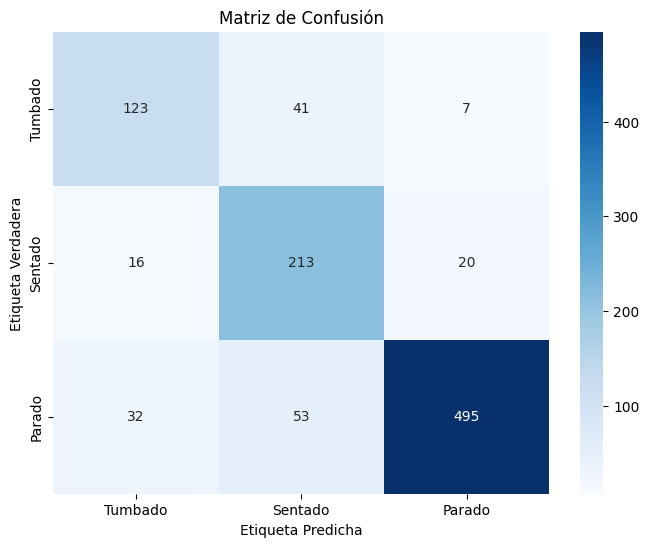

In [ ]:
evaluate_and_plot_confusion_matrix(
    model_k=model_best,  # Tu modelo YOLO
    model_p=model_pless,  # Tu modelo de clasificación
    scaler=scaler,  # Scaler para normalización
    images_dir="datasets/dog-pose/val/images",
    labels_dir="datasets/dog-pose/val/label_pose",
    lesskeypoints_list=lesskeypoints_list  # Lista de índices de keypoints
)

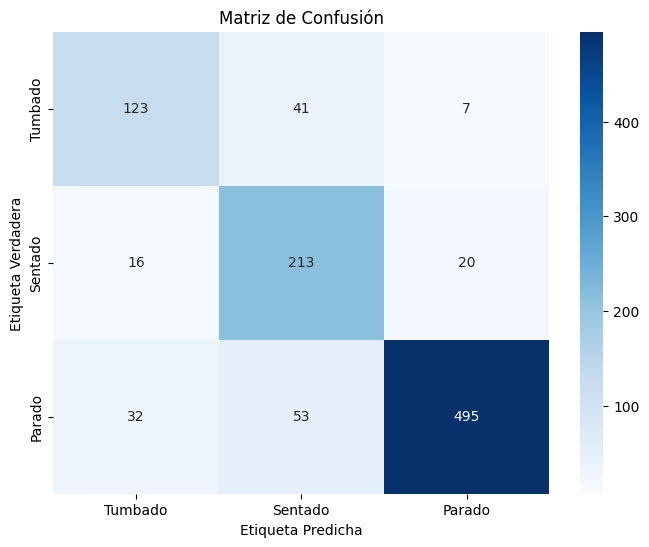

##Inferencia de pose en tiempo real